In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pylab as plt

In [2]:
token = os.environ['oanda_access_token']
account = os.environ['oanda_account_id']

In [3]:
import optuna
from oanda_bot import Bot

In [4]:
class MyBot(Bot):
    def set_param(self, a, b, c, d, stop_loss, take_profit):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        
    def atr(self, *, period: int = 14, price: str = "C"):
        a = (self.df.H - self.df.L).abs()
        b = (self.df.H - self.df[price].shift()).abs()
        c = (self.df.L - self.df[price].shift()).abs()

        df = pd.concat([a, b, c], axis=1).max(axis=1)
        return df.ewm(span=period).mean()
        
    def strategy(self):
        rsi = self.rsi(period=self.a)
        ema = self.ema(period=self.b)
        atr = self.atr(period=self.c)
        lower = ema - atr
        upper = ema + atr
        self.buy_entry = (rsi < self.d )& (self.df.C < lower)
        self.sell_entry = (rsi > 100-self.d) & (self.df.C > upper)
        self.sell_exit = ema > self.df.C
        self.buy_exit = ema < self.df.C
#         self.units = 1000 # currency unit (default=10000)
#         self.take_profit = 50 # take profit pips (default=0 take profit none)
#         self.stop_loss = 20 # stop loss pips (default=0 stop loss none)

    def backtest(
            self, *, from_date: str = "", to_date: str = "", filename: str = ""
        ) -> None:
            csv = "{}-{}-{}-{}.csv".format(
                self.instrument, self.granularity, from_date, to_date
            )
            if os.path.exists(csv):
                self.df = pd.read_csv(
                    csv, index_col=0, parse_dates=True, infer_datetime_format=True
                )
            else:
                self._candles(from_date=from_date, to_date=to_date)
                if from_date != "" and to_date != "":
                    self.df.to_csv(csv)
            self.strategy()
            o = self.df.O.values
            L = self.df.L.values
            h = self.df.H.values
            N = len(self.df)
            long_trade = np.zeros(N)
            short_trade = np.zeros(N)

            # buy entry
            buy_entry_s = np.hstack((False, self.buy_entry[:-1]))  # shift
            long_trade[buy_entry_s] = o[buy_entry_s]
            # buy exit
            buy_exit_s = np.hstack((False, self.buy_exit[:-2], True))  # shift
            long_trade[buy_exit_s] = -o[buy_exit_s]
            # sell entry
            sell_entry_s = np.hstack((False, self.sell_entry[:-1]))  # shift
            short_trade[sell_entry_s] = o[sell_entry_s]
            # sell exit
            sell_exit_s = np.hstack((False, self.sell_exit[:-2], True))  # shift
            short_trade[sell_exit_s] = -o[sell_exit_s]

            long_pl = pd.Series(np.zeros(N))  # profit/loss of buy position
            short_pl = pd.Series(np.zeros(N))  # profit/loss of sell position
            buy_price = sell_price = 0
            long_rr = []  # long return rate
            short_rr = []  # short return rate
            stop_loss = take_profit = 0

            for i in range(1, N):
                # buy entry
                if long_trade[i] > 0:
                    if buy_price == 0:
                        buy_price = long_trade[i]
                        short_trade[i] = -buy_price  # sell exit
                    else:
                        long_trade[i] = 0

                # sell entry
                if short_trade[i] > 0:
                    if sell_price == 0:
                        sell_price = short_trade[i]
                        long_trade[i] = -sell_price  # buy exit
                    else:
                        short_trade[i] = 0

                # buy exit
                if long_trade[i] < 0:
                    if buy_price != 0:
                        long_pl[i] = (
                            -(buy_price + long_trade[i]) * self.units
                        )  # profit/loss fixed
                        long_rr.append(
                            round(long_pl[i] / buy_price * 100, 2)
                        )  # long return rate
                        buy_price = 0
                    else:
                        long_trade[i] = 0

                # sell exit
                if short_trade[i] < 0:
                    if sell_price != 0:
                        short_pl[i] = (
                            sell_price + short_trade[i]
                        ) * self.units  # profit/loss fixed
                        short_rr.append(
                            round(short_pl[i] / sell_price * 100, 2)
                        )  # short return rate
                        sell_price = 0
                    else:
                        short_trade[i] = 0

                # close buy position with stop loss
                if buy_price != 0 and self.stop_loss > 0:
                    stop_price = buy_price - self.stop_loss * self.point
                    if L[i] <= stop_price:
                        long_trade[i] = -stop_price
                        long_pl[i] = (
                            -(buy_price + long_trade[i]) * self.units
                        )  # profit/loss fixed
                        long_rr.append(
                            round(long_pl[i] / buy_price * 100, 2)
                        )  # long return rate
                        buy_price = 0
                        stop_loss += 1

                # close buy positon with take profit
                if buy_price != 0 and self.take_profit > 0:
                    limit_price = buy_price + self.take_profit * self.point
                    if h[i] >= limit_price:
                        long_trade[i] = -limit_price
                        long_pl[i] = (
                            -(buy_price + long_trade[i]) * self.units
                        )  # profit/loss fixed
                        long_rr.append(
                            round(long_pl[i] / buy_price * 100, 2)
                        )  # long return rate
                        buy_price = 0
                        take_profit += 1

                # close sell position with stop loss
                if sell_price != 0 and self.stop_loss > 0:
                    stop_price = sell_price + self.stop_loss * self.point
                    if h[i] >= stop_price:
                        short_trade[i] = -stop_price
                        short_pl[i] = (
                            sell_price + short_trade[i]
                        ) * self.units  # profit/loss fixed
                        short_rr.append(
                            round(short_pl[i] / sell_price * 100, 2)
                        )  # short return rate
                        sell_price = 0
                        stop_loss += 1

                # close sell position with take profit
                if sell_price != 0 and self.take_profit > 0:
                    limit_price = sell_price - self.take_profit * self.point
                    if L[i] <= limit_price:
                        short_trade[i] = -limit_price
                        short_pl[i] = (
                            sell_price + short_trade[i]
                        ) * self.units  # profit/loss fixed
                        short_rr.append(
                            round(short_pl[i] / sell_price * 100, 2)
                        )  # short return rate
                        sell_price = 0
                        take_profit += 1

            win_trades = np.count_nonzero(long_pl.clip(lower=0)) + np.count_nonzero(
                short_pl.clip(lower=0)
            )
            lose_trades = np.count_nonzero(long_pl.clip(upper=0)) + np.count_nonzero(
                short_pl.clip(upper=0)
            )
            trades = (np.count_nonzero(long_trade) // 2) + (
                np.count_nonzero(short_trade) // 2
            )
            gross_profit = long_pl.clip(lower=0).sum() + short_pl.clip(lower=0).sum()
            gross_loss = long_pl.clip(upper=0).sum() + short_pl.clip(upper=0).sum()
            profit_pl = gross_profit + gross_loss
            self.equity = (long_pl + short_pl).cumsum()
            mdd = (self.equity.cummax() - self.equity).max()
            self.return_rate = pd.Series(short_rr + long_rr)

            s = pd.Series(dtype="object")
            s.loc["total profit"] = round(profit_pl, 3)
            s.loc["total trades"] = trades
            s.loc["win rate"] = round(win_trades / trades * 100, 3)
            s.loc["profit factor"] = round(-gross_profit / gross_loss, 3)
            s.loc["maximum drawdown"] = round(mdd, 3)
            s.loc["recovery factor"] = round(profit_pl / mdd, 3)
            s.loc["riskreward ratio"] = round(
                -(gross_profit / win_trades) / (gross_loss / lose_trades), 3
            )
            s.loc["sharpe ratio"] = round(
                self.return_rate.mean() / self.return_rate.std(), 3
            )
            s.loc["average return"] = round(self.return_rate.mean(), 3)
            s.loc["stop loss"] = stop_loss
            s.loc["take profit"] = take_profit

            return s

In [17]:
start = "2020-8-1"
end = "2021-2-14"
glan = "M1"
inst = "USD_JPY"

In [18]:
mybot = MyBot(
    account_id=account,
    access_token=token,
    environment='live',
    instrument=inst,
    granularity=glan, # 15 second candlestick,
)

In [19]:
def objective(trial):
    a = trial.suggest_int('a', 5, 50)
    b = trial.suggest_int('b', 5, 50)
    c = trial.suggest_int('c', 5, 50)
    d = trial.suggest_int('d', 20, 40)
    
    sl = trial.suggest_int('stop_loss', 5, 50)
    tp = trial.suggest_int('take_profit', 5, 50)
    
    mybot.set_param(a, b, c, d, sl, tp)
    
    score =  -mybot.backtest(from_date=start, to_date=end, filename="backtest.png")['average return']
    print('a: %d, b: %d, score: %1.2f' % (a, b, -score))
    return score

In [20]:
study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2021-02-17 17:16:48,795] A new study created in memory with name: no-name-ef39d0a3-ad3c-484e-b45f-4a478d4d7a46
[I 2021-02-17 17:17:54,662] Trial 0 finished with value: -14.346 and parameters: {'a': 28, 'b': 7, 'c': 27, 'd': 34, 'stop_loss': 37, 'take_profit': 28}. Best is trial 0 with value: -14.346.


a: 28, b: 7, score: 14.35


[I 2021-02-17 17:17:56,002] Trial 1 finished with value: -28.966 and parameters: {'a': 24, 'b': 23, 'c': 45, 'd': 24, 'stop_loss': 26, 'take_profit': 20}. Best is trial 1 with value: -28.966.


a: 24, b: 23, score: 28.97


[I 2021-02-17 17:17:57,354] Trial 2 finished with value: -28.959 and parameters: {'a': 31, 'b': 16, 'c': 25, 'd': 26, 'stop_loss': 16, 'take_profit': 46}. Best is trial 1 with value: -28.966.


a: 31, b: 16, score: 28.96


[I 2021-02-17 17:17:58,858] Trial 3 finished with value: -16.51 and parameters: {'a': 9, 'b': 42, 'c': 9, 'd': 24, 'stop_loss': 48, 'take_profit': 7}. Best is trial 1 with value: -28.966.


a: 9, b: 42, score: 16.51


[I 2021-02-17 17:18:00,171] Trial 4 finished with value: -8.912 and parameters: {'a': 37, 'b': 5, 'c': 28, 'd': 33, 'stop_loss': 37, 'take_profit': 40}. Best is trial 1 with value: -28.966.


a: 37, b: 5, score: 8.91


[I 2021-02-17 17:18:01,718] Trial 5 finished with value: -22.972 and parameters: {'a': 39, 'b': 26, 'c': 5, 'd': 38, 'stop_loss': 11, 'take_profit': 46}. Best is trial 1 with value: -28.966.


a: 39, b: 26, score: 22.97


[I 2021-02-17 17:18:03,415] Trial 6 finished with value: -14.458 and parameters: {'a': 5, 'b': 11, 'c': 45, 'd': 25, 'stop_loss': 10, 'take_profit': 12}. Best is trial 1 with value: -28.966.


a: 5, b: 11, score: 14.46


[I 2021-02-17 17:18:05,124] Trial 7 finished with value: -16.178 and parameters: {'a': 6, 'b': 48, 'c': 20, 'd': 24, 'stop_loss': 11, 'take_profit': 46}. Best is trial 1 with value: -28.966.


a: 6, b: 48, score: 16.18


[I 2021-02-17 17:18:06,599] Trial 8 finished with value: -20.271 and parameters: {'a': 13, 'b': 47, 'c': 45, 'd': 22, 'stop_loss': 34, 'take_profit': 35}. Best is trial 1 with value: -28.966.


a: 13, b: 47, score: 20.27


[I 2021-02-17 17:18:08,184] Trial 9 finished with value: -16.391 and parameters: {'a': 24, 'b': 22, 'c': 49, 'd': 37, 'stop_loss': 25, 'take_profit': 31}. Best is trial 1 with value: -28.966.


a: 24, b: 22, score: 16.39


[I 2021-02-17 17:18:09,466] Trial 10 finished with value: 260.811 and parameters: {'a': 50, 'b': 36, 'c': 36, 'd': 20, 'stop_loss': 23, 'take_profit': 18}. Best is trial 1 with value: -28.966.


a: 50, b: 36, score: -260.81


[I 2021-02-17 17:18:11,005] Trial 11 finished with value: -21.995 and parameters: {'a': 23, 'b': 19, 'c': 17, 'd': 28, 'stop_loss': 19, 'take_profit': 23}. Best is trial 1 with value: -28.966.


a: 23, b: 19, score: 22.00


[I 2021-02-17 17:18:12,469] Trial 12 finished with value: -21.85 and parameters: {'a': 31, 'b': 16, 'c': 36, 'd': 29, 'stop_loss': 19, 'take_profit': 19}. Best is trial 1 with value: -28.966.


a: 31, b: 16, score: 21.85


[I 2021-02-17 17:18:13,850] Trial 13 finished with value: -25.163 and parameters: {'a': 18, 'b': 32, 'c': 35, 'd': 27, 'stop_loss': 5, 'take_profit': 12}. Best is trial 1 with value: -28.966.


a: 18, b: 32, score: 25.16


[I 2021-02-17 17:18:15,230] Trial 14 finished with value: 4.142 and parameters: {'a': 36, 'b': 14, 'c': 21, 'd': 21, 'stop_loss': 32, 'take_profit': 36}. Best is trial 1 with value: -28.966.


a: 36, b: 14, score: -4.14


[I 2021-02-17 17:18:16,533] Trial 15 finished with value: -21.36 and parameters: {'a': 43, 'b': 25, 'c': 28, 'd': 31, 'stop_loss': 17, 'take_profit': 24}. Best is trial 1 with value: -28.966.


a: 43, b: 25, score: 21.36


[I 2021-02-17 17:18:17,973] Trial 16 finished with value: -24.853 and parameters: {'a': 18, 'b': 33, 'c': 13, 'd': 26, 'stop_loss': 49, 'take_profit': 5}. Best is trial 1 with value: -28.966.


a: 18, b: 33, score: 24.85


[I 2021-02-17 17:18:19,301] Trial 17 finished with value: -30.648 and parameters: {'a': 31, 'b': 10, 'c': 41, 'd': 23, 'stop_loss': 29, 'take_profit': 49}. Best is trial 17 with value: -30.648.


a: 31, b: 10, score: 30.65


[I 2021-02-17 17:18:20,609] Trial 18 finished with value: -20.448 and parameters: {'a': 20, 'b': 9, 'c': 50, 'd': 22, 'stop_loss': 30, 'take_profit': 50}. Best is trial 17 with value: -30.648.


a: 20, b: 9, score: 20.45


[I 2021-02-17 17:18:21,867] Trial 19 finished with value: -91.885 and parameters: {'a': 44, 'b': 21, 'c': 41, 'd': 20, 'stop_loss': 42, 'take_profit': 15}. Best is trial 19 with value: -91.885.


a: 44, b: 21, score: 91.89


[I 2021-02-17 17:18:23,164] Trial 20 finished with value: 395.06 and parameters: {'a': 50, 'b': 13, 'c': 40, 'd': 21, 'stop_loss': 43, 'take_profit': 14}. Best is trial 19 with value: -91.885.


a: 50, b: 13, score: -395.06


[I 2021-02-17 17:18:24,323] Trial 21 finished with value: -128.201 and parameters: {'a': 44, 'b': 21, 'c': 42, 'd': 23, 'stop_loss': 42, 'take_profit': 18}. Best is trial 21 with value: -128.201.


a: 44, b: 21, score: 128.20


[I 2021-02-17 17:18:25,606] Trial 22 finished with value: 58.344 and parameters: {'a': 46, 'b': 19, 'c': 40, 'd': 20, 'stop_loss': 43, 'take_profit': 8}. Best is trial 21 with value: -128.201.


a: 46, b: 19, score: -58.34


[I 2021-02-17 17:18:26,888] Trial 23 finished with value: -109.893 and parameters: {'a': 43, 'b': 31, 'c': 41, 'd': 23, 'stop_loss': 43, 'take_profit': 14}. Best is trial 21 with value: -128.201.


a: 43, b: 31, score: 109.89


[I 2021-02-17 17:18:28,129] Trial 24 finished with value: -109.987 and parameters: {'a': 44, 'b': 29, 'c': 33, 'd': 20, 'stop_loss': 44, 'take_profit': 15}. Best is trial 21 with value: -128.201.


a: 44, b: 29, score: 109.99


[I 2021-02-17 17:18:29,383] Trial 25 finished with value: -80.061 and parameters: {'a': 41, 'b': 30, 'c': 32, 'd': 22, 'stop_loss': 46, 'take_profit': 10}. Best is trial 21 with value: -128.201.


a: 41, b: 30, score: 80.06


[I 2021-02-17 17:18:30,748] Trial 26 finished with value: -19.493 and parameters: {'a': 47, 'b': 37, 'c': 32, 'd': 30, 'stop_loss': 38, 'take_profit': 17}. Best is trial 21 with value: -128.201.


a: 47, b: 37, score: 19.49


[I 2021-02-17 17:18:32,009] Trial 27 finished with value: -43.4 and parameters: {'a': 35, 'b': 29, 'c': 32, 'd': 20, 'stop_loss': 41, 'take_profit': 25}. Best is trial 21 with value: -128.201.


a: 35, b: 29, score: 43.40


[I 2021-02-17 17:18:33,312] Trial 28 finished with value: -88.352 and parameters: {'a': 47, 'b': 40, 'c': 47, 'd': 23, 'stop_loss': 46, 'take_profit': 22}. Best is trial 21 with value: -128.201.


a: 47, b: 40, score: 88.35


[I 2021-02-17 17:18:34,582] Trial 29 finished with value: -28.285 and parameters: {'a': 41, 'b': 27, 'c': 38, 'd': 26, 'stop_loss': 50, 'take_profit': 28}. Best is trial 21 with value: -128.201.


a: 41, b: 27, score: 28.29


[I 2021-02-17 17:18:35,978] Trial 30 finished with value: -23.946 and parameters: {'a': 50, 'b': 34, 'c': 43, 'd': 33, 'stop_loss': 39, 'take_profit': 5}. Best is trial 21 with value: -128.201.


a: 50, b: 34, score: 23.95


[I 2021-02-17 17:18:37,186] Trial 31 finished with value: -121.464 and parameters: {'a': 44, 'b': 20, 'c': 42, 'd': 20, 'stop_loss': 35, 'take_profit': 15}. Best is trial 21 with value: -128.201.


a: 44, b: 20, score: 121.46


[I 2021-02-17 17:18:38,440] Trial 32 finished with value: -172.8 and parameters: {'a': 45, 'b': 24, 'c': 47, 'd': 21, 'stop_loss': 34, 'take_profit': 15}. Best is trial 32 with value: -172.8.


a: 45, b: 24, score: 172.80


[I 2021-02-17 17:18:39,687] Trial 33 finished with value: -160.137 and parameters: {'a': 46, 'b': 24, 'c': 50, 'd': 21, 'stop_loss': 34, 'take_profit': 20}. Best is trial 32 with value: -172.8.


a: 46, b: 24, score: 160.14


[I 2021-02-17 17:18:41,024] Trial 34 finished with value: -147.758 and parameters: {'a': 48, 'b': 23, 'c': 50, 'd': 21, 'stop_loss': 33, 'take_profit': 21}. Best is trial 32 with value: -172.8.


a: 48, b: 23, score: 147.76


[I 2021-02-17 17:18:42,263] Trial 35 finished with value: -70.798 and parameters: {'a': 48, 'b': 24, 'c': 50, 'd': 24, 'stop_loss': 33, 'take_profit': 20}. Best is trial 32 with value: -172.8.


a: 48, b: 24, score: 70.80


[I 2021-02-17 17:18:43,585] Trial 36 finished with value: -52.759 and parameters: {'a': 40, 'b': 17, 'c': 47, 'd': 22, 'stop_loss': 36, 'take_profit': 21}. Best is trial 32 with value: -172.8.


a: 40, b: 17, score: 52.76


[I 2021-02-17 17:18:44,857] Trial 37 finished with value: -43.889 and parameters: {'a': 37, 'b': 23, 'c': 47, 'd': 25, 'stop_loss': 27, 'take_profit': 26}. Best is trial 32 with value: -172.8.


a: 37, b: 23, score: 43.89


[I 2021-02-17 17:18:46,135] Trial 38 finished with value: -69.046 and parameters: {'a': 33, 'b': 26, 'c': 50, 'd': 21, 'stop_loss': 31, 'take_profit': 29}. Best is trial 32 with value: -172.8.


a: 33, b: 26, score: 69.05


[I 2021-02-17 17:18:47,424] Trial 39 finished with value: -16.019 and parameters: {'a': 49, 'b': 18, 'c': 45, 'd': 25, 'stop_loss': 39, 'take_profit': 10}. Best is trial 32 with value: -172.8.


a: 49, b: 18, score: 16.02


[I 2021-02-17 17:18:48,683] Trial 40 finished with value: -65.127 and parameters: {'a': 39, 'b': 22, 'c': 48, 'd': 23, 'stop_loss': 23, 'take_profit': 17}. Best is trial 32 with value: -172.8.


a: 39, b: 22, score: 65.13


[I 2021-02-17 17:18:49,918] Trial 41 finished with value: -126.479 and parameters: {'a': 45, 'b': 20, 'c': 43, 'd': 21, 'stop_loss': 35, 'take_profit': 17}. Best is trial 32 with value: -172.8.


a: 45, b: 20, score: 126.48


[I 2021-02-17 17:18:51,410] Trial 42 finished with value: -18.576 and parameters: {'a': 46, 'b': 24, 'c': 44, 'd': 40, 'stop_loss': 36, 'take_profit': 20}. Best is trial 32 with value: -172.8.


a: 46, b: 24, score: 18.58


[I 2021-02-17 17:18:52,661] Trial 43 finished with value: -102.326 and parameters: {'a': 46, 'b': 15, 'c': 45, 'd': 21, 'stop_loss': 33, 'take_profit': 17}. Best is trial 32 with value: -172.8.


a: 46, b: 15, score: 102.33


[I 2021-02-17 17:18:53,941] Trial 44 finished with value: -102.984 and parameters: {'a': 41, 'b': 27, 'c': 50, 'd': 22, 'stop_loss': 29, 'take_profit': 22}. Best is trial 32 with value: -172.8.


a: 41, b: 27, score: 102.98


[I 2021-02-17 17:18:55,357] Trial 45 finished with value: -66.944 and parameters: {'a': 50, 'b': 21, 'c': 38, 'd': 24, 'stop_loss': 39, 'take_profit': 12}. Best is trial 32 with value: -172.8.


a: 50, b: 21, score: 66.94


[I 2021-02-17 17:18:56,758] Trial 46 finished with value: -84.926 and parameters: {'a': 45, 'b': 12, 'c': 47, 'd': 21, 'stop_loss': 25, 'take_profit': 19}. Best is trial 32 with value: -172.8.


a: 45, b: 12, score: 84.93


[I 2021-02-17 17:18:58,166] Trial 47 finished with value: -27.309 and parameters: {'a': 28, 'b': 18, 'c': 43, 'd': 23, 'stop_loss': 34, 'take_profit': 30}. Best is trial 32 with value: -172.8.


a: 28, b: 18, score: 27.31


[I 2021-02-17 17:18:59,520] Trial 48 finished with value: -24.615 and parameters: {'a': 38, 'b': 23, 'c': 38, 'd': 27, 'stop_loss': 37, 'take_profit': 26}. Best is trial 32 with value: -172.8.


a: 38, b: 23, score: 24.61


[I 2021-02-17 17:19:00,957] Trial 49 finished with value: -21.453 and parameters: {'a': 42, 'b': 25, 'c': 45, 'd': 36, 'stop_loss': 40, 'take_profit': 32}. Best is trial 32 with value: -172.8.


a: 42, b: 25, score: 21.45


[I 2021-02-17 17:19:02,218] Trial 50 finished with value: -220.649 and parameters: {'a': 48, 'b': 28, 'c': 48, 'd': 21, 'stop_loss': 28, 'take_profit': 23}. Best is trial 50 with value: -220.649.


a: 48, b: 28, score: 220.65


[I 2021-02-17 17:19:03,578] Trial 51 finished with value: -190.777 and parameters: {'a': 48, 'b': 29, 'c': 48, 'd': 21, 'stop_loss': 31, 'take_profit': 23}. Best is trial 50 with value: -220.649.


a: 48, b: 29, score: 190.78


[I 2021-02-17 17:19:04,911] Trial 52 finished with value: -68.748 and parameters: {'a': 48, 'b': 28, 'c': 48, 'd': 24, 'stop_loss': 25, 'take_profit': 22}. Best is trial 50 with value: -220.649.


a: 48, b: 28, score: 68.75


[I 2021-02-17 17:19:06,248] Trial 53 finished with value: -190.516 and parameters: {'a': 48, 'b': 26, 'c': 50, 'd': 22, 'stop_loss': 28, 'take_profit': 23}. Best is trial 50 with value: -220.649.


a: 48, b: 26, score: 190.52


[I 2021-02-17 17:19:07,516] Trial 54 finished with value: -160.401 and parameters: {'a': 48, 'b': 33, 'c': 50, 'd': 21, 'stop_loss': 28, 'take_profit': 24}. Best is trial 50 with value: -220.649.


a: 48, b: 33, score: 160.40


[I 2021-02-17 17:19:08,674] Trial 55 finished with value: -33.684 and parameters: {'a': 50, 'b': 35, 'c': 48, 'd': 22, 'stop_loss': 23, 'take_profit': 25}. Best is trial 50 with value: -220.649.


a: 50, b: 35, score: 33.68


[I 2021-02-17 17:19:10,016] Trial 56 finished with value: -9.608 and parameters: {'a': 48, 'b': 32, 'c': 49, 'd': 20, 'stop_loss': 28, 'take_profit': 27}. Best is trial 50 with value: -220.649.


a: 48, b: 32, score: 9.61


[I 2021-02-17 17:19:11,267] Trial 57 finished with value: -21.073 and parameters: {'a': 49, 'b': 37, 'c': 46, 'd': 22, 'stop_loss': 31, 'take_profit': 33}. Best is trial 50 with value: -220.649.


a: 49, b: 37, score: 21.07


[I 2021-02-17 17:19:12,748] Trial 58 finished with value: -24.448 and parameters: {'a': 13, 'b': 30, 'c': 50, 'd': 25, 'stop_loss': 21, 'take_profit': 23}. Best is trial 50 with value: -220.649.


a: 13, b: 30, score: 24.45


[I 2021-02-17 17:19:14,040] Trial 59 finished with value: -84.863 and parameters: {'a': 42, 'b': 39, 'c': 8, 'd': 20, 'stop_loss': 27, 'take_profit': 24}. Best is trial 50 with value: -220.649.


a: 42, b: 39, score: 84.86


[I 2021-02-17 17:19:15,372] Trial 60 finished with value: -145.882 and parameters: {'a': 46, 'b': 44, 'c': 49, 'd': 21, 'stop_loss': 30, 'take_profit': 24}. Best is trial 50 with value: -220.649.


a: 46, b: 44, score: 145.88


[I 2021-02-17 17:19:16,676] Trial 61 finished with value: -176.031 and parameters: {'a': 48, 'b': 28, 'c': 50, 'd': 21, 'stop_loss': 32, 'take_profit': 21}. Best is trial 50 with value: -220.649.


a: 48, b: 28, score: 176.03


[I 2021-02-17 17:19:17,943] Trial 62 finished with value: 2.186 and parameters: {'a': 50, 'b': 32, 'c': 46, 'd': 22, 'stop_loss': 31, 'take_profit': 19}. Best is trial 50 with value: -220.649.


a: 50, b: 32, score: -2.19


[I 2021-02-17 17:19:19,198] Trial 63 finished with value: -69.8 and parameters: {'a': 47, 'b': 28, 'c': 49, 'd': 20, 'stop_loss': 29, 'take_profit': 27}. Best is trial 50 with value: -220.649.


a: 47, b: 28, score: 69.80


[I 2021-02-17 17:19:20,478] Trial 64 finished with value: -180.665 and parameters: {'a': 43, 'b': 30, 'c': 46, 'd': 21, 'stop_loss': 27, 'take_profit': 23}. Best is trial 50 with value: -220.649.


a: 43, b: 30, score: 180.66


[I 2021-02-17 17:19:21,742] Trial 65 finished with value: -91.887 and parameters: {'a': 43, 'b': 30, 'c': 23, 'd': 23, 'stop_loss': 25, 'take_profit': 23}. Best is trial 50 with value: -220.649.


a: 43, b: 30, score: 91.89


[I 2021-02-17 17:19:23,030] Trial 66 finished with value: 167.785 and parameters: {'a': 49, 'b': 34, 'c': 46, 'd': 20, 'stop_loss': 21, 'take_profit': 29}. Best is trial 50 with value: -220.649.


a: 49, b: 34, score: -167.78


[I 2021-02-17 17:19:24,169] Trial 67 finished with value: -107.04 and parameters: {'a': 45, 'b': 26, 'c': 44, 'd': 22, 'stop_loss': 26, 'take_profit': 25}. Best is trial 50 with value: -220.649.


a: 45, b: 26, score: 107.04


[I 2021-02-17 17:19:25,441] Trial 68 finished with value: -89.377 and parameters: {'a': 43, 'b': 29, 'c': 48, 'd': 24, 'stop_loss': 28, 'take_profit': 28}. Best is trial 50 with value: -220.649.


a: 43, b: 29, score: 89.38


[I 2021-02-17 17:19:26,719] Trial 69 finished with value: -77.202 and parameters: {'a': 47, 'b': 31, 'c': 16, 'd': 21, 'stop_loss': 23, 'take_profit': 21}. Best is trial 50 with value: -220.649.


a: 47, b: 31, score: 77.20


[I 2021-02-17 17:19:28,022] Trial 70 finished with value: -55.719 and parameters: {'a': 25, 'b': 33, 'c': 44, 'd': 23, 'stop_loss': 32, 'take_profit': 23}. Best is trial 50 with value: -220.649.


a: 25, b: 33, score: 55.72


[I 2021-02-17 17:19:29,275] Trial 71 finished with value: -150.944 and parameters: {'a': 45, 'b': 25, 'c': 50, 'd': 21, 'stop_loss': 30, 'take_profit': 19}. Best is trial 50 with value: -220.649.


a: 45, b: 25, score: 150.94


[I 2021-02-17 17:19:30,534] Trial 72 finished with value: 15.079 and parameters: {'a': 48, 'b': 27, 'c': 48, 'd': 20, 'stop_loss': 32, 'take_profit': 20}. Best is trial 50 with value: -220.649.


a: 48, b: 27, score: -15.08


[I 2021-02-17 17:19:31,783] Trial 73 finished with value: -109.657 and parameters: {'a': 50, 'b': 26, 'c': 46, 'd': 22, 'stop_loss': 34, 'take_profit': 15}. Best is trial 50 with value: -220.649.


a: 50, b: 26, score: 109.66


[I 2021-02-17 17:19:33,091] Trial 74 finished with value: -131.707 and parameters: {'a': 47, 'b': 28, 'c': 50, 'd': 21, 'stop_loss': 27, 'take_profit': 26}. Best is trial 50 with value: -220.649.


a: 47, b: 28, score: 131.71


[I 2021-02-17 17:19:34,345] Trial 75 finished with value: -137.196 and parameters: {'a': 44, 'b': 31, 'c': 47, 'd': 20, 'stop_loss': 29, 'take_profit': 18}. Best is trial 50 with value: -220.649.


a: 44, b: 31, score: 137.20


[I 2021-02-17 17:19:35,646] Trial 76 finished with value: -72.894 and parameters: {'a': 42, 'b': 24, 'c': 49, 'd': 21, 'stop_loss': 35, 'take_profit': 22}. Best is trial 50 with value: -220.649.


a: 42, b: 24, score: 72.89


[I 2021-02-17 17:19:36,916] Trial 77 finished with value: -60.441 and parameters: {'a': 46, 'b': 35, 'c': 42, 'd': 22, 'stop_loss': 26, 'take_profit': 16}. Best is trial 50 with value: -220.649.


a: 46, b: 35, score: 60.44


[I 2021-02-17 17:19:38,164] Trial 78 finished with value: -125.042 and parameters: {'a': 49, 'b': 29, 'c': 47, 'd': 23, 'stop_loss': 31, 'take_profit': 13}. Best is trial 50 with value: -220.649.


a: 49, b: 29, score: 125.04


[I 2021-02-17 17:19:39,531] Trial 79 finished with value: -77.32 and parameters: {'a': 40, 'b': 25, 'c': 49, 'd': 22, 'stop_loss': 33, 'take_profit': 21}. Best is trial 50 with value: -220.649.


a: 40, b: 25, score: 77.32


[I 2021-02-17 17:19:40,733] Trial 80 finished with value: -20.176 and parameters: {'a': 45, 'b': 22, 'c': 40, 'd': 32, 'stop_loss': 37, 'take_profit': 24}. Best is trial 50 with value: -220.649.


a: 45, b: 22, score: 20.18


[I 2021-02-17 17:19:41,981] Trial 81 finished with value: -173.358 and parameters: {'a': 44, 'b': 26, 'c': 50, 'd': 21, 'stop_loss': 30, 'take_profit': 19}. Best is trial 50 with value: -220.649.


a: 44, b: 26, score: 173.36


[I 2021-02-17 17:19:43,285] Trial 82 finished with value: -106.837 and parameters: {'a': 47, 'b': 27, 'c': 30, 'd': 21, 'stop_loss': 28, 'take_profit': 18}. Best is trial 50 with value: -220.649.


a: 47, b: 27, score: 106.84


[I 2021-02-17 17:19:44,539] Trial 83 finished with value: -157.198 and parameters: {'a': 44, 'b': 30, 'c': 50, 'd': 20, 'stop_loss': 30, 'take_profit': 20}. Best is trial 50 with value: -220.649.


a: 44, b: 30, score: 157.20


[I 2021-02-17 17:19:45,806] Trial 84 finished with value: 100.916 and parameters: {'a': 49, 'b': 33, 'c': 48, 'd': 21, 'stop_loss': 32, 'take_profit': 23}. Best is trial 50 with value: -220.649.


a: 49, b: 33, score: -100.92


[I 2021-02-17 17:19:47,052] Trial 85 finished with value: -66.201 and parameters: {'a': 40, 'b': 24, 'c': 45, 'd': 23, 'stop_loss': 26, 'take_profit': 25}. Best is trial 50 with value: -220.649.


a: 40, b: 24, score: 66.20


[I 2021-02-17 17:19:48,315] Trial 86 finished with value: -135.633 and parameters: {'a': 43, 'b': 26, 'c': 46, 'd': 22, 'stop_loss': 30, 'take_profit': 16}. Best is trial 50 with value: -220.649.


a: 43, b: 26, score: 135.63


[I 2021-02-17 17:19:49,564] Trial 87 finished with value: -82.793 and parameters: {'a': 46, 'b': 28, 'c': 48, 'd': 24, 'stop_loss': 24, 'take_profit': 21}. Best is trial 50 with value: -220.649.


a: 46, b: 28, score: 82.79


[I 2021-02-17 17:19:50,835] Trial 88 finished with value: 98.74 and parameters: {'a': 48, 'b': 23, 'c': 50, 'd': 20, 'stop_loss': 34, 'take_profit': 19}. Best is trial 50 with value: -220.649.


a: 48, b: 23, score: -98.74


[I 2021-02-17 17:19:52,134] Trial 89 finished with value: -55.246 and parameters: {'a': 35, 'b': 29, 'c': 47, 'd': 21, 'stop_loss': 28, 'take_profit': 22}. Best is trial 50 with value: -220.649.


a: 35, b: 29, score: 55.25


[I 2021-02-17 17:19:53,429] Trial 90 finished with value: -88.515 and parameters: {'a': 45, 'b': 31, 'c': 44, 'd': 23, 'stop_loss': 21, 'take_profit': 10}. Best is trial 50 with value: -220.649.


a: 45, b: 31, score: 88.52


[I 2021-02-17 17:19:54,758] Trial 91 finished with value: -157.198 and parameters: {'a': 44, 'b': 30, 'c': 50, 'd': 20, 'stop_loss': 30, 'take_profit': 20}. Best is trial 50 with value: -220.649.


a: 44, b: 30, score: 157.20


[I 2021-02-17 17:19:55,931] Trial 92 finished with value: -88.667 and parameters: {'a': 42, 'b': 27, 'c': 50, 'd': 21, 'stop_loss': 36, 'take_profit': 24}. Best is trial 50 with value: -220.649.


a: 42, b: 27, score: 88.67


[I 2021-02-17 17:19:57,182] Trial 93 finished with value: 18.528 and parameters: {'a': 47, 'b': 30, 'c': 48, 'd': 20, 'stop_loss': 31, 'take_profit': 20}. Best is trial 50 with value: -220.649.


a: 47, b: 30, score: -18.53


[I 2021-02-17 17:19:58,494] Trial 94 finished with value: -97.583 and parameters: {'a': 44, 'b': 32, 'c': 49, 'd': 22, 'stop_loss': 27, 'take_profit': 18}. Best is trial 50 with value: -220.649.


a: 44, b: 32, score: 97.58


[I 2021-02-17 17:19:59,824] Trial 95 finished with value: -41.086 and parameters: {'a': 48, 'b': 26, 'c': 46, 'd': 20, 'stop_loss': 29, 'take_profit': 26}. Best is trial 50 with value: -220.649.


a: 48, b: 26, score: 41.09


[I 2021-02-17 17:20:01,137] Trial 96 finished with value: -90.026 and parameters: {'a': 38, 'b': 25, 'c': 49, 'd': 21, 'stop_loss': 32, 'take_profit': 22}. Best is trial 50 with value: -220.649.


a: 38, b: 25, score: 90.03


[I 2021-02-17 17:20:02,397] Trial 97 finished with value: -91.821 and parameters: {'a': 41, 'b': 22, 'c': 43, 'd': 22, 'stop_loss': 33, 'take_profit': 21}. Best is trial 50 with value: -220.649.


a: 41, b: 22, score: 91.82


[I 2021-02-17 17:20:03,640] Trial 98 finished with value: -177.521 and parameters: {'a': 46, 'b': 34, 'c': 26, 'd': 21, 'stop_loss': 35, 'take_profit': 14}. Best is trial 50 with value: -220.649.


a: 46, b: 34, score: 177.52


[I 2021-02-17 17:20:04,898] Trial 99 finished with value: 297.23 and parameters: {'a': 49, 'b': 36, 'c': 26, 'd': 21, 'stop_loss': 36, 'take_profit': 11}. Best is trial 50 with value: -220.649.


a: 49, b: 36, score: -297.23


[I 2021-02-17 17:20:06,226] Trial 100 finished with value: -144.489 and parameters: {'a': 46, 'b': 34, 'c': 24, 'd': 22, 'stop_loss': 34, 'take_profit': 13}. Best is trial 50 with value: -220.649.


a: 46, b: 34, score: 144.49


[I 2021-02-17 17:20:07,479] Trial 101 finished with value: -108.152 and parameters: {'a': 43, 'b': 28, 'c': 29, 'd': 20, 'stop_loss': 29, 'take_profit': 14}. Best is trial 50 with value: -220.649.


a: 43, b: 28, score: 108.15


[I 2021-02-17 17:20:08,727] Trial 102 finished with value: 89.057 and parameters: {'a': 45, 'b': 38, 'c': 22, 'd': 20, 'stop_loss': 37, 'take_profit': 42}. Best is trial 50 with value: -220.649.


a: 45, b: 38, score: -89.06


[I 2021-02-17 17:20:09,990] Trial 103 finished with value: 337.276 and parameters: {'a': 50, 'b': 33, 'c': 18, 'd': 21, 'stop_loss': 35, 'take_profit': 8}. Best is trial 50 with value: -220.649.


a: 50, b: 33, score: -337.28


[I 2021-02-17 17:20:11,264] Trial 104 finished with value: -8.732 and parameters: {'a': 48, 'b': 5, 'c': 25, 'd': 29, 'stop_loss': 26, 'take_profit': 16}. Best is trial 50 with value: -220.649.


a: 48, b: 5, score: 8.73


[I 2021-02-17 17:20:12,425] Trial 105 finished with value: -102.088 and parameters: {'a': 47, 'b': 31, 'c': 28, 'd': 22, 'stop_loss': 30, 'take_profit': 24}. Best is trial 50 with value: -220.649.


a: 47, b: 31, score: 102.09


[I 2021-02-17 17:20:13,688] Trial 106 finished with value: -49.669 and parameters: {'a': 30, 'b': 29, 'c': 26, 'd': 21, 'stop_loss': 32, 'take_profit': 19}. Best is trial 50 with value: -220.649.


a: 30, b: 29, score: 49.67


[I 2021-02-17 17:20:15,007] Trial 107 finished with value: -185.834 and parameters: {'a': 44, 'b': 35, 'c': 47, 'd': 20, 'stop_loss': 24, 'take_profit': 23}. Best is trial 50 with value: -220.649.


a: 44, b: 35, score: 185.83


[I 2021-02-17 17:20:16,516] Trial 108 finished with value: -24.724 and parameters: {'a': 46, 'b': 41, 'c': 45, 'd': 35, 'stop_loss': 22, 'take_profit': 27}. Best is trial 50 with value: -220.649.


a: 46, b: 41, score: 24.72


[I 2021-02-17 17:20:17,934] Trial 109 finished with value: -97.551 and parameters: {'a': 49, 'b': 35, 'c': 47, 'd': 23, 'stop_loss': 24, 'take_profit': 23}. Best is trial 50 with value: -220.649.


a: 49, b: 35, score: 97.55


[I 2021-02-17 17:20:19,338] Trial 110 finished with value: 65.033 and parameters: {'a': 50, 'b': 20, 'c': 46, 'd': 21, 'stop_loss': 14, 'take_profit': 22}. Best is trial 50 with value: -220.649.


a: 50, b: 20, score: -65.03


[I 2021-02-17 17:20:20,674] Trial 111 finished with value: -133.904 and parameters: {'a': 44, 'b': 36, 'c': 49, 'd': 20, 'stop_loss': 28, 'take_profit': 25}. Best is trial 50 with value: -220.649.


a: 44, b: 36, score: 133.90


[I 2021-02-17 17:20:22,032] Trial 112 finished with value: -158.792 and parameters: {'a': 42, 'b': 32, 'c': 48, 'd': 20, 'stop_loss': 24, 'take_profit': 17}. Best is trial 50 with value: -220.649.


a: 42, b: 32, score: 158.79


[I 2021-02-17 17:20:23,525] Trial 113 finished with value: -136.945 and parameters: {'a': 41, 'b': 32, 'c': 48, 'd': 21, 'stop_loss': 19, 'take_profit': 17}. Best is trial 50 with value: -220.649.


a: 41, b: 32, score: 136.94


[I 2021-02-17 17:20:24,816] Trial 114 finished with value: -106.642 and parameters: {'a': 42, 'b': 34, 'c': 47, 'd': 22, 'stop_loss': 25, 'take_profit': 14}. Best is trial 50 with value: -220.649.


a: 42, b: 34, score: 106.64


[I 2021-02-17 17:20:26,123] Trial 115 finished with value: 46.537 and parameters: {'a': 46, 'b': 37, 'c': 49, 'd': 20, 'stop_loss': 22, 'take_profit': 18}. Best is trial 50 with value: -220.649.


a: 46, b: 37, score: -46.54


[I 2021-02-17 17:20:27,436] Trial 116 finished with value: -133.246 and parameters: {'a': 45, 'b': 33, 'c': 47, 'd': 21, 'stop_loss': 27, 'take_profit': 17}. Best is trial 50 with value: -220.649.


a: 45, b: 33, score: 133.25


[I 2021-02-17 17:20:28,567] Trial 117 finished with value: -153.535 and parameters: {'a': 47, 'b': 24, 'c': 44, 'd': 22, 'stop_loss': 38, 'take_profit': 16}. Best is trial 50 with value: -220.649.


a: 47, b: 24, score: 153.53


[I 2021-02-17 17:20:29,916] Trial 118 finished with value: -168.116 and parameters: {'a': 43, 'b': 26, 'c': 48, 'd': 20, 'stop_loss': 24, 'take_profit': 21}. Best is trial 50 with value: -220.649.


a: 43, b: 26, score: 168.12


[I 2021-02-17 17:20:31,321] Trial 119 finished with value: -164.31 and parameters: {'a': 43, 'b': 25, 'c': 45, 'd': 21, 'stop_loss': 33, 'take_profit': 24}. Best is trial 50 with value: -220.649.


a: 43, b: 25, score: 164.31


[I 2021-02-17 17:20:32,635] Trial 120 finished with value: -121.552 and parameters: {'a': 40, 'b': 26, 'c': 42, 'd': 21, 'stop_loss': 6, 'take_profit': 23}. Best is trial 50 with value: -220.649.


a: 40, b: 26, score: 121.55


[I 2021-02-17 17:20:33,944] Trial 121 finished with value: -202.495 and parameters: {'a': 45, 'b': 23, 'c': 45, 'd': 21, 'stop_loss': 33, 'take_profit': 24}. Best is trial 50 with value: -220.649.


a: 45, b: 23, score: 202.50


[I 2021-02-17 17:20:35,263] Trial 122 finished with value: -118.705 and parameters: {'a': 43, 'b': 27, 'c': 45, 'd': 20, 'stop_loss': 33, 'take_profit': 24}. Best is trial 50 with value: -220.649.


a: 43, b: 27, score: 118.70


[I 2021-02-17 17:20:36,615] Trial 123 finished with value: -136.88 and parameters: {'a': 43, 'b': 25, 'c': 45, 'd': 22, 'stop_loss': 31, 'take_profit': 26}. Best is trial 50 with value: -220.649.


a: 43, b: 25, score: 136.88


[I 2021-02-17 17:20:37,870] Trial 124 finished with value: -195.356 and parameters: {'a': 45, 'b': 23, 'c': 43, 'd': 21, 'stop_loss': 35, 'take_profit': 25}. Best is trial 50 with value: -220.649.


a: 45, b: 23, score: 195.36


[I 2021-02-17 17:20:39,292] Trial 125 finished with value: -19.003 and parameters: {'a': 45, 'b': 22, 'c': 43, 'd': 39, 'stop_loss': 35, 'take_profit': 25}. Best is trial 50 with value: -220.649.


a: 45, b: 22, score: 19.00


[I 2021-02-17 17:20:40,576] Trial 126 finished with value: -203.639 and parameters: {'a': 44, 'b': 23, 'c': 46, 'd': 21, 'stop_loss': 38, 'take_profit': 28}. Best is trial 50 with value: -220.649.


a: 44, b: 23, score: 203.64


[I 2021-02-17 17:20:41,844] Trial 127 finished with value: -90.846 and parameters: {'a': 39, 'b': 23, 'c': 41, 'd': 22, 'stop_loss': 38, 'take_profit': 28}. Best is trial 50 with value: -220.649.


a: 39, b: 23, score: 90.85


[I 2021-02-17 17:20:43,088] Trial 128 finished with value: -197.775 and parameters: {'a': 44, 'b': 24, 'c': 46, 'd': 21, 'stop_loss': 40, 'take_profit': 29}. Best is trial 50 with value: -220.649.


a: 44, b: 24, score: 197.78


[I 2021-02-17 17:20:44,476] Trial 129 finished with value: -99.707 and parameters: {'a': 45, 'b': 21, 'c': 46, 'd': 23, 'stop_loss': 40, 'take_profit': 31}. Best is trial 50 with value: -220.649.


a: 45, b: 21, score: 99.71


[I 2021-02-17 17:20:45,631] Trial 130 finished with value: -83.461 and parameters: {'a': 47, 'b': 23, 'c': 44, 'd': 21, 'stop_loss': 41, 'take_profit': 30}. Best is trial 50 with value: -220.649.


a: 47, b: 23, score: 83.46


[I 2021-02-17 17:20:46,922] Trial 131 finished with value: -142.49 and parameters: {'a': 44, 'b': 21, 'c': 46, 'd': 20, 'stop_loss': 40, 'take_profit': 27}. Best is trial 50 with value: -220.649.


a: 44, b: 21, score: 142.49


[I 2021-02-17 17:20:48,155] Trial 132 finished with value: -139.781 and parameters: {'a': 41, 'b': 27, 'c': 47, 'd': 21, 'stop_loss': 36, 'take_profit': 26}. Best is trial 50 with value: -220.649.


a: 41, b: 27, score: 139.78


[I 2021-02-17 17:20:49,405] Trial 133 finished with value: -108.716 and parameters: {'a': 46, 'b': 24, 'c': 44, 'd': 22, 'stop_loss': 34, 'take_profit': 29}. Best is trial 50 with value: -220.649.


a: 46, b: 24, score: 108.72


[I 2021-02-17 17:20:50,709] Trial 134 finished with value: -109.171 and parameters: {'a': 44, 'b': 20, 'c': 48, 'd': 20, 'stop_loss': 31, 'take_profit': 33}. Best is trial 50 with value: -220.649.


a: 44, b: 20, score: 109.17


[I 2021-02-17 17:20:51,972] Trial 135 finished with value: -165.735 and parameters: {'a': 43, 'b': 26, 'c': 46, 'd': 21, 'stop_loss': 44, 'take_profit': 21}. Best is trial 50 with value: -220.649.


a: 43, b: 26, score: 165.74


[I 2021-02-17 17:20:53,264] Trial 136 finished with value: 65.964 and parameters: {'a': 46, 'b': 28, 'c': 43, 'd': 20, 'stop_loss': 35, 'take_profit': 29}. Best is trial 50 with value: -220.649.


a: 46, b: 28, score: -65.96


[I 2021-02-17 17:20:54,509] Trial 137 finished with value: -103.193 and parameters: {'a': 49, 'b': 25, 'c': 49, 'd': 22, 'stop_loss': 37, 'take_profit': 23}. Best is trial 50 with value: -220.649.


a: 49, b: 25, score: 103.19


[I 2021-02-17 17:20:55,819] Trial 138 finished with value: -90.881 and parameters: {'a': 47, 'b': 19, 'c': 27, 'd': 21, 'stop_loss': 38, 'take_profit': 22}. Best is trial 50 with value: -220.649.


a: 47, b: 19, score: 90.88


[I 2021-02-17 17:20:57,131] Trial 139 finished with value: -134.388 and parameters: {'a': 42, 'b': 22, 'c': 47, 'd': 20, 'stop_loss': 39, 'take_profit': 25}. Best is trial 50 with value: -220.649.


a: 42, b: 22, score: 134.39


[I 2021-02-17 17:20:58,398] Trial 140 finished with value: -181.536 and parameters: {'a': 48, 'b': 23, 'c': 48, 'd': 21, 'stop_loss': 29, 'take_profit': 21}. Best is trial 50 with value: -220.649.


a: 48, b: 23, score: 181.54


[I 2021-02-17 17:20:59,658] Trial 141 finished with value: -209.37 and parameters: {'a': 48, 'b': 24, 'c': 48, 'd': 21, 'stop_loss': 26, 'take_profit': 21}. Best is trial 50 with value: -220.649.


a: 48, b: 24, score: 209.37


[I 2021-02-17 17:21:00,872] Trial 142 finished with value: -203.984 and parameters: {'a': 48, 'b': 23, 'c': 49, 'd': 21, 'stop_loss': 27, 'take_profit': 22}. Best is trial 50 with value: -220.649.


a: 48, b: 23, score: 203.98


[I 2021-02-17 17:21:02,130] Trial 143 finished with value: -216.058 and parameters: {'a': 48, 'b': 23, 'c': 49, 'd': 22, 'stop_loss': 29, 'take_profit': 22}. Best is trial 50 with value: -220.649.


a: 48, b: 23, score: 216.06


[I 2021-02-17 17:21:03,434] Trial 144 finished with value: -122.778 and parameters: {'a': 48, 'b': 21, 'c': 49, 'd': 23, 'stop_loss': 26, 'take_profit': 23}. Best is trial 50 with value: -220.649.


a: 48, b: 21, score: 122.78


[I 2021-02-17 17:21:04,754] Trial 145 finished with value: -226.626 and parameters: {'a': 49, 'b': 23, 'c': 47, 'd': 22, 'stop_loss': 27, 'take_profit': 22}. Best is trial 145 with value: -226.626.


a: 49, b: 23, score: 226.63


[I 2021-02-17 17:21:06,003] Trial 146 finished with value: -152.943 and parameters: {'a': 50, 'b': 23, 'c': 45, 'd': 22, 'stop_loss': 27, 'take_profit': 27}. Best is trial 145 with value: -226.626.


a: 50, b: 23, score: 152.94


[I 2021-02-17 17:21:07,313] Trial 147 finished with value: -194.927 and parameters: {'a': 49, 'b': 22, 'c': 47, 'd': 22, 'stop_loss': 29, 'take_profit': 22}. Best is trial 145 with value: -226.626.


a: 49, b: 22, score: 194.93


[I 2021-02-17 17:21:08,623] Trial 148 finished with value: -173.362 and parameters: {'a': 49, 'b': 19, 'c': 47, 'd': 23, 'stop_loss': 29, 'take_profit': 22}. Best is trial 145 with value: -226.626.


a: 49, b: 19, score: 173.36


[I 2021-02-17 17:21:09,903] Trial 149 finished with value: -129.215 and parameters: {'a': 50, 'b': 22, 'c': 46, 'd': 22, 'stop_loss': 28, 'take_profit': 25}. Best is trial 145 with value: -226.626.


a: 50, b: 22, score: 129.22


[I 2021-02-17 17:21:11,185] Trial 150 finished with value: -150.024 and parameters: {'a': 48, 'b': 24, 'c': 46, 'd': 23, 'stop_loss': 25, 'take_profit': 22}. Best is trial 145 with value: -226.626.


a: 48, b: 24, score: 150.02


[I 2021-02-17 17:21:12,556] Trial 151 finished with value: -188.267 and parameters: {'a': 48, 'b': 23, 'c': 48, 'd': 22, 'stop_loss': 26, 'take_profit': 24}. Best is trial 145 with value: -226.626.


a: 48, b: 23, score: 188.27


[I 2021-02-17 17:21:13,879] Trial 152 finished with value: -188.267 and parameters: {'a': 48, 'b': 23, 'c': 48, 'd': 22, 'stop_loss': 26, 'take_profit': 24}. Best is trial 145 with value: -226.626.


a: 48, b: 23, score: 188.27


[I 2021-02-17 17:21:15,144] Trial 153 finished with value: -188.267 and parameters: {'a': 48, 'b': 23, 'c': 48, 'd': 22, 'stop_loss': 26, 'take_profit': 24}. Best is trial 145 with value: -226.626.


a: 48, b: 23, score: 188.27


[I 2021-02-17 17:21:16,434] Trial 154 finished with value: -183.11 and parameters: {'a': 49, 'b': 21, 'c': 49, 'd': 22, 'stop_loss': 25, 'take_profit': 24}. Best is trial 145 with value: -226.626.


a: 49, b: 21, score: 183.11


[I 2021-02-17 17:21:17,589] Trial 155 finished with value: -87.304 and parameters: {'a': 50, 'b': 22, 'c': 48, 'd': 24, 'stop_loss': 26, 'take_profit': 26}. Best is trial 145 with value: -226.626.


a: 50, b: 22, score: 87.30


[I 2021-02-17 17:21:18,845] Trial 156 finished with value: -148.281 and parameters: {'a': 49, 'b': 50, 'c': 50, 'd': 22, 'stop_loss': 27, 'take_profit': 23}. Best is trial 145 with value: -226.626.


a: 49, b: 50, score: 148.28


[I 2021-02-17 17:21:20,101] Trial 157 finished with value: -157.849 and parameters: {'a': 47, 'b': 24, 'c': 47, 'd': 23, 'stop_loss': 28, 'take_profit': 25}. Best is trial 145 with value: -226.626.


a: 47, b: 24, score: 157.85


[I 2021-02-17 17:21:21,415] Trial 158 finished with value: -138.597 and parameters: {'a': 47, 'b': 20, 'c': 48, 'd': 22, 'stop_loss': 23, 'take_profit': 28}. Best is trial 145 with value: -226.626.


a: 47, b: 20, score: 138.60


[I 2021-02-17 17:21:22,726] Trial 159 finished with value: -98.865 and parameters: {'a': 48, 'b': 17, 'c': 49, 'd': 23, 'stop_loss': 26, 'take_profit': 24}. Best is trial 145 with value: -226.626.


a: 48, b: 17, score: 98.86


[I 2021-02-17 17:21:23,968] Trial 160 finished with value: -93.148 and parameters: {'a': 50, 'b': 23, 'c': 45, 'd': 22, 'stop_loss': 25, 'take_profit': 23}. Best is trial 145 with value: -226.626.


a: 50, b: 23, score: 93.15


[I 2021-02-17 17:21:25,299] Trial 161 finished with value: -180.104 and parameters: {'a': 49, 'b': 21, 'c': 49, 'd': 22, 'stop_loss': 24, 'take_profit': 24}. Best is trial 145 with value: -226.626.


a: 49, b: 21, score: 180.10


[I 2021-02-17 17:21:26,598] Trial 162 finished with value: -178.715 and parameters: {'a': 49, 'b': 23, 'c': 47, 'd': 22, 'stop_loss': 26, 'take_profit': 26}. Best is trial 145 with value: -226.626.


a: 49, b: 23, score: 178.72


[I 2021-02-17 17:21:27,842] Trial 163 finished with value: -209.591 and parameters: {'a': 48, 'b': 21, 'c': 49, 'd': 22, 'stop_loss': 28, 'take_profit': 22}. Best is trial 145 with value: -226.626.


a: 48, b: 21, score: 209.59


[I 2021-02-17 17:21:29,094] Trial 164 finished with value: -138.189 and parameters: {'a': 47, 'b': 19, 'c': 50, 'd': 22, 'stop_loss': 28, 'take_profit': 20}. Best is trial 145 with value: -226.626.


a: 47, b: 19, score: 138.19


[I 2021-02-17 17:21:30,434] Trial 165 finished with value: -149.652 and parameters: {'a': 48, 'b': 22, 'c': 48, 'd': 23, 'stop_loss': 29, 'take_profit': 22}. Best is trial 145 with value: -226.626.


a: 48, b: 22, score: 149.65


[I 2021-02-17 17:21:31,695] Trial 166 finished with value: -215.774 and parameters: {'a': 46, 'b': 24, 'c': 47, 'd': 21, 'stop_loss': 27, 'take_profit': 23}. Best is trial 145 with value: -226.626.


a: 46, b: 24, score: 215.77


[I 2021-02-17 17:21:32,835] Trial 167 finished with value: -208.773 and parameters: {'a': 46, 'b': 24, 'c': 48, 'd': 21, 'stop_loss': 27, 'take_profit': 21}. Best is trial 145 with value: -226.626.


a: 46, b: 24, score: 208.77


[I 2021-02-17 17:21:34,090] Trial 168 finished with value: -218.41 and parameters: {'a': 46, 'b': 25, 'c': 50, 'd': 21, 'stop_loss': 27, 'take_profit': 21}. Best is trial 145 with value: -226.626.


a: 46, b: 25, score: 218.41


[I 2021-02-17 17:21:35,332] Trial 169 finished with value: -219.435 and parameters: {'a': 46, 'b': 25, 'c': 50, 'd': 21, 'stop_loss': 27, 'take_profit': 20}. Best is trial 145 with value: -226.626.


a: 46, b: 25, score: 219.44


[I 2021-02-17 17:21:36,577] Trial 170 finished with value: -219.435 and parameters: {'a': 46, 'b': 25, 'c': 50, 'd': 21, 'stop_loss': 27, 'take_profit': 20}. Best is trial 145 with value: -226.626.


a: 46, b: 25, score: 219.44


[I 2021-02-17 17:21:37,855] Trial 171 finished with value: -219.435 and parameters: {'a': 46, 'b': 25, 'c': 50, 'd': 21, 'stop_loss': 27, 'take_profit': 20}. Best is trial 145 with value: -226.626.


a: 46, b: 25, score: 219.44


[I 2021-02-17 17:21:39,150] Trial 172 finished with value: -214.018 and parameters: {'a': 46, 'b': 25, 'c': 50, 'd': 21, 'stop_loss': 27, 'take_profit': 19}. Best is trial 145 with value: -226.626.


a: 46, b: 25, score: 214.02


[I 2021-02-17 17:21:40,404] Trial 173 finished with value: -219.435 and parameters: {'a': 46, 'b': 25, 'c': 50, 'd': 21, 'stop_loss': 27, 'take_profit': 20}. Best is trial 145 with value: -226.626.


a: 46, b: 25, score: 219.44


[I 2021-02-17 17:21:41,757] Trial 174 finished with value: -214.018 and parameters: {'a': 46, 'b': 25, 'c': 50, 'd': 21, 'stop_loss': 27, 'take_profit': 19}. Best is trial 145 with value: -226.626.


a: 46, b: 25, score: 214.02


[I 2021-02-17 17:21:43,013] Trial 175 finished with value: -214.018 and parameters: {'a': 46, 'b': 25, 'c': 50, 'd': 21, 'stop_loss': 27, 'take_profit': 19}. Best is trial 145 with value: -226.626.


a: 46, b: 25, score: 214.02


[I 2021-02-17 17:21:44,259] Trial 176 finished with value: -214.018 and parameters: {'a': 46, 'b': 25, 'c': 50, 'd': 21, 'stop_loss': 27, 'take_profit': 19}. Best is trial 145 with value: -226.626.


a: 46, b: 25, score: 214.02


[I 2021-02-17 17:21:45,538] Trial 177 finished with value: -214.018 and parameters: {'a': 46, 'b': 25, 'c': 50, 'd': 21, 'stop_loss': 27, 'take_profit': 19}. Best is trial 145 with value: -226.626.


a: 46, b: 25, score: 214.02


[I 2021-02-17 17:21:46,848] Trial 178 finished with value: -214.018 and parameters: {'a': 46, 'b': 25, 'c': 50, 'd': 21, 'stop_loss': 27, 'take_profit': 19}. Best is trial 145 with value: -226.626.


a: 46, b: 25, score: 214.02


[I 2021-02-17 17:21:48,195] Trial 179 finished with value: -220.348 and parameters: {'a': 46, 'b': 26, 'c': 50, 'd': 21, 'stop_loss': 27, 'take_profit': 19}. Best is trial 145 with value: -226.626.


a: 46, b: 26, score: 220.35


[I 2021-02-17 17:21:49,368] Trial 180 finished with value: -206.924 and parameters: {'a': 46, 'b': 25, 'c': 50, 'd': 21, 'stop_loss': 28, 'take_profit': 19}. Best is trial 145 with value: -226.626.


a: 46, b: 25, score: 206.92


[I 2021-02-17 17:21:50,678] Trial 181 finished with value: -219.435 and parameters: {'a': 46, 'b': 25, 'c': 50, 'd': 21, 'stop_loss': 27, 'take_profit': 20}. Best is trial 145 with value: -226.626.


a: 46, b: 25, score: 219.44


[I 2021-02-17 17:21:51,927] Trial 182 finished with value: -207.024 and parameters: {'a': 46, 'b': 25, 'c': 50, 'd': 21, 'stop_loss': 27, 'take_profit': 18}. Best is trial 145 with value: -226.626.


a: 46, b: 25, score: 207.02


[I 2021-02-17 17:21:53,218] Trial 183 finished with value: 27.905 and parameters: {'a': 46, 'b': 25, 'c': 50, 'd': 20, 'stop_loss': 28, 'take_profit': 19}. Best is trial 145 with value: -226.626.


a: 46, b: 25, score: -27.91


[I 2021-02-17 17:21:54,448] Trial 184 finished with value: -193.942 and parameters: {'a': 45, 'b': 27, 'c': 50, 'd': 21, 'stop_loss': 27, 'take_profit': 20}. Best is trial 145 with value: -226.626.


a: 45, b: 27, score: 193.94


[I 2021-02-17 17:21:55,755] Trial 185 finished with value: -76.078 and parameters: {'a': 47, 'b': 26, 'c': 50, 'd': 20, 'stop_loss': 25, 'take_profit': 19}. Best is trial 145 with value: -226.626.


a: 47, b: 26, score: 76.08


[I 2021-02-17 17:21:56,996] Trial 186 finished with value: -212.34 and parameters: {'a': 46, 'b': 25, 'c': 50, 'd': 21, 'stop_loss': 28, 'take_profit': 20}. Best is trial 145 with value: -226.626.


a: 46, b: 25, score: 212.34


[I 2021-02-17 17:21:58,245] Trial 187 finished with value: -171.363 and parameters: {'a': 45, 'b': 26, 'c': 50, 'd': 21, 'stop_loss': 29, 'take_profit': 20}. Best is trial 145 with value: -226.626.


a: 45, b: 26, score: 171.36


[I 2021-02-17 17:21:59,505] Trial 188 finished with value: 16.866 and parameters: {'a': 46, 'b': 27, 'c': 50, 'd': 20, 'stop_loss': 28, 'take_profit': 18}. Best is trial 145 with value: -226.626.


a: 46, b: 27, score: -16.87


[I 2021-02-17 17:22:01,102] Trial 189 finished with value: -16.952 and parameters: {'a': 7, 'b': 25, 'c': 49, 'd': 21, 'stop_loss': 30, 'take_profit': 20}. Best is trial 145 with value: -226.626.


a: 7, b: 25, score: 16.95


[I 2021-02-17 17:22:02,358] Trial 190 finished with value: -207.024 and parameters: {'a': 46, 'b': 25, 'c': 50, 'd': 21, 'stop_loss': 27, 'take_profit': 18}. Best is trial 145 with value: -226.626.


a: 46, b: 25, score: 207.02


[I 2021-02-17 17:22:03,691] Trial 191 finished with value: -137.905 and parameters: {'a': 47, 'b': 26, 'c': 49, 'd': 21, 'stop_loss': 25, 'take_profit': 19}. Best is trial 145 with value: -226.626.


a: 47, b: 26, score: 137.91


[I 2021-02-17 17:22:04,925] Trial 192 finished with value: -116.217 and parameters: {'a': 47, 'b': 24, 'c': 50, 'd': 21, 'stop_loss': 27, 'take_profit': 20}. Best is trial 145 with value: -226.626.


a: 47, b: 24, score: 116.22


[I 2021-02-17 17:22:06,171] Trial 193 finished with value: -96.236 and parameters: {'a': 45, 'b': 27, 'c': 49, 'd': 20, 'stop_loss': 29, 'take_profit': 19}. Best is trial 145 with value: -226.626.


a: 45, b: 27, score: 96.24


[I 2021-02-17 17:22:07,447] Trial 194 finished with value: -134.667 and parameters: {'a': 47, 'b': 25, 'c': 49, 'd': 21, 'stop_loss': 26, 'take_profit': 21}. Best is trial 145 with value: -226.626.


a: 47, b: 25, score: 134.67


[I 2021-02-17 17:22:08,690] Trial 195 finished with value: -71.569 and parameters: {'a': 45, 'b': 24, 'c': 50, 'd': 20, 'stop_loss': 28, 'take_profit': 18}. Best is trial 145 with value: -226.626.


a: 45, b: 24, score: 71.57


[I 2021-02-17 17:22:09,953] Trial 196 finished with value: -225.764 and parameters: {'a': 46, 'b': 26, 'c': 50, 'd': 21, 'stop_loss': 27, 'take_profit': 20}. Best is trial 145 with value: -226.626.


a: 46, b: 26, score: 225.76


[I 2021-02-17 17:22:11,251] Trial 197 finished with value: 21.383 and parameters: {'a': 46, 'b': 26, 'c': 50, 'd': 20, 'stop_loss': 27, 'take_profit': 17}. Best is trial 145 with value: -226.626.


a: 46, b: 26, score: -21.38


[I 2021-02-17 17:22:12,570] Trial 198 finished with value: -179.821 and parameters: {'a': 45, 'b': 27, 'c': 50, 'd': 21, 'stop_loss': 29, 'take_profit': 20}. Best is trial 145 with value: -226.626.


a: 45, b: 27, score: 179.82


[I 2021-02-17 17:22:13,846] Trial 199 finished with value: -206.924 and parameters: {'a': 46, 'b': 25, 'c': 49, 'd': 21, 'stop_loss': 28, 'take_profit': 19}. Best is trial 145 with value: -226.626.


a: 46, b: 25, score: 206.92


[I 2021-02-17 17:22:15,094] Trial 200 finished with value: -66.418 and parameters: {'a': 47, 'b': 28, 'c': 49, 'd': 20, 'stop_loss': 27, 'take_profit': 20}. Best is trial 145 with value: -226.626.


a: 47, b: 28, score: 66.42


[I 2021-02-17 17:22:16,410] Trial 201 finished with value: -231.768 and parameters: {'a': 46, 'b': 26, 'c': 50, 'd': 21, 'stop_loss': 26, 'take_profit': 21}. Best is trial 201 with value: -231.768.


a: 46, b: 26, score: 231.77


[I 2021-02-17 17:22:17,699] Trial 202 finished with value: -220.383 and parameters: {'a': 46, 'b': 26, 'c': 50, 'd': 21, 'stop_loss': 26, 'take_profit': 18}. Best is trial 201 with value: -231.768.


a: 46, b: 26, score: 220.38


[I 2021-02-17 17:22:18,988] Trial 203 finished with value: -178.592 and parameters: {'a': 45, 'b': 26, 'c': 50, 'd': 21, 'stop_loss': 26, 'take_profit': 18}. Best is trial 201 with value: -231.768.


a: 45, b: 26, score: 178.59


[I 2021-02-17 17:22:20,260] Trial 204 finished with value: -228.144 and parameters: {'a': 46, 'b': 25, 'c': 50, 'd': 21, 'stop_loss': 25, 'take_profit': 19}. Best is trial 201 with value: -231.768.


a: 46, b: 25, score: 228.14


[I 2021-02-17 17:22:21,410] Trial 205 finished with value: -191.16 and parameters: {'a': 44, 'b': 27, 'c': 50, 'd': 20, 'stop_loss': 25, 'take_profit': 17}. Best is trial 201 with value: -231.768.


a: 44, b: 27, score: 191.16


[I 2021-02-17 17:22:22,680] Trial 206 finished with value: -195.294 and parameters: {'a': 46, 'b': 26, 'c': 49, 'd': 21, 'stop_loss': 24, 'take_profit': 19}. Best is trial 201 with value: -231.768.


a: 46, b: 26, score: 195.29


[I 2021-02-17 17:22:23,937] Trial 207 finished with value: -97.821 and parameters: {'a': 47, 'b': 25, 'c': 50, 'd': 21, 'stop_loss': 25, 'take_profit': 16}. Best is trial 201 with value: -231.768.


a: 47, b: 25, score: 97.82


[I 2021-02-17 17:22:25,262] Trial 208 finished with value: -127.974 and parameters: {'a': 45, 'b': 26, 'c': 50, 'd': 20, 'stop_loss': 26, 'take_profit': 21}. Best is trial 201 with value: -231.768.


a: 45, b: 26, score: 127.97


[I 2021-02-17 17:22:26,507] Trial 209 finished with value: -200.972 and parameters: {'a': 45, 'b': 28, 'c': 49, 'd': 21, 'stop_loss': 25, 'take_profit': 19}. Best is trial 201 with value: -231.768.


a: 45, b: 28, score: 200.97


[I 2021-02-17 17:22:27,791] Trial 210 finished with value: -139.799 and parameters: {'a': 47, 'b': 25, 'c': 49, 'd': 22, 'stop_loss': 27, 'take_profit': 18}. Best is trial 201 with value: -231.768.


a: 47, b: 25, score: 139.80


[I 2021-02-17 17:22:29,051] Trial 211 finished with value: -209.797 and parameters: {'a': 46, 'b': 24, 'c': 50, 'd': 21, 'stop_loss': 27, 'take_profit': 20}. Best is trial 201 with value: -231.768.


a: 46, b: 24, score: 209.80


[I 2021-02-17 17:22:30,436] Trial 212 finished with value: -180.891 and parameters: {'a': 44, 'b': 25, 'c': 50, 'd': 21, 'stop_loss': 28, 'take_profit': 21}. Best is trial 201 with value: -231.768.


a: 44, b: 25, score: 180.89


[I 2021-02-17 17:22:31,703] Trial 213 finished with value: -242.139 and parameters: {'a': 46, 'b': 27, 'c': 49, 'd': 21, 'stop_loss': 26, 'take_profit': 20}. Best is trial 213 with value: -242.139.


a: 46, b: 27, score: 242.14


[I 2021-02-17 17:22:33,004] Trial 214 finished with value: -124.995 and parameters: {'a': 47, 'b': 27, 'c': 49, 'd': 21, 'stop_loss': 26, 'take_profit': 18}. Best is trial 213 with value: -242.139.


a: 47, b: 27, score: 125.00


[I 2021-02-17 17:22:34,275] Trial 215 finished with value: 16.994 and parameters: {'a': 46, 'b': 24, 'c': 48, 'd': 20, 'stop_loss': 26, 'take_profit': 19}. Best is trial 213 with value: -242.139.


a: 46, b: 24, score: -16.99


[I 2021-02-17 17:22:35,652] Trial 216 finished with value: -27.938 and parameters: {'a': 19, 'b': 26, 'c': 5, 'd': 22, 'stop_loss': 24, 'take_profit': 21}. Best is trial 213 with value: -242.139.


a: 19, b: 26, score: 27.94


[I 2021-02-17 17:22:36,825] Trial 217 finished with value: -193.773 and parameters: {'a': 45, 'b': 28, 'c': 11, 'd': 21, 'stop_loss': 27, 'take_profit': 20}. Best is trial 213 with value: -242.139.


a: 45, b: 28, score: 193.77


[I 2021-02-17 17:22:38,125] Trial 218 finished with value: -201.418 and parameters: {'a': 46, 'b': 27, 'c': 49, 'd': 21, 'stop_loss': 30, 'take_profit': 18}. Best is trial 213 with value: -242.139.


a: 46, b: 27, score: 201.42


[I 2021-02-17 17:22:39,375] Trial 219 finished with value: -137.6 and parameters: {'a': 47, 'b': 24, 'c': 50, 'd': 22, 'stop_loss': 25, 'take_profit': 17}. Best is trial 213 with value: -242.139.


a: 47, b: 24, score: 137.60


[I 2021-02-17 17:22:40,637] Trial 220 finished with value: -218.369 and parameters: {'a': 44, 'b': 25, 'c': 48, 'd': 20, 'stop_loss': 23, 'take_profit': 20}. Best is trial 213 with value: -242.139.


a: 44, b: 25, score: 218.37


[I 2021-02-17 17:22:41,903] Trial 221 finished with value: -197.855 and parameters: {'a': 44, 'b': 26, 'c': 34, 'd': 20, 'stop_loss': 26, 'take_profit': 20}. Best is trial 213 with value: -242.139.


a: 44, b: 26, score: 197.85


[I 2021-02-17 17:22:43,161] Trial 222 finished with value: -42.924 and parameters: {'a': 46, 'b': 25, 'c': 48, 'd': 20, 'stop_loss': 23, 'take_profit': 21}. Best is trial 213 with value: -242.139.


a: 46, b: 25, score: 42.92


[I 2021-02-17 17:22:44,423] Trial 223 finished with value: -112.316 and parameters: {'a': 47, 'b': 26, 'c': 49, 'd': 21, 'stop_loss': 22, 'take_profit': 19}. Best is trial 213 with value: -242.139.


a: 47, b: 26, score: 112.32


[I 2021-02-17 17:22:45,744] Trial 224 finished with value: -179.154 and parameters: {'a': 45, 'b': 25, 'c': 48, 'd': 21, 'stop_loss': 27, 'take_profit': 20}. Best is trial 213 with value: -242.139.


a: 45, b: 25, score: 179.15


[I 2021-02-17 17:22:47,006] Trial 225 finished with value: -164.11 and parameters: {'a': 44, 'b': 24, 'c': 50, 'd': 21, 'stop_loss': 29, 'take_profit': 19}. Best is trial 213 with value: -242.139.


a: 44, b: 24, score: 164.11


[I 2021-02-17 17:22:48,147] Trial 226 finished with value: -139.412 and parameters: {'a': 47, 'b': 27, 'c': 48, 'd': 21, 'stop_loss': 27, 'take_profit': 21}. Best is trial 213 with value: -242.139.


a: 47, b: 27, score: 139.41


[I 2021-02-17 17:22:49,392] Trial 227 finished with value: -114.952 and parameters: {'a': 45, 'b': 29, 'c': 50, 'd': 20, 'stop_loss': 26, 'take_profit': 17}. Best is trial 213 with value: -242.139.


a: 45, b: 29, score: 114.95


[I 2021-02-17 17:22:50,790] Trial 228 finished with value: -25.11 and parameters: {'a': 15, 'b': 26, 'c': 49, 'd': 22, 'stop_loss': 28, 'take_profit': 20}. Best is trial 213 with value: -242.139.


a: 15, b: 26, score: 25.11


[I 2021-02-17 17:22:52,087] Trial 229 finished with value: -146.042 and parameters: {'a': 46, 'b': 24, 'c': 49, 'd': 22, 'stop_loss': 25, 'take_profit': 19}. Best is trial 213 with value: -242.139.


a: 46, b: 24, score: 146.04


[I 2021-02-17 17:22:53,329] Trial 230 finished with value: -207.024 and parameters: {'a': 46, 'b': 25, 'c': 50, 'd': 21, 'stop_loss': 27, 'take_profit': 18}. Best is trial 213 with value: -242.139.


a: 46, b: 25, score: 207.02


[I 2021-02-17 17:22:54,574] Trial 231 finished with value: -212.34 and parameters: {'a': 46, 'b': 25, 'c': 50, 'd': 21, 'stop_loss': 28, 'take_profit': 20}. Best is trial 213 with value: -242.139.


a: 46, b: 25, score: 212.34


[I 2021-02-17 17:22:55,857] Trial 232 finished with value: -113.435 and parameters: {'a': 47, 'b': 24, 'c': 50, 'd': 21, 'stop_loss': 28, 'take_profit': 22}. Best is trial 213 with value: -242.139.


a: 47, b: 24, score: 113.44


[I 2021-02-17 17:22:57,011] Trial 233 finished with value: -167.154 and parameters: {'a': 45, 'b': 25, 'c': 49, 'd': 21, 'stop_loss': 29, 'take_profit': 21}. Best is trial 213 with value: -242.139.


a: 45, b: 25, score: 167.15


[I 2021-02-17 17:22:58,303] Trial 234 finished with value: 3.066 and parameters: {'a': 46, 'b': 26, 'c': 48, 'd': 20, 'stop_loss': 27, 'take_profit': 20}. Best is trial 213 with value: -242.139.


a: 46, b: 26, score: -3.07


[I 2021-02-17 17:22:59,662] Trial 235 finished with value: -79.203 and parameters: {'a': 47, 'b': 7, 'c': 50, 'd': 20, 'stop_loss': 26, 'take_profit': 18}. Best is trial 213 with value: -242.139.


a: 47, b: 7, score: 79.20


[I 2021-02-17 17:23:00,922] Trial 236 finished with value: -188.868 and parameters: {'a': 45, 'b': 28, 'c': 50, 'd': 21, 'stop_loss': 28, 'take_profit': 21}. Best is trial 213 with value: -242.139.


a: 45, b: 28, score: 188.87


[I 2021-02-17 17:23:02,243] Trial 237 finished with value: -216.237 and parameters: {'a': 48, 'b': 27, 'c': 49, 'd': 21, 'stop_loss': 26, 'take_profit': 19}. Best is trial 213 with value: -242.139.


a: 48, b: 27, score: 216.24


[I 2021-02-17 17:23:03,492] Trial 238 finished with value: -173.966 and parameters: {'a': 48, 'b': 27, 'c': 47, 'd': 22, 'stop_loss': 24, 'take_profit': 19}. Best is trial 213 with value: -242.139.


a: 48, b: 27, score: 173.97


[I 2021-02-17 17:23:04,744] Trial 239 finished with value: -218.803 and parameters: {'a': 48, 'b': 26, 'c': 48, 'd': 21, 'stop_loss': 25, 'take_profit': 19}. Best is trial 213 with value: -242.139.


a: 48, b: 26, score: 218.80


[I 2021-02-17 17:23:06,005] Trial 240 finished with value: -204.649 and parameters: {'a': 48, 'b': 29, 'c': 48, 'd': 22, 'stop_loss': 25, 'take_profit': 18}. Best is trial 213 with value: -242.139.


a: 48, b: 29, score: 204.65


[I 2021-02-17 17:23:07,305] Trial 241 finished with value: -128.781 and parameters: {'a': 47, 'b': 26, 'c': 48, 'd': 21, 'stop_loss': 26, 'take_profit': 19}. Best is trial 213 with value: -242.139.


a: 47, b: 26, score: 128.78


[I 2021-02-17 17:23:08,567] Trial 242 finished with value: -24.869 and parameters: {'a': 49, 'b': 27, 'c': 49, 'd': 21, 'stop_loss': 25, 'take_profit': 20}. Best is trial 213 with value: -242.139.


a: 49, b: 27, score: 24.87


[I 2021-02-17 17:23:09,913] Trial 243 finished with value: -128.781 and parameters: {'a': 47, 'b': 26, 'c': 49, 'd': 21, 'stop_loss': 26, 'take_profit': 19}. Best is trial 213 with value: -242.139.


a: 47, b: 26, score: 128.78


[I 2021-02-17 17:23:11,264] Trial 244 finished with value: -36.844 and parameters: {'a': 22, 'b': 25, 'c': 47, 'd': 20, 'stop_loss': 27, 'take_profit': 19}. Best is trial 213 with value: -242.139.


a: 22, b: 25, score: 36.84


[I 2021-02-17 17:23:12,535] Trial 245 finished with value: -209.37 and parameters: {'a': 48, 'b': 24, 'c': 50, 'd': 21, 'stop_loss': 26, 'take_profit': 21}. Best is trial 213 with value: -242.139.


a: 48, b: 24, score: 209.37


[I 2021-02-17 17:23:13,959] Trial 246 finished with value: -211.756 and parameters: {'a': 46, 'b': 26, 'c': 49, 'd': 21, 'stop_loss': 23, 'take_profit': 22}. Best is trial 213 with value: -242.139.


a: 46, b: 26, score: 211.76


[I 2021-02-17 17:23:15,207] Trial 247 finished with value: -138.563 and parameters: {'a': 45, 'b': 28, 'c': 48, 'd': 20, 'stop_loss': 24, 'take_profit': 17}. Best is trial 213 with value: -242.139.


a: 45, b: 28, score: 138.56


[I 2021-02-17 17:23:16,528] Trial 248 finished with value: -173.202 and parameters: {'a': 48, 'b': 24, 'c': 49, 'd': 22, 'stop_loss': 27, 'take_profit': 18}. Best is trial 213 with value: -242.139.


a: 48, b: 24, score: 173.20


[I 2021-02-17 17:23:17,734] Trial 249 finished with value: -249.236 and parameters: {'a': 46, 'b': 27, 'c': 50, 'd': 21, 'stop_loss': 25, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 46, b: 27, score: 249.24


[I 2021-02-17 17:23:18,994] Trial 250 finished with value: -208.518 and parameters: {'a': 44, 'b': 26, 'c': 50, 'd': 21, 'stop_loss': 25, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 44, b: 26, score: 208.52


[I 2021-02-17 17:23:20,298] Trial 251 finished with value: -121.053 and parameters: {'a': 47, 'b': 28, 'c': 48, 'd': 22, 'stop_loss': 24, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 47, b: 28, score: 121.05


[I 2021-02-17 17:23:21,569] Trial 252 finished with value: -46.072 and parameters: {'a': 49, 'b': 27, 'c': 47, 'd': 27, 'stop_loss': 26, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 49, b: 27, score: 46.07


[I 2021-02-17 17:23:22,861] Trial 253 finished with value: 13.977 and parameters: {'a': 46, 'b': 27, 'c': 49, 'd': 20, 'stop_loss': 29, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 46, b: 27, score: -13.98


[I 2021-02-17 17:23:24,174] Trial 254 finished with value: -190.924 and parameters: {'a': 45, 'b': 24, 'c': 50, 'd': 21, 'stop_loss': 25, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 45, b: 24, score: 190.92


[I 2021-02-17 17:23:25,492] Trial 255 finished with value: -124.694 and parameters: {'a': 47, 'b': 25, 'c': 47, 'd': 21, 'stop_loss': 27, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 47, b: 25, score: 124.69


[I 2021-02-17 17:23:26,742] Trial 256 finished with value: -11.265 and parameters: {'a': 48, 'b': 26, 'c': 48, 'd': 20, 'stop_loss': 28, 'take_profit': 18}. Best is trial 249 with value: -249.236.


a: 48, b: 26, score: 11.27


[I 2021-02-17 17:23:28,006] Trial 257 finished with value: -154.427 and parameters: {'a': 46, 'b': 25, 'c': 49, 'd': 22, 'stop_loss': 25, 'take_profit': 16}. Best is trial 249 with value: -249.236.


a: 46, b: 25, score: 154.43


[I 2021-02-17 17:23:29,312] Trial 258 finished with value: -192.409 and parameters: {'a': 44, 'b': 28, 'c': 50, 'd': 21, 'stop_loss': 26, 'take_profit': 19}. Best is trial 249 with value: -249.236.


a: 44, b: 28, score: 192.41


[I 2021-02-17 17:23:30,618] Trial 259 finished with value: -149.574 and parameters: {'a': 45, 'b': 23, 'c': 50, 'd': 22, 'stop_loss': 28, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 45, b: 23, score: 149.57


[I 2021-02-17 17:23:31,879] Trial 260 finished with value: -58.729 and parameters: {'a': 48, 'b': 27, 'c': 49, 'd': 20, 'stop_loss': 27, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 48, b: 27, score: 58.73


[I 2021-02-17 17:23:33,066] Trial 261 finished with value: -42.629 and parameters: {'a': 26, 'b': 24, 'c': 48, 'd': 21, 'stop_loss': 23, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 26, b: 24, score: 42.63


[I 2021-02-17 17:23:34,314] Trial 262 finished with value: -136.253 and parameters: {'a': 47, 'b': 27, 'c': 50, 'd': 21, 'stop_loss': 26, 'take_profit': 19}. Best is trial 249 with value: -249.236.


a: 47, b: 27, score: 136.25


[I 2021-02-17 17:23:35,615] Trial 263 finished with value: -192.171 and parameters: {'a': 46, 'b': 26, 'c': 37, 'd': 21, 'stop_loss': 29, 'take_profit': 17}. Best is trial 249 with value: -249.236.


a: 46, b: 26, score: 192.17


[I 2021-02-17 17:23:36,870] Trial 264 finished with value: -217.405 and parameters: {'a': 49, 'b': 23, 'c': 49, 'd': 22, 'stop_loss': 27, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 49, b: 23, score: 217.41


[I 2021-02-17 17:23:38,290] Trial 265 finished with value: -42.289 and parameters: {'a': 49, 'b': 29, 'c': 49, 'd': 31, 'stop_loss': 25, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 49, b: 29, score: 42.29


[I 2021-02-17 17:23:39,588] Trial 266 finished with value: -111.532 and parameters: {'a': 50, 'b': 22, 'c': 47, 'd': 22, 'stop_loss': 28, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 50, b: 22, score: 111.53


[I 2021-02-17 17:23:40,846] Trial 267 finished with value: -201.0 and parameters: {'a': 49, 'b': 23, 'c': 48, 'd': 22, 'stop_loss': 30, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 49, b: 23, score: 201.00


[I 2021-02-17 17:23:42,099] Trial 268 finished with value: -145.253 and parameters: {'a': 47, 'b': 24, 'c': 49, 'd': 22, 'stop_loss': 20, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 47, b: 24, score: 145.25


[I 2021-02-17 17:23:43,355] Trial 269 finished with value: 157.64 and parameters: {'a': 50, 'b': 23, 'c': 48, 'd': 20, 'stop_loss': 26, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 50, b: 23, score: -157.64


[I 2021-02-17 17:23:44,528] Trial 270 finished with value: -206.053 and parameters: {'a': 48, 'b': 25, 'c': 49, 'd': 21, 'stop_loss': 24, 'take_profit': 19}. Best is trial 249 with value: -249.236.


a: 48, b: 25, score: 206.05


[I 2021-02-17 17:23:45,789] Trial 271 finished with value: -113.887 and parameters: {'a': 44, 'b': 26, 'c': 50, 'd': 22, 'stop_loss': 27, 'take_profit': 18}. Best is trial 249 with value: -249.236.


a: 44, b: 26, score: 113.89


[I 2021-02-17 17:23:47,039] Trial 272 finished with value: -104.313 and parameters: {'a': 47, 'b': 24, 'c': 47, 'd': 21, 'stop_loss': 29, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 47, b: 24, score: 104.31


[I 2021-02-17 17:23:48,327] Trial 273 finished with value: -193.612 and parameters: {'a': 49, 'b': 25, 'c': 50, 'd': 22, 'stop_loss': 22, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 49, b: 25, score: 193.61


[I 2021-02-17 17:23:49,591] Trial 274 finished with value: -125.614 and parameters: {'a': 45, 'b': 27, 'c': 49, 'd': 20, 'stop_loss': 26, 'take_profit': 19}. Best is trial 249 with value: -249.236.


a: 45, b: 27, score: 125.61


[I 2021-02-17 17:23:50,891] Trial 275 finished with value: -206.26 and parameters: {'a': 46, 'b': 26, 'c': 48, 'd': 21, 'stop_loss': 28, 'take_profit': 18}. Best is trial 249 with value: -249.236.


a: 46, b: 26, score: 206.26


[I 2021-02-17 17:23:52,150] Trial 276 finished with value: -99.206 and parameters: {'a': 45, 'b': 22, 'c': 50, 'd': 20, 'stop_loss': 27, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 45, b: 22, score: 99.21


[I 2021-02-17 17:23:53,329] Trial 277 finished with value: -208.028 and parameters: {'a': 48, 'b': 25, 'c': 49, 'd': 21, 'stop_loss': 27, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 48, b: 25, score: 208.03


[I 2021-02-17 17:23:54,578] Trial 278 finished with value: -194.744 and parameters: {'a': 48, 'b': 24, 'c': 48, 'd': 22, 'stop_loss': 25, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 48, b: 24, score: 194.74


[I 2021-02-17 17:23:55,823] Trial 279 finished with value: -86.377 and parameters: {'a': 47, 'b': 28, 'c': 47, 'd': 21, 'stop_loss': 24, 'take_profit': 19}. Best is trial 249 with value: -249.236.


a: 47, b: 28, score: 86.38


[I 2021-02-17 17:23:57,065] Trial 280 finished with value: -117.274 and parameters: {'a': 46, 'b': 26, 'c': 50, 'd': 22, 'stop_loss': 26, 'take_profit': 17}. Best is trial 249 with value: -249.236.


a: 46, b: 26, score: 117.27


[I 2021-02-17 17:23:58,306] Trial 281 finished with value: -180.021 and parameters: {'a': 47, 'b': 23, 'c': 49, 'd': 21, 'stop_loss': 28, 'take_profit': 23}. Best is trial 249 with value: -249.236.


a: 47, b: 23, score: 180.02


[I 2021-02-17 17:23:59,570] Trial 282 finished with value: -159.979 and parameters: {'a': 45, 'b': 29, 'c': 50, 'd': 21, 'stop_loss': 29, 'take_profit': 18}. Best is trial 249 with value: -249.236.


a: 45, b: 29, score: 159.98


[I 2021-02-17 17:24:00,836] Trial 283 finished with value: -82.505 and parameters: {'a': 33, 'b': 27, 'c': 50, 'd': 20, 'stop_loss': 27, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 33, b: 27, score: 82.50


[I 2021-02-17 17:24:02,072] Trial 284 finished with value: 129.221 and parameters: {'a': 50, 'b': 25, 'c': 48, 'd': 21, 'stop_loss': 25, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 50, b: 25, score: -129.22


[I 2021-02-17 17:24:03,322] Trial 285 finished with value: -135.152 and parameters: {'a': 44, 'b': 23, 'c': 49, 'd': 22, 'stop_loss': 26, 'take_profit': 19}. Best is trial 249 with value: -249.236.


a: 44, b: 23, score: 135.15


[I 2021-02-17 17:24:04,653] Trial 286 finished with value: -123.677 and parameters: {'a': 43, 'b': 24, 'c': 47, 'd': 20, 'stop_loss': 28, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 43, b: 24, score: 123.68


[I 2021-02-17 17:24:05,954] Trial 287 finished with value: -0.943 and parameters: {'a': 49, 'b': 27, 'c': 50, 'd': 21, 'stop_loss': 27, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 49, b: 27, score: 0.94


[I 2021-02-17 17:24:07,211] Trial 288 finished with value: 9.14 and parameters: {'a': 46, 'b': 26, 'c': 50, 'd': 20, 'stop_loss': 26, 'take_profit': 17}. Best is trial 249 with value: -249.236.


a: 46, b: 26, score: -9.14


[I 2021-02-17 17:24:08,544] Trial 289 finished with value: -200.747 and parameters: {'a': 48, 'b': 25, 'c': 49, 'd': 21, 'stop_loss': 23, 'take_profit': 18}. Best is trial 249 with value: -249.236.


a: 48, b: 25, score: 200.75


[I 2021-02-17 17:24:10,019] Trial 290 finished with value: -129.743 and parameters: {'a': 47, 'b': 28, 'c': 48, 'd': 22, 'stop_loss': 29, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 47, b: 28, score: 129.74


[I 2021-02-17 17:24:11,477] Trial 291 finished with value: -202.404 and parameters: {'a': 45, 'b': 26, 'c': 47, 'd': 21, 'stop_loss': 26, 'take_profit': 23}. Best is trial 249 with value: -249.236.


a: 45, b: 26, score: 202.40


[I 2021-02-17 17:24:12,979] Trial 292 finished with value: -230.006 and parameters: {'a': 46, 'b': 22, 'c': 49, 'd': 21, 'stop_loss': 28, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 46, b: 22, score: 230.01


[I 2021-02-17 17:24:14,290] Trial 293 finished with value: -147.712 and parameters: {'a': 47, 'b': 22, 'c': 48, 'd': 22, 'stop_loss': 30, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 47, b: 22, score: 147.71


[I 2021-02-17 17:24:15,683] Trial 294 finished with value: -171.215 and parameters: {'a': 45, 'b': 22, 'c': 46, 'd': 21, 'stop_loss': 24, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 45, b: 22, score: 171.22


[I 2021-02-17 17:24:17,046] Trial 295 finished with value: -41.247 and parameters: {'a': 46, 'b': 23, 'c': 48, 'd': 20, 'stop_loss': 28, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 46, b: 23, score: 41.25


[I 2021-02-17 17:24:18,429] Trial 296 finished with value: -200.539 and parameters: {'a': 48, 'b': 24, 'c': 49, 'd': 21, 'stop_loss': 25, 'take_profit': 19}. Best is trial 249 with value: -249.236.


a: 48, b: 24, score: 200.54


[I 2021-02-17 17:24:19,747] Trial 297 finished with value: -45.24 and parameters: {'a': 47, 'b': 26, 'c': 49, 'd': 20, 'stop_loss': 29, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 47, b: 26, score: 45.24


[I 2021-02-17 17:24:21,095] Trial 298 finished with value: -139.837 and parameters: {'a': 44, 'b': 24, 'c': 50, 'd': 23, 'stop_loss': 28, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 44, b: 24, score: 139.84


[I 2021-02-17 17:24:22,470] Trial 299 finished with value: -179.17 and parameters: {'a': 49, 'b': 27, 'c': 49, 'd': 22, 'stop_loss': 27, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 49, b: 27, score: 179.17


[I 2021-02-17 17:24:23,811] Trial 300 finished with value: -221.047 and parameters: {'a': 46, 'b': 25, 'c': 47, 'd': 21, 'stop_loss': 26, 'take_profit': 19}. Best is trial 249 with value: -249.236.


a: 46, b: 25, score: 221.05


[I 2021-02-17 17:24:25,118] Trial 301 finished with value: -172.772 and parameters: {'a': 48, 'b': 28, 'c': 47, 'd': 22, 'stop_loss': 24, 'take_profit': 23}. Best is trial 249 with value: -249.236.


a: 48, b: 28, score: 172.77


[I 2021-02-17 17:24:26,381] Trial 302 finished with value: 28.241 and parameters: {'a': 46, 'b': 22, 'c': 46, 'd': 20, 'stop_loss': 25, 'take_profit': 18}. Best is trial 249 with value: -249.236.


a: 46, b: 22, score: -28.24


[I 2021-02-17 17:24:27,656] Trial 303 finished with value: -162.262 and parameters: {'a': 43, 'b': 24, 'c': 48, 'd': 21, 'stop_loss': 26, 'take_profit': 16}. Best is trial 249 with value: -249.236.


a: 43, b: 24, score: 162.26


[I 2021-02-17 17:24:29,039] Trial 304 finished with value: -16.47 and parameters: {'a': 46, 'b': 21, 'c': 47, 'd': 37, 'stop_loss': 26, 'take_profit': 19}. Best is trial 249 with value: -249.236.


a: 46, b: 21, score: 16.47


[I 2021-02-17 17:24:30,224] Trial 305 finished with value: -180.578 and parameters: {'a': 45, 'b': 26, 'c': 46, 'd': 21, 'stop_loss': 28, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 45, b: 26, score: 180.58


[I 2021-02-17 17:24:31,522] Trial 306 finished with value: -191.345 and parameters: {'a': 48, 'b': 25, 'c': 48, 'd': 21, 'stop_loss': 30, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 48, b: 25, score: 191.34


[I 2021-02-17 17:24:32,776] Trial 307 finished with value: -129.915 and parameters: {'a': 47, 'b': 23, 'c': 47, 'd': 21, 'stop_loss': 25, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 47, b: 23, score: 129.91


[I 2021-02-17 17:24:34,109] Trial 308 finished with value: 64.516 and parameters: {'a': 50, 'b': 27, 'c': 49, 'd': 20, 'stop_loss': 23, 'take_profit': 18}. Best is trial 249 with value: -249.236.


a: 50, b: 27, score: -64.52


[I 2021-02-17 17:24:35,374] Trial 309 finished with value: -142.532 and parameters: {'a': 44, 'b': 25, 'c': 48, 'd': 22, 'stop_loss': 27, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 44, b: 25, score: 142.53


[I 2021-02-17 17:24:36,713] Trial 310 finished with value: -19.69 and parameters: {'a': 46, 'b': 23, 'c': 50, 'd': 34, 'stop_loss': 27, 'take_profit': 19}. Best is trial 249 with value: -249.236.


a: 46, b: 23, score: 19.69


[I 2021-02-17 17:24:37,982] Trial 311 finished with value: -130.314 and parameters: {'a': 45, 'b': 25, 'c': 46, 'd': 22, 'stop_loss': 25, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 45, b: 25, score: 130.31


[I 2021-02-17 17:24:39,301] Trial 312 finished with value: -138.73 and parameters: {'a': 47, 'b': 29, 'c': 48, 'd': 21, 'stop_loss': 26, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 47, b: 29, score: 138.73


[I 2021-02-17 17:24:40,464] Trial 313 finished with value: -11.313 and parameters: {'a': 48, 'b': 27, 'c': 50, 'd': 20, 'stop_loss': 28, 'take_profit': 17}. Best is trial 249 with value: -249.236.


a: 48, b: 27, score: 11.31


[I 2021-02-17 17:24:41,711] Trial 314 finished with value: 22.498 and parameters: {'a': 49, 'b': 26, 'c': 49, 'd': 21, 'stop_loss': 28, 'take_profit': 19}. Best is trial 249 with value: -249.236.


a: 49, b: 26, score: -22.50


[I 2021-02-17 17:24:42,963] Trial 315 finished with value: -144.939 and parameters: {'a': 47, 'b': 24, 'c': 49, 'd': 22, 'stop_loss': 24, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 47, b: 24, score: 144.94


[I 2021-02-17 17:24:44,264] Trial 316 finished with value: -149.01 and parameters: {'a': 44, 'b': 25, 'c': 50, 'd': 20, 'stop_loss': 29, 'take_profit': 18}. Best is trial 249 with value: -249.236.


a: 44, b: 25, score: 149.01


[I 2021-02-17 17:24:45,544] Trial 317 finished with value: -202.991 and parameters: {'a': 45, 'b': 28, 'c': 47, 'd': 21, 'stop_loss': 26, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 45, b: 28, score: 202.99


[I 2021-02-17 17:24:46,783] Trial 318 finished with value: -209.797 and parameters: {'a': 46, 'b': 24, 'c': 31, 'd': 21, 'stop_loss': 27, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 46, b: 24, score: 209.80


[I 2021-02-17 17:24:48,042] Trial 319 finished with value: -160.004 and parameters: {'a': 47, 'b': 26, 'c': 49, 'd': 21, 'stop_loss': 25, 'take_profit': 23}. Best is trial 249 with value: -249.236.


a: 47, b: 26, score: 160.00


[I 2021-02-17 17:24:49,292] Trial 320 finished with value: -161.373 and parameters: {'a': 49, 'b': 23, 'c': 50, 'd': 23, 'stop_loss': 27, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 49, b: 23, score: 161.37


[I 2021-02-17 17:24:50,553] Trial 321 finished with value: -192.207 and parameters: {'a': 48, 'b': 27, 'c': 48, 'd': 22, 'stop_loss': 28, 'take_profit': 19}. Best is trial 249 with value: -249.236.


a: 48, b: 27, score: 192.21


[I 2021-02-17 17:24:51,801] Trial 322 finished with value: -145.004 and parameters: {'a': 45, 'b': 24, 'c': 50, 'd': 20, 'stop_loss': 22, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 45, b: 24, score: 145.00


[I 2021-02-17 17:24:53,076] Trial 323 finished with value: -172.736 and parameters: {'a': 46, 'b': 22, 'c': 47, 'd': 21, 'stop_loss': 26, 'take_profit': 39}. Best is trial 249 with value: -249.236.


a: 46, b: 22, score: 172.74


[I 2021-02-17 17:24:54,374] Trial 324 finished with value: -127.609 and parameters: {'a': 44, 'b': 26, 'c': 49, 'd': 22, 'stop_loss': 30, 'take_profit': 19}. Best is trial 249 with value: -249.236.


a: 44, b: 26, score: 127.61


[I 2021-02-17 17:24:55,715] Trial 325 finished with value: -120.648 and parameters: {'a': 47, 'b': 25, 'c': 15, 'd': 21, 'stop_loss': 24, 'take_profit': 18}. Best is trial 249 with value: -249.236.


a: 47, b: 25, score: 120.65


[I 2021-02-17 17:24:56,974] Trial 326 finished with value: -234.086 and parameters: {'a': 46, 'b': 27, 'c': 48, 'd': 21, 'stop_loss': 27, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 46, b: 27, score: 234.09


[I 2021-02-17 17:24:58,154] Trial 327 finished with value: -33.782 and parameters: {'a': 50, 'b': 28, 'c': 46, 'd': 29, 'stop_loss': 29, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 50, b: 28, score: 33.78


[I 2021-02-17 17:24:59,439] Trial 328 finished with value: -196.422 and parameters: {'a': 49, 'b': 27, 'c': 47, 'd': 22, 'stop_loss': 25, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 49, b: 27, score: 196.42


[I 2021-02-17 17:25:00,740] Trial 329 finished with value: -85.245 and parameters: {'a': 45, 'b': 29, 'c': 48, 'd': 26, 'stop_loss': 26, 'take_profit': 23}. Best is trial 249 with value: -249.236.


a: 45, b: 29, score: 85.25


[I 2021-02-17 17:25:02,113] Trial 330 finished with value: -31.174 and parameters: {'a': 47, 'b': 30, 'c': 48, 'd': 20, 'stop_loss': 27, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 47, b: 30, score: 31.17


[I 2021-02-17 17:25:03,364] Trial 331 finished with value: -228.016 and parameters: {'a': 46, 'b': 27, 'c': 49, 'd': 21, 'stop_loss': 28, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 46, b: 27, score: 228.02


[I 2021-02-17 17:25:04,620] Trial 332 finished with value: -50.978 and parameters: {'a': 47, 'b': 28, 'c': 46, 'd': 20, 'stop_loss': 29, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 47, b: 28, score: 50.98


[I 2021-02-17 17:25:05,876] Trial 333 finished with value: -228.016 and parameters: {'a': 46, 'b': 27, 'c': 47, 'd': 21, 'stop_loss': 28, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 46, b: 27, score: 228.02


[I 2021-02-17 17:25:07,178] Trial 334 finished with value: -181.106 and parameters: {'a': 48, 'b': 28, 'c': 49, 'd': 21, 'stop_loss': 31, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 48, b: 28, score: 181.11


[I 2021-02-17 17:25:08,584] Trial 335 finished with value: -155.337 and parameters: {'a': 46, 'b': 27, 'c': 48, 'd': 22, 'stop_loss': 28, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 46, b: 27, score: 155.34


[I 2021-02-17 17:25:09,988] Trial 336 finished with value: -176.088 and parameters: {'a': 45, 'b': 29, 'c': 49, 'd': 21, 'stop_loss': 29, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 45, b: 29, score: 176.09


[I 2021-02-17 17:25:11,345] Trial 337 finished with value: -95.976 and parameters: {'a': 43, 'b': 30, 'c': 47, 'd': 20, 'stop_loss': 30, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 43, b: 30, score: 95.98


[I 2021-02-17 17:25:12,732] Trial 338 finished with value: -116.352 and parameters: {'a': 48, 'b': 27, 'c': 19, 'd': 23, 'stop_loss': 28, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 48, b: 27, score: 116.35


[I 2021-02-17 17:25:14,162] Trial 339 finished with value: -195.701 and parameters: {'a': 44, 'b': 28, 'c': 48, 'd': 21, 'stop_loss': 26, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 44, b: 28, score: 195.70


[I 2021-02-17 17:25:15,535] Trial 340 finished with value: -16.923 and parameters: {'a': 49, 'b': 26, 'c': 49, 'd': 25, 'stop_loss': 28, 'take_profit': 18}. Best is trial 249 with value: -249.236.


a: 49, b: 26, score: 16.92


[I 2021-02-17 17:25:16,716] Trial 341 finished with value: -138.648 and parameters: {'a': 47, 'b': 27, 'c': 47, 'd': 22, 'stop_loss': 23, 'take_profit': 19}. Best is trial 249 with value: -249.236.


a: 47, b: 27, score: 138.65


[I 2021-02-17 17:25:18,094] Trial 342 finished with value: -242.366 and parameters: {'a': 46, 'b': 26, 'c': 45, 'd': 21, 'stop_loss': 25, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 46, b: 26, score: 242.37


[I 2021-02-17 17:25:19,428] Trial 343 finished with value: -147.627 and parameters: {'a': 45, 'b': 26, 'c': 45, 'd': 20, 'stop_loss': 24, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 45, b: 26, score: 147.63


[I 2021-02-17 17:25:20,937] Trial 344 finished with value: -222.838 and parameters: {'a': 46, 'b': 27, 'c': 48, 'd': 21, 'stop_loss': 25, 'take_profit': 16}. Best is trial 249 with value: -249.236.


a: 46, b: 27, score: 222.84


[I 2021-02-17 17:25:22,483] Trial 345 finished with value: -176.454 and parameters: {'a': 46, 'b': 28, 'c': 46, 'd': 21, 'stop_loss': 23, 'take_profit': 15}. Best is trial 249 with value: -249.236.


a: 46, b: 28, score: 176.45


[I 2021-02-17 17:25:24,297] Trial 346 finished with value: -176.161 and parameters: {'a': 44, 'b': 26, 'c': 46, 'd': 20, 'stop_loss': 25, 'take_profit': 47}. Best is trial 249 with value: -249.236.


a: 44, b: 26, score: 176.16


[I 2021-02-17 17:25:25,850] Trial 347 finished with value: -133.958 and parameters: {'a': 45, 'b': 29, 'c': 47, 'd': 21, 'stop_loss': 21, 'take_profit': 16}. Best is trial 249 with value: -249.236.


a: 45, b: 29, score: 133.96


[I 2021-02-17 17:25:27,352] Trial 348 finished with value: -229.832 and parameters: {'a': 46, 'b': 27, 'c': 45, 'd': 21, 'stop_loss': 25, 'take_profit': 17}. Best is trial 249 with value: -249.236.


a: 46, b: 27, score: 229.83


[I 2021-02-17 17:25:28,799] Trial 349 finished with value: -158.068 and parameters: {'a': 43, 'b': 27, 'c': 45, 'd': 21, 'stop_loss': 24, 'take_profit': 15}. Best is trial 249 with value: -249.236.


a: 43, b: 27, score: 158.07


[I 2021-02-17 17:25:29,998] Trial 350 finished with value: -24.227 and parameters: {'a': 46, 'b': 28, 'c': 44, 'd': 20, 'stop_loss': 24, 'take_profit': 17}. Best is trial 249 with value: -249.236.


a: 46, b: 28, score: 24.23


[I 2021-02-17 17:25:31,226] Trial 351 finished with value: -208.954 and parameters: {'a': 44, 'b': 27, 'c': 45, 'd': 21, 'stop_loss': 25, 'take_profit': 17}. Best is trial 249 with value: -249.236.


a: 44, b: 27, score: 208.95


[I 2021-02-17 17:25:32,477] Trial 352 finished with value: -111.092 and parameters: {'a': 45, 'b': 26, 'c': 45, 'd': 20, 'stop_loss': 25, 'take_profit': 17}. Best is trial 249 with value: -249.236.


a: 45, b: 26, score: 111.09


[I 2021-02-17 17:25:33,758] Trial 353 finished with value: -213.389 and parameters: {'a': 46, 'b': 26, 'c': 39, 'd': 21, 'stop_loss': 26, 'take_profit': 17}. Best is trial 249 with value: -249.236.


a: 46, b: 26, score: 213.39


[I 2021-02-17 17:25:34,998] Trial 354 finished with value: -192.583 and parameters: {'a': 46, 'b': 27, 'c': 46, 'd': 21, 'stop_loss': 23, 'take_profit': 16}. Best is trial 249 with value: -249.236.


a: 46, b: 27, score: 192.58


[I 2021-02-17 17:25:36,237] Trial 355 finished with value: -181.196 and parameters: {'a': 45, 'b': 29, 'c': 8, 'd': 21, 'stop_loss': 26, 'take_profit': 18}. Best is trial 249 with value: -249.236.


a: 45, b: 29, score: 181.20


[I 2021-02-17 17:25:37,480] Trial 356 finished with value: -189.542 and parameters: {'a': 44, 'b': 28, 'c': 44, 'd': 20, 'stop_loss': 25, 'take_profit': 16}. Best is trial 249 with value: -249.236.


a: 44, b: 28, score: 189.54


[I 2021-02-17 17:25:38,712] Trial 357 finished with value: -129.504 and parameters: {'a': 47, 'b': 26, 'c': 46, 'd': 21, 'stop_loss': 22, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 47, b: 26, score: 129.50


[I 2021-02-17 17:25:39,952] Trial 358 finished with value: -170.462 and parameters: {'a': 46, 'b': 27, 'c': 48, 'd': 21, 'stop_loss': 24, 'take_profit': 14}. Best is trial 249 with value: -249.236.


a: 46, b: 27, score: 170.46


[I 2021-02-17 17:25:41,168] Trial 359 finished with value: -137.801 and parameters: {'a': 45, 'b': 26, 'c': 47, 'd': 20, 'stop_loss': 25, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 45, b: 26, score: 137.80


[I 2021-02-17 17:25:42,424] Trial 360 finished with value: -219.435 and parameters: {'a': 46, 'b': 25, 'c': 47, 'd': 21, 'stop_loss': 27, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 46, b: 25, score: 219.44


[I 2021-02-17 17:25:43,648] Trial 361 finished with value: -207.404 and parameters: {'a': 46, 'b': 29, 'c': 45, 'd': 21, 'stop_loss': 27, 'take_profit': 18}. Best is trial 249 with value: -249.236.


a: 46, b: 29, score: 207.40


[I 2021-02-17 17:25:44,852] Trial 362 finished with value: -128.781 and parameters: {'a': 47, 'b': 26, 'c': 42, 'd': 21, 'stop_loss': 26, 'take_profit': 19}. Best is trial 249 with value: -249.236.


a: 47, b: 26, score: 128.78


[I 2021-02-17 17:25:46,066] Trial 363 finished with value: -165.965 and parameters: {'a': 45, 'b': 27, 'c': 47, 'd': 21, 'stop_loss': 27, 'take_profit': 16}. Best is trial 249 with value: -249.236.


a: 45, b: 27, score: 165.97


[I 2021-02-17 17:25:47,282] Trial 364 finished with value: -140.707 and parameters: {'a': 46, 'b': 25, 'c': 46, 'd': 22, 'stop_loss': 28, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 46, b: 25, score: 140.71


[I 2021-02-17 17:25:48,370] Trial 365 finished with value: -142.63 and parameters: {'a': 47, 'b': 28, 'c': 44, 'd': 21, 'stop_loss': 26, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 47, b: 28, score: 142.63


[I 2021-02-17 17:25:49,608] Trial 366 finished with value: -150.911 and parameters: {'a': 43, 'b': 44, 'c': 48, 'd': 21, 'stop_loss': 27, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 43, b: 44, score: 150.91


[I 2021-02-17 17:25:51,085] Trial 367 finished with value: -179.256 and parameters: {'a': 45, 'b': 25, 'c': 47, 'd': 21, 'stop_loss': 26, 'take_profit': 19}. Best is trial 249 with value: -249.236.


a: 45, b: 25, score: 179.26


[I 2021-02-17 17:25:52,502] Trial 368 finished with value: -51.668 and parameters: {'a': 46, 'b': 28, 'c': 50, 'd': 28, 'stop_loss': 25, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 46, b: 28, score: 51.67


[I 2021-02-17 17:25:53,860] Trial 369 finished with value: -80.124 and parameters: {'a': 47, 'b': 30, 'c': 48, 'd': 22, 'stop_loss': 27, 'take_profit': 18}. Best is trial 249 with value: -249.236.


a: 47, b: 30, score: 80.12


[I 2021-02-17 17:25:55,142] Trial 370 finished with value: -180.578 and parameters: {'a': 45, 'b': 26, 'c': 50, 'd': 21, 'stop_loss': 28, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 45, b: 26, score: 180.58


[I 2021-02-17 17:25:56,555] Trial 371 finished with value: -158.352 and parameters: {'a': 47, 'b': 27, 'c': 46, 'd': 21, 'stop_loss': 26, 'take_profit': 23}. Best is trial 249 with value: -249.236.


a: 47, b: 27, score: 158.35


[I 2021-02-17 17:25:57,895] Trial 372 finished with value: -193.205 and parameters: {'a': 46, 'b': 25, 'c': 50, 'd': 22, 'stop_loss': 28, 'take_profit': 15}. Best is trial 249 with value: -249.236.


a: 46, b: 25, score: 193.21


[I 2021-02-17 17:25:59,273] Trial 373 finished with value: -173.601 and parameters: {'a': 44, 'b': 27, 'c': 47, 'd': 20, 'stop_loss': 29, 'take_profit': 19}. Best is trial 249 with value: -249.236.


a: 44, b: 27, score: 173.60


[I 2021-02-17 17:26:00,474] Trial 374 finished with value: -109.563 and parameters: {'a': 45, 'b': 26, 'c': 49, 'd': 22, 'stop_loss': 25, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 45, b: 26, score: 109.56


[I 2021-02-17 17:26:01,722] Trial 375 finished with value: -113.435 and parameters: {'a': 47, 'b': 25, 'c': 48, 'd': 21, 'stop_loss': 27, 'take_profit': 19}. Best is trial 249 with value: -249.236.


a: 47, b: 25, score: 113.44


[I 2021-02-17 17:26:02,973] Trial 376 finished with value: -181.56 and parameters: {'a': 46, 'b': 26, 'c': 50, 'd': 21, 'stop_loss': 24, 'take_profit': 17}. Best is trial 249 with value: -249.236.


a: 46, b: 26, score: 181.56


[I 2021-02-17 17:26:04,224] Trial 377 finished with value: -215.211 and parameters: {'a': 44, 'b': 28, 'c': 49, 'd': 20, 'stop_loss': 26, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 44, b: 28, score: 215.21


[I 2021-02-17 17:26:05,462] Trial 378 finished with value: -200.527 and parameters: {'a': 48, 'b': 27, 'c': 48, 'd': 22, 'stop_loss': 27, 'take_profit': 18}. Best is trial 249 with value: -249.236.


a: 48, b: 27, score: 200.53


[I 2021-02-17 17:26:06,686] Trial 379 finished with value: -211.316 and parameters: {'a': 46, 'b': 25, 'c': 45, 'd': 21, 'stop_loss': 28, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 46, b: 25, score: 211.32


[I 2021-02-17 17:26:07,947] Trial 380 finished with value: -134.378 and parameters: {'a': 47, 'b': 24, 'c': 50, 'd': 21, 'stop_loss': 25, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 47, b: 24, score: 134.38


[I 2021-02-17 17:26:09,174] Trial 381 finished with value: -41.282 and parameters: {'a': 29, 'b': 26, 'c': 47, 'd': 20, 'stop_loss': 26, 'take_profit': 19}. Best is trial 249 with value: -249.236.


a: 29, b: 26, score: 41.28


[I 2021-02-17 17:26:10,394] Trial 382 finished with value: -118.469 and parameters: {'a': 45, 'b': 29, 'c': 35, 'd': 22, 'stop_loss': 29, 'take_profit': 23}. Best is trial 249 with value: -249.236.


a: 45, b: 29, score: 118.47


[I 2021-02-17 17:26:11,823] Trial 383 finished with value: -19.007 and parameters: {'a': 11, 'b': 24, 'c': 49, 'd': 21, 'stop_loss': 7, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 11, b: 24, score: 19.01


[I 2021-02-17 17:26:13,081] Trial 384 finished with value: -45.8 and parameters: {'a': 48, 'b': 26, 'c': 46, 'd': 20, 'stop_loss': 27, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 48, b: 26, score: 45.80


[I 2021-02-17 17:26:14,322] Trial 385 finished with value: -178.881 and parameters: {'a': 45, 'b': 28, 'c': 48, 'd': 21, 'stop_loss': 30, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 45, b: 28, score: 178.88


[I 2021-02-17 17:26:15,555] Trial 386 finished with value: -201.8 and parameters: {'a': 43, 'b': 27, 'c': 50, 'd': 21, 'stop_loss': 25, 'take_profit': 18}. Best is trial 249 with value: -249.236.


a: 43, b: 27, score: 201.80


[I 2021-02-17 17:26:16,774] Trial 387 finished with value: -206.924 and parameters: {'a': 46, 'b': 25, 'c': 49, 'd': 21, 'stop_loss': 28, 'take_profit': 19}. Best is trial 249 with value: -249.236.


a: 46, b: 25, score: 206.92


[I 2021-02-17 17:26:18,021] Trial 388 finished with value: -86.182 and parameters: {'a': 47, 'b': 27, 'c': 43, 'd': 22, 'stop_loss': 26, 'take_profit': 13}. Best is trial 249 with value: -249.236.


a: 47, b: 27, score: 86.18


[I 2021-02-17 17:26:19,180] Trial 389 finished with value: -36.937 and parameters: {'a': 46, 'b': 26, 'c': 48, 'd': 20, 'stop_loss': 24, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 46, b: 26, score: 36.94


[I 2021-02-17 17:26:20,461] Trial 390 finished with value: -133.424 and parameters: {'a': 47, 'b': 24, 'c': 50, 'd': 22, 'stop_loss': 27, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 47, b: 24, score: 133.42


[I 2021-02-17 17:26:21,742] Trial 391 finished with value: -199.93 and parameters: {'a': 46, 'b': 25, 'c': 47, 'd': 21, 'stop_loss': 28, 'take_profit': 18}. Best is trial 249 with value: -249.236.


a: 46, b: 25, score: 199.93


[I 2021-02-17 17:26:22,971] Trial 392 finished with value: -219.959 and parameters: {'a': 44, 'b': 28, 'c': 49, 'd': 20, 'stop_loss': 26, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 44, b: 28, score: 219.96


[I 2021-02-17 17:26:24,217] Trial 393 finished with value: -32.097 and parameters: {'a': 48, 'b': 31, 'c': 48, 'd': 20, 'stop_loss': 25, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 48, b: 31, score: 32.10


[I 2021-02-17 17:26:25,729] Trial 394 finished with value: -22.705 and parameters: {'a': 44, 'b': 30, 'c': 46, 'd': 40, 'stop_loss': 26, 'take_profit': 23}. Best is trial 249 with value: -249.236.


a: 44, b: 30, score: 22.70


[I 2021-02-17 17:26:27,040] Trial 395 finished with value: -134.605 and parameters: {'a': 45, 'b': 29, 'c': 49, 'd': 20, 'stop_loss': 24, 'take_profit': 17}. Best is trial 249 with value: -249.236.


a: 45, b: 29, score: 134.60


[I 2021-02-17 17:26:28,304] Trial 396 finished with value: -164.819 and parameters: {'a': 42, 'b': 28, 'c': 47, 'd': 20, 'stop_loss': 26, 'take_profit': 16}. Best is trial 249 with value: -249.236.


a: 42, b: 28, score: 164.82


[I 2021-02-17 17:26:29,534] Trial 397 finished with value: -240.423 and parameters: {'a': 48, 'b': 28, 'c': 49, 'd': 21, 'stop_loss': 25, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 48, b: 28, score: 240.42


[I 2021-02-17 17:26:30,657] Trial 398 finished with value: -81.094 and parameters: {'a': 47, 'b': 29, 'c': 49, 'd': 20, 'stop_loss': 27, 'take_profit': 24}. Best is trial 249 with value: -249.236.


a: 47, b: 29, score: 81.09


[I 2021-02-17 17:26:32,000] Trial 399 finished with value: -105.798 and parameters: {'a': 45, 'b': 29, 'c': 50, 'd': 22, 'stop_loss': 25, 'take_profit': 23}. Best is trial 249 with value: -249.236.


a: 45, b: 29, score: 105.80


[I 2021-02-17 17:26:33,230] Trial 400 finished with value: -235.181 and parameters: {'a': 46, 'b': 28, 'c': 50, 'd': 21, 'stop_loss': 26, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 46, b: 28, score: 235.18


[I 2021-02-17 17:26:34,482] Trial 401 finished with value: -107.961 and parameters: {'a': 47, 'b': 28, 'c': 49, 'd': 21, 'stop_loss': 24, 'take_profit': 23}. Best is trial 249 with value: -249.236.


a: 47, b: 28, score: 107.96


[I 2021-02-17 17:26:35,703] Trial 402 finished with value: -199.255 and parameters: {'a': 44, 'b': 30, 'c': 48, 'd': 20, 'stop_loss': 26, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 44, b: 30, score: 199.25


[I 2021-02-17 17:26:36,924] Trial 403 finished with value: -207.193 and parameters: {'a': 45, 'b': 28, 'c': 50, 'd': 21, 'stop_loss': 26, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 45, b: 28, score: 207.19


[I 2021-02-17 17:26:38,145] Trial 404 finished with value: -137.115 and parameters: {'a': 46, 'b': 29, 'c': 49, 'd': 22, 'stop_loss': 29, 'take_profit': 23}. Best is trial 249 with value: -249.236.


a: 46, b: 29, score: 137.12


[I 2021-02-17 17:26:39,395] Trial 405 finished with value: -202.226 and parameters: {'a': 48, 'b': 20, 'c': 50, 'd': 21, 'stop_loss': 25, 'take_profit': 24}. Best is trial 249 with value: -249.236.


a: 48, b: 20, score: 202.23


[I 2021-02-17 17:26:40,675] Trial 406 finished with value: -9.693 and parameters: {'a': 46, 'b': 30, 'c': 47, 'd': 20, 'stop_loss': 24, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 46, b: 30, score: 9.69


[I 2021-02-17 17:26:41,959] Trial 407 finished with value: -128.191 and parameters: {'a': 47, 'b': 28, 'c': 45, 'd': 21, 'stop_loss': 27, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 47, b: 28, score: 128.19


[I 2021-02-17 17:26:43,270] Trial 408 finished with value: -131.139 and parameters: {'a': 44, 'b': 27, 'c': 49, 'd': 22, 'stop_loss': 25, 'take_profit': 24}. Best is trial 249 with value: -249.236.


a: 44, b: 27, score: 131.14


[I 2021-02-17 17:26:44,511] Trial 409 finished with value: -200.096 and parameters: {'a': 45, 'b': 28, 'c': 48, 'd': 21, 'stop_loss': 27, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 45, b: 28, score: 200.10


[I 2021-02-17 17:26:45,801] Trial 410 finished with value: -146.149 and parameters: {'a': 43, 'b': 27, 'c': 50, 'd': 20, 'stop_loss': 28, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 43, b: 27, score: 146.15


[I 2021-02-17 17:26:47,030] Trial 411 finished with value: -225.818 and parameters: {'a': 46, 'b': 29, 'c': 47, 'd': 21, 'stop_loss': 26, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 46, b: 29, score: 225.82


[I 2021-02-17 17:26:48,352] Trial 412 finished with value: -151.333 and parameters: {'a': 48, 'b': 31, 'c': 46, 'd': 21, 'stop_loss': 23, 'take_profit': 23}. Best is trial 249 with value: -249.236.


a: 48, b: 31, score: 151.33


[I 2021-02-17 17:26:49,546] Trial 413 finished with value: -44.421 and parameters: {'a': 36, 'b': 30, 'c': 49, 'd': 22, 'stop_loss': 25, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 36, b: 30, score: 44.42


[I 2021-02-17 17:26:50,783] Trial 414 finished with value: 94.19 and parameters: {'a': 49, 'b': 29, 'c': 50, 'd': 20, 'stop_loss': 26, 'take_profit': 23}. Best is trial 249 with value: -249.236.


a: 49, b: 29, score: -94.19


[I 2021-02-17 17:26:52,088] Trial 415 finished with value: -99.756 and parameters: {'a': 47, 'b': 29, 'c': 45, 'd': 21, 'stop_loss': 24, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 47, b: 29, score: 99.76


[I 2021-02-17 17:26:53,405] Trial 416 finished with value: -202.991 and parameters: {'a': 45, 'b': 28, 'c': 47, 'd': 21, 'stop_loss': 26, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 45, b: 28, score: 202.99


[I 2021-02-17 17:26:54,717] Trial 417 finished with value: -100.295 and parameters: {'a': 46, 'b': 31, 'c': 46, 'd': 22, 'stop_loss': 25, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 46, b: 31, score: 100.30


[I 2021-02-17 17:26:55,947] Trial 418 finished with value: -57.028 and parameters: {'a': 48, 'b': 29, 'c': 47, 'd': 20, 'stop_loss': 28, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 48, b: 29, score: 57.03


[I 2021-02-17 17:26:57,311] Trial 419 finished with value: -67.607 and parameters: {'a': 33, 'b': 27, 'c': 48, 'd': 21, 'stop_loss': 26, 'take_profit': 15}. Best is trial 249 with value: -249.236.


a: 33, b: 27, score: 67.61


[I 2021-02-17 17:26:58,555] Trial 420 finished with value: -109.948 and parameters: {'a': 47, 'b': 28, 'c': 49, 'd': 21, 'stop_loss': 29, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 47, b: 28, score: 109.95


[I 2021-02-17 17:26:59,804] Trial 421 finished with value: -113.007 and parameters: {'a': 44, 'b': 27, 'c': 44, 'd': 22, 'stop_loss': 50, 'take_profit': 22}. Best is trial 249 with value: -249.236.


a: 44, b: 27, score: 113.01


[I 2021-02-17 17:27:00,925] Trial 422 finished with value: -225.676 and parameters: {'a': 46, 'b': 28, 'c': 47, 'd': 21, 'stop_loss': 27, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 46, b: 28, score: 225.68


[I 2021-02-17 17:27:02,161] Trial 423 finished with value: -95.725 and parameters: {'a': 45, 'b': 30, 'c': 46, 'd': 22, 'stop_loss': 24, 'take_profit': 19}. Best is trial 249 with value: -249.236.


a: 45, b: 30, score: 95.72


[I 2021-02-17 17:27:03,374] Trial 424 finished with value: -239.802 and parameters: {'a': 46, 'b': 28, 'c': 47, 'd': 21, 'stop_loss': 25, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 46, b: 28, score: 239.80


[I 2021-02-17 17:27:04,588] Trial 425 finished with value: -116.12 and parameters: {'a': 47, 'b': 28, 'c': 45, 'd': 20, 'stop_loss': 23, 'take_profit': 21}. Best is trial 249 with value: -249.236.


a: 47, b: 28, score: 116.12


[I 2021-02-17 17:27:05,821] Trial 426 finished with value: 114.7 and parameters: {'a': 49, 'b': 30, 'c': 47, 'd': 21, 'stop_loss': 24, 'take_profit': 20}. Best is trial 249 with value: -249.236.


a: 49, b: 30, score: -114.70


[I 2021-02-17 17:27:07,045] Trial 427 finished with value: -227.392 and parameters: {'a': 46, 'b': 28, 'c': 46, 'd': 21, 'stop_loss': 25, 'take_profit': 18}. Best is trial 249 with value: -249.236.


a: 46, b: 28, score: 227.39


[I 2021-02-17 17:27:08,260] Trial 428 finished with value: -141.836 and parameters: {'a': 46, 'b': 29, 'c': 44, 'd': 22, 'stop_loss': 22, 'take_profit': 17}. Best is trial 249 with value: -249.236.


a: 46, b: 29, score: 141.84


[I 2021-02-17 17:27:09,489] Trial 429 finished with value: -171.946 and parameters: {'a': 44, 'b': 31, 'c': 45, 'd': 20, 'stop_loss': 25, 'take_profit': 18}. Best is trial 249 with value: -249.236.


a: 44, b: 31, score: 171.95


[I 2021-02-17 17:27:10,711] Trial 430 finished with value: 236.759 and parameters: {'a': 50, 'b': 29, 'c': 46, 'd': 21, 'stop_loss': 23, 'take_profit': 16}. Best is trial 249 with value: -249.236.


a: 50, b: 29, score: -236.76


[I 2021-02-17 17:27:11,928] Trial 431 finished with value: -104.735 and parameters: {'a': 48, 'b': 28, 'c': 46, 'd': 20, 'stop_loss': 25, 'take_profit': 24}. Best is trial 249 with value: -249.236.


a: 48, b: 28, score: 104.73


[I 2021-02-17 17:27:13,254] Trial 432 finished with value: -101.621 and parameters: {'a': 45, 'b': 29, 'c': 47, 'd': 21, 'stop_loss': 24, 'take_profit': 6}. Best is trial 249 with value: -249.236.


a: 45, b: 29, score: 101.62


[I 2021-02-17 17:27:14,546] Trial 433 finished with value: -111.64 and parameters: {'a': 47, 'b': 28, 'c': 45, 'd': 21, 'stop_loss': 25, 'take_profit': 17}. Best is trial 249 with value: -249.236.


a: 47, b: 28, score: 111.64


[I 2021-02-17 17:27:15,876] Trial 434 finished with value: -122.501 and parameters: {'a': 46, 'b': 28, 'c': 46, 'd': 22, 'stop_loss': 26, 'take_profit': 18}. Best is trial 249 with value: -249.236.


a: 46, b: 28, score: 122.50


[I 2021-02-17 17:27:17,225] Trial 435 finished with value: -30.776 and parameters: {'a': 16, 'b': 30, 'c': 47, 'd': 21, 'stop_loss': 23, 'take_profit': 15}. Best is trial 249 with value: -249.236.


a: 16, b: 30, score: 30.78


[I 2021-02-17 17:27:18,460] Trial 436 finished with value: -80.721 and parameters: {'a': 48, 'b': 27, 'c': 44, 'd': 20, 'stop_loss': 24, 'take_profit': 19}. Best is trial 249 with value: -249.236.


a: 48, b: 27, score: 80.72


[I 2021-02-17 17:27:19,581] Trial 437 finished with value: -217.79 and parameters: {'a': 45, 'b': 28, 'c': 48, 'd': 21, 'stop_loss': 25, 'take_profit': 23}. Best is trial 249 with value: -249.236.


a: 45, b: 28, score: 217.79


[I 2021-02-17 17:27:20,861] Trial 438 finished with value: -228.523 and parameters: {'a': 46, 'b': 29, 'c': 46, 'd': 21, 'stop_loss': 25, 'take_profit': 19}. Best is trial 249 with value: -249.236.


a: 46, b: 29, score: 228.52


[I 2021-02-17 17:27:22,165] Trial 439 finished with value: -27.558 and parameters: {'a': 43, 'b': 30, 'c': 46, 'd': 32, 'stop_loss': 24, 'take_profit': 18}. Best is trial 249 with value: -249.236.


a: 43, b: 30, score: 27.56


[I 2021-02-17 17:27:23,449] Trial 440 finished with value: -93.624 and parameters: {'a': 47, 'b': 29, 'c': 43, 'd': 22, 'stop_loss': 26, 'take_profit': 16}. Best is trial 249 with value: -249.236.


a: 47, b: 29, score: 93.62


[I 2021-02-17 17:27:24,731] Trial 441 finished with value: -124.779 and parameters: {'a': 45, 'b': 29, 'c': 47, 'd': 20, 'stop_loss': 25, 'take_profit': 17}. Best is trial 249 with value: -249.236.


a: 45, b: 29, score: 124.78


[I 2021-02-17 17:27:25,974] Trial 442 finished with value: -63.216 and parameters: {'a': 47, 'b': 30, 'c': 45, 'd': 21, 'stop_loss': 24, 'take_profit': 19}. Best is trial 249 with value: -249.236.


a: 47, b: 30, score: 63.22


[I 2021-02-17 17:27:27,209] Trial 443 finished with value: -245.683 and parameters: {'a': 46, 'b': 28, 'c': 46, 'd': 21, 'stop_loss': 26, 'take_profit': 25}. Best is trial 249 with value: -249.236.


a: 46, b: 28, score: 245.68


[I 2021-02-17 17:27:28,455] Trial 444 finished with value: -262.214 and parameters: {'a': 46, 'b': 27, 'c': 46, 'd': 21, 'stop_loss': 25, 'take_profit': 25}. Best is trial 444 with value: -262.214.


a: 46, b: 27, score: 262.21


[I 2021-02-17 17:27:29,706] Trial 445 finished with value: -145.192 and parameters: {'a': 46, 'b': 28, 'c': 46, 'd': 22, 'stop_loss': 23, 'take_profit': 26}. Best is trial 444 with value: -262.214.


a: 46, b: 28, score: 145.19


[I 2021-02-17 17:27:30,862] Trial 446 finished with value: -247.004 and parameters: {'a': 48, 'b': 29, 'c': 44, 'd': 21, 'stop_loss': 25, 'take_profit': 24}. Best is trial 444 with value: -262.214.


a: 48, b: 29, score: 247.00


[I 2021-02-17 17:27:32,139] Trial 447 finished with value: -151.189 and parameters: {'a': 48, 'b': 31, 'c': 44, 'd': 21, 'stop_loss': 24, 'take_profit': 25}. Best is trial 444 with value: -262.214.


a: 48, b: 31, score: 151.19


[I 2021-02-17 17:27:33,359] Trial 448 finished with value: 14.98 and parameters: {'a': 49, 'b': 32, 'c': 43, 'd': 21, 'stop_loss': 25, 'take_profit': 25}. Best is trial 444 with value: -262.214.


a: 49, b: 32, score: -14.98


[I 2021-02-17 17:27:34,626] Trial 449 finished with value: -30.904 and parameters: {'a': 49, 'b': 30, 'c': 44, 'd': 30, 'stop_loss': 23, 'take_profit': 24}. Best is trial 444 with value: -262.214.


a: 49, b: 30, score: 30.90


[I 2021-02-17 17:27:35,880] Trial 450 finished with value: -101.207 and parameters: {'a': 50, 'b': 29, 'c': 45, 'd': 22, 'stop_loss': 22, 'take_profit': 24}. Best is trial 444 with value: -262.214.


a: 50, b: 29, score: 101.21


[I 2021-02-17 17:27:37,158] Trial 451 finished with value: -169.266 and parameters: {'a': 48, 'b': 29, 'c': 45, 'd': 21, 'stop_loss': 24, 'take_profit': 26}. Best is trial 444 with value: -262.214.


a: 48, b: 29, score: 169.27


[I 2021-02-17 17:27:38,489] Trial 452 finished with value: -120.235 and parameters: {'a': 47, 'b': 29, 'c': 45, 'd': 22, 'stop_loss': 25, 'take_profit': 27}. Best is trial 444 with value: -262.214.


a: 47, b: 29, score: 120.23


[I 2021-02-17 17:27:39,708] Trial 453 finished with value: -111.15 and parameters: {'a': 47, 'b': 28, 'c': 46, 'd': 21, 'stop_loss': 47, 'take_profit': 25}. Best is trial 444 with value: -262.214.


a: 47, b: 28, score: 111.15


[I 2021-02-17 17:27:40,959] Trial 454 finished with value: -229.72 and parameters: {'a': 48, 'b': 30, 'c': 45, 'd': 21, 'stop_loss': 25, 'take_profit': 25}. Best is trial 444 with value: -262.214.


a: 48, b: 30, score: 229.72


[I 2021-02-17 17:27:42,229] Trial 455 finished with value: -162.135 and parameters: {'a': 48, 'b': 31, 'c': 43, 'd': 21, 'stop_loss': 23, 'take_profit': 25}. Best is trial 444 with value: -262.214.


a: 48, b: 31, score: 162.13


[I 2021-02-17 17:27:43,536] Trial 456 finished with value: -162.459 and parameters: {'a': 45, 'b': 32, 'c': 44, 'd': 21, 'stop_loss': 24, 'take_profit': 26}. Best is trial 444 with value: -262.214.


a: 45, b: 32, score: 162.46


[I 2021-02-17 17:27:44,774] Trial 457 finished with value: -140.162 and parameters: {'a': 46, 'b': 27, 'c': 45, 'd': 22, 'stop_loss': 25, 'take_profit': 24}. Best is trial 444 with value: -262.214.


a: 46, b: 27, score: 140.16


[I 2021-02-17 17:27:46,043] Trial 458 finished with value: -128.842 and parameters: {'a': 47, 'b': 30, 'c': 45, 'd': 21, 'stop_loss': 25, 'take_profit': 26}. Best is trial 444 with value: -262.214.


a: 47, b: 30, score: 128.84


[I 2021-02-17 17:27:47,358] Trial 459 finished with value: 232.138 and parameters: {'a': 50, 'b': 30, 'c': 46, 'd': 21, 'stop_loss': 21, 'take_profit': 27}. Best is trial 444 with value: -262.214.


a: 50, b: 30, score: -232.14


[I 2021-02-17 17:27:48,676] Trial 460 finished with value: -125.074 and parameters: {'a': 46, 'b': 29, 'c': 44, 'd': 22, 'stop_loss': 25, 'take_profit': 25}. Best is trial 444 with value: -262.214.


a: 46, b: 29, score: 125.07


[I 2021-02-17 17:27:49,869] Trial 461 finished with value: -52.288 and parameters: {'a': 49, 'b': 27, 'c': 42, 'd': 21, 'stop_loss': 26, 'take_profit': 25}. Best is trial 444 with value: -262.214.


a: 49, b: 27, score: 52.29


[I 2021-02-17 17:27:51,104] Trial 462 finished with value: -242.032 and parameters: {'a': 44, 'b': 29, 'c': 46, 'd': 20, 'stop_loss': 24, 'take_profit': 24}. Best is trial 444 with value: -262.214.


a: 44, b: 29, score: 242.03


[I 2021-02-17 17:27:52,351] Trial 463 finished with value: -263.748 and parameters: {'a': 44, 'b': 29, 'c': 44, 'd': 20, 'stop_loss': 22, 'take_profit': 25}. Best is trial 463 with value: -263.748.


a: 44, b: 29, score: 263.75


[I 2021-02-17 17:27:53,581] Trial 464 finished with value: -116.492 and parameters: {'a': 43, 'b': 31, 'c': 45, 'd': 20, 'stop_loss': 19, 'take_profit': 27}. Best is trial 463 with value: -263.748.


a: 43, b: 31, score: 116.49


[I 2021-02-17 17:27:54,799] Trial 465 finished with value: -246.983 and parameters: {'a': 44, 'b': 30, 'c': 42, 'd': 20, 'stop_loss': 22, 'take_profit': 25}. Best is trial 463 with value: -263.748.


a: 44, b: 30, score: 246.98


[I 2021-02-17 17:27:56,048] Trial 466 finished with value: -184.543 and parameters: {'a': 42, 'b': 30, 'c': 42, 'd': 20, 'stop_loss': 20, 'take_profit': 25}. Best is trial 463 with value: -263.748.


a: 42, b: 30, score: 184.54


[I 2021-02-17 17:27:57,311] Trial 467 finished with value: -157.045 and parameters: {'a': 42, 'b': 30, 'c': 43, 'd': 20, 'stop_loss': 22, 'take_profit': 25}. Best is trial 463 with value: -263.748.


a: 42, b: 30, score: 157.04


[I 2021-02-17 17:27:58,574] Trial 468 finished with value: -139.631 and parameters: {'a': 43, 'b': 31, 'c': 44, 'd': 20, 'stop_loss': 20, 'take_profit': 26}. Best is trial 463 with value: -263.748.


a: 43, b: 31, score: 139.63


[I 2021-02-17 17:27:59,814] Trial 469 finished with value: -166.356 and parameters: {'a': 42, 'b': 31, 'c': 43, 'd': 20, 'stop_loss': 21, 'take_profit': 28}. Best is trial 463 with value: -263.748.


a: 42, b: 31, score: 166.36


[I 2021-02-17 17:28:00,941] Trial 470 finished with value: -228.163 and parameters: {'a': 44, 'b': 29, 'c': 40, 'd': 20, 'stop_loss': 16, 'take_profit': 25}. Best is trial 463 with value: -263.748.


a: 44, b: 29, score: 228.16


[I 2021-02-17 17:28:02,247] Trial 471 finished with value: -178.143 and parameters: {'a': 40, 'b': 32, 'c': 41, 'd': 20, 'stop_loss': 15, 'take_profit': 26}. Best is trial 463 with value: -263.748.


a: 40, b: 32, score: 178.14


[I 2021-02-17 17:28:03,522] Trial 472 finished with value: -178.07 and parameters: {'a': 42, 'b': 30, 'c': 42, 'd': 20, 'stop_loss': 17, 'take_profit': 24}. Best is trial 463 with value: -263.748.


a: 42, b: 30, score: 178.07


[I 2021-02-17 17:28:04,757] Trial 473 finished with value: -162.785 and parameters: {'a': 43, 'b': 29, 'c': 40, 'd': 20, 'stop_loss': 16, 'take_profit': 26}. Best is trial 463 with value: -263.748.


a: 43, b: 29, score: 162.78


[I 2021-02-17 17:28:06,068] Trial 474 finished with value: -221.686 and parameters: {'a': 41, 'b': 31, 'c': 43, 'd': 20, 'stop_loss': 13, 'take_profit': 25}. Best is trial 463 with value: -263.748.


a: 41, b: 31, score: 221.69


[I 2021-02-17 17:28:07,368] Trial 475 finished with value: -246.983 and parameters: {'a': 44, 'b': 30, 'c': 44, 'd': 20, 'stop_loss': 22, 'take_profit': 25}. Best is trial 463 with value: -263.748.


a: 44, b: 30, score: 246.98


[I 2021-02-17 17:28:08,677] Trial 476 finished with value: -227.878 and parameters: {'a': 44, 'b': 32, 'c': 41, 'd': 20, 'stop_loss': 22, 'take_profit': 27}. Best is trial 463 with value: -263.748.


a: 44, b: 32, score: 227.88


[I 2021-02-17 17:28:09,941] Trial 477 finished with value: -101.227 and parameters: {'a': 43, 'b': 33, 'c': 41, 'd': 20, 'stop_loss': 19, 'take_profit': 27}. Best is trial 463 with value: -263.748.


a: 43, b: 33, score: 101.23


[I 2021-02-17 17:28:11,233] Trial 478 finished with value: -183.078 and parameters: {'a': 42, 'b': 33, 'c': 41, 'd': 20, 'stop_loss': 10, 'take_profit': 28}. Best is trial 463 with value: -263.748.


a: 42, b: 33, score: 183.08


[I 2021-02-17 17:28:12,576] Trial 479 finished with value: -198.31 and parameters: {'a': 41, 'b': 32, 'c': 42, 'd': 20, 'stop_loss': 20, 'take_profit': 27}. Best is trial 463 with value: -263.748.


a: 41, b: 32, score: 198.31


[I 2021-02-17 17:28:13,892] Trial 480 finished with value: -246.875 and parameters: {'a': 44, 'b': 32, 'c': 42, 'd': 20, 'stop_loss': 21, 'take_profit': 26}. Best is trial 463 with value: -263.748.


a: 44, b: 32, score: 246.88


[I 2021-02-17 17:28:15,185] Trial 481 finished with value: -215.131 and parameters: {'a': 44, 'b': 34, 'c': 42, 'd': 20, 'stop_loss': 22, 'take_profit': 26}. Best is trial 463 with value: -263.748.


a: 44, b: 34, score: 215.13


[I 2021-02-17 17:28:16,461] Trial 482 finished with value: -131.413 and parameters: {'a': 43, 'b': 32, 'c': 39, 'd': 20, 'stop_loss': 18, 'take_profit': 26}. Best is trial 463 with value: -263.748.


a: 43, b: 32, score: 131.41


[I 2021-02-17 17:28:17,641] Trial 483 finished with value: -120.211 and parameters: {'a': 43, 'b': 33, 'c': 39, 'd': 20, 'stop_loss': 21, 'take_profit': 28}. Best is trial 463 with value: -263.748.


a: 43, b: 33, score: 120.21


[I 2021-02-17 17:28:18,866] Trial 484 finished with value: -240.428 and parameters: {'a': 44, 'b': 32, 'c': 40, 'd': 20, 'stop_loss': 22, 'take_profit': 25}. Best is trial 463 with value: -263.748.


a: 44, b: 32, score: 240.43


[I 2021-02-17 17:28:20,170] Trial 485 finished with value: -253.794 and parameters: {'a': 44, 'b': 32, 'c': 42, 'd': 20, 'stop_loss': 13, 'take_profit': 25}. Best is trial 463 with value: -263.748.


a: 44, b: 32, score: 253.79


[I 2021-02-17 17:28:21,419] Trial 486 finished with value: -159.312 and parameters: {'a': 42, 'b': 34, 'c': 40, 'd': 20, 'stop_loss': 21, 'take_profit': 25}. Best is trial 463 with value: -263.748.


a: 42, b: 34, score: 159.31


[I 2021-02-17 17:28:22,649] Trial 487 finished with value: -155.806 and parameters: {'a': 43, 'b': 32, 'c': 40, 'd': 20, 'stop_loss': 13, 'take_profit': 25}. Best is trial 463 with value: -263.748.


a: 43, b: 32, score: 155.81


[I 2021-02-17 17:28:24,071] Trial 488 finished with value: -22.774 and parameters: {'a': 44, 'b': 33, 'c': 37, 'd': 39, 'stop_loss': 10, 'take_profit': 25}. Best is trial 463 with value: -263.748.


a: 44, b: 33, score: 22.77


[I 2021-02-17 17:28:25,366] Trial 489 finished with value: -148.255 and parameters: {'a': 43, 'b': 31, 'c': 42, 'd': 20, 'stop_loss': 15, 'take_profit': 24}. Best is trial 463 with value: -263.748.


a: 43, b: 31, score: 148.25


[I 2021-02-17 17:28:26,629] Trial 490 finished with value: -252.851 and parameters: {'a': 44, 'b': 32, 'c': 41, 'd': 20, 'stop_loss': 21, 'take_profit': 24}. Best is trial 463 with value: -263.748.


a: 44, b: 32, score: 252.85


[I 2021-02-17 17:28:27,847] Trial 491 finished with value: -196.934 and parameters: {'a': 41, 'b': 32, 'c': 41, 'd': 20, 'stop_loss': 11, 'take_profit': 24}. Best is trial 463 with value: -263.748.


a: 41, b: 32, score: 196.93


[I 2021-02-17 17:28:29,169] Trial 492 finished with value: -226.887 and parameters: {'a': 44, 'b': 34, 'c': 39, 'd': 20, 'stop_loss': 21, 'take_profit': 26}. Best is trial 463 with value: -263.748.


a: 44, b: 34, score: 226.89


[I 2021-02-17 17:28:30,405] Trial 493 finished with value: -174.257 and parameters: {'a': 42, 'b': 33, 'c': 42, 'd': 20, 'stop_loss': 9, 'take_profit': 25}. Best is trial 463 with value: -263.748.


a: 42, b: 33, score: 174.26


[I 2021-02-17 17:28:31,641] Trial 494 finished with value: -240.897 and parameters: {'a': 44, 'b': 32, 'c': 40, 'd': 20, 'stop_loss': 18, 'take_profit': 24}. Best is trial 463 with value: -263.748.


a: 44, b: 32, score: 240.90


[I 2021-02-17 17:28:32,874] Trial 495 finished with value: -58.551 and parameters: {'a': 43, 'b': 17, 'c': 40, 'd': 20, 'stop_loss': 18, 'take_profit': 24}. Best is trial 463 with value: -263.748.


a: 43, b: 17, score: 58.55


[I 2021-02-17 17:28:34,005] Trial 496 finished with value: -177.32 and parameters: {'a': 44, 'b': 35, 'c': 38, 'd': 20, 'stop_loss': 17, 'take_profit': 24}. Best is trial 463 with value: -263.748.


a: 44, b: 35, score: 177.32


[I 2021-02-17 17:28:35,242] Trial 497 finished with value: -230.303 and parameters: {'a': 44, 'b': 31, 'c': 40, 'd': 20, 'stop_loss': 18, 'take_profit': 26}. Best is trial 463 with value: -263.748.


a: 44, b: 31, score: 230.30


[I 2021-02-17 17:28:36,505] Trial 498 finished with value: -257.482 and parameters: {'a': 44, 'b': 32, 'c': 43, 'd': 20, 'stop_loss': 20, 'take_profit': 26}. Best is trial 463 with value: -263.748.


a: 44, b: 32, score: 257.48


[I 2021-02-17 17:28:37,774] Trial 499 finished with value: -97.606 and parameters: {'a': 43, 'b': 33, 'c': 41, 'd': 20, 'stop_loss': 19, 'take_profit': 26}. Best is trial 463 with value: -263.748.


a: 43, b: 33, score: 97.61


[I 2021-02-17 17:28:39,000] Trial 500 finished with value: -180.193 and parameters: {'a': 42, 'b': 32, 'c': 43, 'd': 20, 'stop_loss': 20, 'take_profit': 27}. Best is trial 463 with value: -263.748.


a: 42, b: 32, score: 180.19


[I 2021-02-17 17:28:40,259] Trial 501 finished with value: -257.482 and parameters: {'a': 44, 'b': 32, 'c': 41, 'd': 20, 'stop_loss': 20, 'take_profit': 26}. Best is trial 463 with value: -263.748.


a: 44, b: 32, score: 257.48


[I 2021-02-17 17:28:41,482] Trial 502 finished with value: -145.295 and parameters: {'a': 42, 'b': 33, 'c': 41, 'd': 20, 'stop_loss': 18, 'take_profit': 26}. Best is trial 463 with value: -263.748.


a: 42, b: 33, score: 145.29


[I 2021-02-17 17:28:42,709] Trial 503 finished with value: -149.105 and parameters: {'a': 43, 'b': 32, 'c': 38, 'd': 20, 'stop_loss': 20, 'take_profit': 27}. Best is trial 463 with value: -263.748.


a: 43, b: 32, score: 149.10


[I 2021-02-17 17:28:43,932] Trial 504 finished with value: -189.513 and parameters: {'a': 44, 'b': 34, 'c': 40, 'd': 20, 'stop_loss': 19, 'take_profit': 29}. Best is trial 463 with value: -263.748.


a: 44, b: 34, score: 189.51


[I 2021-02-17 17:28:45,174] Trial 505 finished with value: -199.414 and parameters: {'a': 41, 'b': 32, 'c': 42, 'd': 20, 'stop_loss': 20, 'take_profit': 24}. Best is trial 463 with value: -263.748.


a: 41, b: 32, score: 199.41


[I 2021-02-17 17:28:46,506] Trial 506 finished with value: -94.023 and parameters: {'a': 44, 'b': 14, 'c': 39, 'd': 20, 'stop_loss': 21, 'take_profit': 26}. Best is trial 463 with value: -263.748.


a: 44, b: 14, score: 94.02


[I 2021-02-17 17:28:47,778] Trial 507 finished with value: -136.36 and parameters: {'a': 43, 'b': 31, 'c': 42, 'd': 20, 'stop_loss': 18, 'take_profit': 25}. Best is trial 463 with value: -263.748.


a: 43, b: 31, score: 136.36


[I 2021-02-17 17:28:48,902] Trial 508 finished with value: -222.914 and parameters: {'a': 44, 'b': 31, 'c': 43, 'd': 20, 'stop_loss': 22, 'take_profit': 27}. Best is trial 463 with value: -263.748.


a: 44, b: 31, score: 222.91


[I 2021-02-17 17:28:50,146] Trial 509 finished with value: -116.052 and parameters: {'a': 43, 'b': 33, 'c': 41, 'd': 20, 'stop_loss': 21, 'take_profit': 24}. Best is trial 463 with value: -263.748.


a: 43, b: 33, score: 116.05


[I 2021-02-17 17:28:51,508] Trial 510 finished with value: -46.376 and parameters: {'a': 22, 'b': 32, 'c': 41, 'd': 20, 'stop_loss': 19, 'take_profit': 26}. Best is trial 463 with value: -263.748.


a: 22, b: 32, score: 46.38


[I 2021-02-17 17:28:52,835] Trial 511 finished with value: -221.582 and parameters: {'a': 44, 'b': 35, 'c': 43, 'd': 20, 'stop_loss': 21, 'take_profit': 25}. Best is trial 463 with value: -263.748.


a: 44, b: 35, score: 221.58


[I 2021-02-17 17:28:54,072] Trial 512 finished with value: -160.697 and parameters: {'a': 42, 'b': 33, 'c': 41, 'd': 20, 'stop_loss': 20, 'take_profit': 24}. Best is trial 463 with value: -263.748.


a: 42, b: 33, score: 160.70


[I 2021-02-17 17:28:55,333] Trial 513 finished with value: -220.775 and parameters: {'a': 44, 'b': 31, 'c': 40, 'd': 20, 'stop_loss': 22, 'take_profit': 26}. Best is trial 463 with value: -263.748.


a: 44, b: 31, score: 220.78


[I 2021-02-17 17:28:56,612] Trial 514 finished with value: -152.797 and parameters: {'a': 43, 'b': 32, 'c': 44, 'd': 20, 'stop_loss': 20, 'take_profit': 28}. Best is trial 463 with value: -263.748.


a: 43, b: 32, score: 152.80


[I 2021-02-17 17:28:57,912] Trial 515 finished with value: -235.465 and parameters: {'a': 44, 'b': 31, 'c': 42, 'd': 20, 'stop_loss': 22, 'take_profit': 25}. Best is trial 463 with value: -263.748.


a: 44, b: 31, score: 235.47


[I 2021-02-17 17:28:59,154] Trial 516 finished with value: -203.869 and parameters: {'a': 41, 'b': 31, 'c': 42, 'd': 20, 'stop_loss': 22, 'take_profit': 25}. Best is trial 463 with value: -263.748.


a: 41, b: 31, score: 203.87


[I 2021-02-17 17:29:00,471] Trial 517 finished with value: -160.045 and parameters: {'a': 43, 'b': 31, 'c': 43, 'd': 20, 'stop_loss': 22, 'take_profit': 24}. Best is trial 463 with value: -263.748.


a: 43, b: 31, score: 160.04


[I 2021-02-17 17:29:01,778] Trial 518 finished with value: -231.072 and parameters: {'a': 44, 'b': 34, 'c': 42, 'd': 20, 'stop_loss': 21, 'take_profit': 27}. Best is trial 463 with value: -263.748.


a: 44, b: 34, score: 231.07


[I 2021-02-17 17:29:03,026] Trial 519 finished with value: -119.289 and parameters: {'a': 42, 'b': 35, 'c': 42, 'd': 20, 'stop_loss': 21, 'take_profit': 28}. Best is trial 463 with value: -263.748.


a: 42, b: 35, score: 119.29


[I 2021-02-17 17:29:04,147] Trial 520 finished with value: -102.733 and parameters: {'a': 40, 'b': 36, 'c': 41, 'd': 20, 'stop_loss': 20, 'take_profit': 29}. Best is trial 463 with value: -263.748.


a: 40, b: 36, score: 102.73


[I 2021-02-17 17:29:05,369] Trial 521 finished with value: -231.072 and parameters: {'a': 44, 'b': 34, 'c': 40, 'd': 20, 'stop_loss': 21, 'take_profit': 27}. Best is trial 463 with value: -263.748.


a: 44, b: 34, score: 231.07


[I 2021-02-17 17:29:06,651] Trial 522 finished with value: -175.899 and parameters: {'a': 44, 'b': 36, 'c': 39, 'd': 20, 'stop_loss': 22, 'take_profit': 27}. Best is trial 463 with value: -263.748.


a: 44, b: 36, score: 175.90


[I 2021-02-17 17:29:07,894] Trial 523 finished with value: -154.84 and parameters: {'a': 42, 'b': 34, 'c': 42, 'd': 20, 'stop_loss': 21, 'take_profit': 27}. Best is trial 463 with value: -263.748.


a: 42, b: 34, score: 154.84


[I 2021-02-17 17:29:09,127] Trial 524 finished with value: -125.902 and parameters: {'a': 43, 'b': 34, 'c': 43, 'd': 20, 'stop_loss': 21, 'take_profit': 25}. Best is trial 463 with value: -263.748.


a: 43, b: 34, score: 125.90


[I 2021-02-17 17:29:10,379] Trial 525 finished with value: -155.085 and parameters: {'a': 44, 'b': 34, 'c': 40, 'd': 20, 'stop_loss': 19, 'take_profit': 30}. Best is trial 463 with value: -263.748.


a: 44, b: 34, score: 155.09


[I 2021-02-17 17:29:11,660] Trial 526 finished with value: -134.513 and parameters: {'a': 43, 'b': 33, 'c': 43, 'd': 20, 'stop_loss': 22, 'take_profit': 26}. Best is trial 463 with value: -263.748.


a: 43, b: 33, score: 134.51


[I 2021-02-17 17:29:12,911] Trial 527 finished with value: -230.608 and parameters: {'a': 44, 'b': 35, 'c': 41, 'd': 20, 'stop_loss': 20, 'take_profit': 28}. Best is trial 463 with value: -263.748.


a: 44, b: 35, score: 230.61


[I 2021-02-17 17:29:14,365] Trial 528 finished with value: -227.79 and parameters: {'a': 44, 'b': 33, 'c': 42, 'd': 20, 'stop_loss': 21, 'take_profit': 24}. Best is trial 463 with value: -263.748.


a: 44, b: 33, score: 227.79


[I 2021-02-17 17:29:15,620] Trial 529 finished with value: -203.58 and parameters: {'a': 41, 'b': 32, 'c': 43, 'd': 20, 'stop_loss': 22, 'take_profit': 27}. Best is trial 463 with value: -263.748.


a: 41, b: 32, score: 203.58


[I 2021-02-17 17:29:16,943] Trial 530 finished with value: -128.364 and parameters: {'a': 43, 'b': 34, 'c': 41, 'd': 20, 'stop_loss': 20, 'take_profit': 26}. Best is trial 463 with value: -263.748.


a: 43, b: 34, score: 128.36


[I 2021-02-17 17:29:18,225] Trial 531 finished with value: -240.428 and parameters: {'a': 44, 'b': 32, 'c': 42, 'd': 20, 'stop_loss': 22, 'take_profit': 25}. Best is trial 463 with value: -263.748.


a: 44, b: 32, score: 240.43


[I 2021-02-17 17:29:19,344] Trial 532 finished with value: -159.853 and parameters: {'a': 45, 'b': 32, 'c': 43, 'd': 20, 'stop_loss': 22, 'take_profit': 25}. Best is trial 463 with value: -263.748.


a: 45, b: 32, score: 159.85


[I 2021-02-17 17:29:20,556] Trial 533 finished with value: -181.811 and parameters: {'a': 42, 'b': 31, 'c': 42, 'd': 20, 'stop_loss': 23, 'take_profit': 24}. Best is trial 463 with value: -263.748.


a: 42, b: 31, score: 181.81


[I 2021-02-17 17:29:21,824] Trial 534 finished with value: -154.383 and parameters: {'a': 43, 'b': 32, 'c': 43, 'd': 20, 'stop_loss': 23, 'take_profit': 23}. Best is trial 463 with value: -263.748.


a: 43, b: 32, score: 154.38


[I 2021-02-17 17:29:23,059] Trial 535 finished with value: -254.291 and parameters: {'a': 44, 'b': 31, 'c': 40, 'd': 20, 'stop_loss': 21, 'take_profit': 25}. Best is trial 463 with value: -263.748.


a: 44, b: 31, score: 254.29


[I 2021-02-17 17:29:24,370] Trial 536 finished with value: -154.226 and parameters: {'a': 45, 'b': 31, 'c': 39, 'd': 20, 'stop_loss': 22, 'take_profit': 24}. Best is trial 463 with value: -263.748.


a: 45, b: 31, score: 154.23


[I 2021-02-17 17:29:25,597] Trial 537 finished with value: -67.89 and parameters: {'a': 45, 'b': 31, 'c': 41, 'd': 26, 'stop_loss': 23, 'take_profit': 25}. Best is trial 463 with value: -263.748.


a: 45, b: 31, score: 67.89


[I 2021-02-17 17:29:26,891] Trial 538 finished with value: -131.177 and parameters: {'a': 43, 'b': 30, 'c': 44, 'd': 20, 'stop_loss': 19, 'take_profit': 24}. Best is trial 463 with value: -263.748.


a: 43, b: 30, score: 131.18


[I 2021-02-17 17:29:28,155] Trial 539 finished with value: -231.836 and parameters: {'a': 44, 'b': 32, 'c': 38, 'd': 20, 'stop_loss': 22, 'take_profit': 23}. Best is trial 463 with value: -263.748.


a: 44, b: 32, score: 231.84


[I 2021-02-17 17:29:29,473] Trial 540 finished with value: -231.836 and parameters: {'a': 44, 'b': 32, 'c': 38, 'd': 20, 'stop_loss': 22, 'take_profit': 23}. Best is trial 463 with value: -263.748.


a: 44, b: 32, score: 231.84


[I 2021-02-17 17:29:30,693] Trial 541 finished with value: -176.699 and parameters: {'a': 42, 'b': 32, 'c': 40, 'd': 20, 'stop_loss': 20, 'take_profit': 23}. Best is trial 463 with value: -263.748.


a: 42, b: 32, score: 176.70


[I 2021-02-17 17:29:31,999] Trial 542 finished with value: -121.605 and parameters: {'a': 43, 'b': 33, 'c': 39, 'd': 20, 'stop_loss': 21, 'take_profit': 25}. Best is trial 463 with value: -263.748.


a: 43, b: 33, score: 121.61


[I 2021-02-17 17:29:33,632] Trial 543 finished with value: -17.966 and parameters: {'a': 5, 'b': 31, 'c': 41, 'd': 28, 'stop_loss': 23, 'take_profit': 25}. Best is trial 463 with value: -263.748.


a: 5, b: 31, score: 17.97


[I 2021-02-17 17:29:34,744] Trial 544 finished with value: -242.687 and parameters: {'a': 44, 'b': 30, 'c': 37, 'd': 20, 'stop_loss': 22, 'take_profit': 24}. Best is trial 463 with value: -263.748.


a: 44, b: 30, score: 242.69


[I 2021-02-17 17:29:35,967] Trial 545 finished with value: -192.386 and parameters: {'a': 45, 'b': 30, 'c': 44, 'd': 20, 'stop_loss': 21, 'take_profit': 24}. Best is trial 463 with value: -263.748.


a: 45, b: 30, score: 192.39


[I 2021-02-17 17:29:37,653] Trial 546 finished with value: -26.342 and parameters: {'a': 43, 'b': 30, 'c': 37, 'd': 36, 'stop_loss': 23, 'take_profit': 25}. Best is trial 463 with value: -263.748.


a: 43, b: 30, score: 26.34


[I 2021-02-17 17:29:38,958] Trial 547 finished with value: -153.78 and parameters: {'a': 39, 'b': 31, 'c': 35, 'd': 20, 'stop_loss': 22, 'take_profit': 26}. Best is trial 463 with value: -263.748.


a: 39, b: 31, score: 153.78


[I 2021-02-17 17:29:40,233] Trial 548 finished with value: -269.866 and parameters: {'a': 44, 'b': 30, 'c': 42, 'd': 20, 'stop_loss': 20, 'take_profit': 24}. Best is trial 548 with value: -269.866.


a: 44, b: 30, score: 269.87


[I 2021-02-17 17:29:41,514] Trial 549 finished with value: -179.66 and parameters: {'a': 42, 'b': 30, 'c': 42, 'd': 20, 'stop_loss': 20, 'take_profit': 24}. Best is trial 548 with value: -269.866.


a: 42, b: 30, score: 179.66


[I 2021-02-17 17:29:42,816] Trial 550 finished with value: -240.86 and parameters: {'a': 44, 'b': 30, 'c': 43, 'd': 20, 'stop_loss': 19, 'take_profit': 25}. Best is trial 548 with value: -269.866.


a: 44, b: 30, score: 240.86


[I 2021-02-17 17:29:44,117] Trial 551 finished with value: -149.231 and parameters: {'a': 43, 'b': 31, 'c': 43, 'd': 20, 'stop_loss': 17, 'take_profit': 25}. Best is trial 548 with value: -269.866.


a: 43, b: 31, score: 149.23


[I 2021-02-17 17:29:45,467] Trial 552 finished with value: -210.139 and parameters: {'a': 41, 'b': 30, 'c': 42, 'd': 20, 'stop_loss': 19, 'take_profit': 25}. Best is trial 548 with value: -269.866.


a: 41, b: 30, score: 210.14


[I 2021-02-17 17:29:46,749] Trial 553 finished with value: -222.588 and parameters: {'a': 44, 'b': 32, 'c': 44, 'd': 20, 'stop_loss': 19, 'take_profit': 26}. Best is trial 548 with value: -269.866.


a: 44, b: 32, score: 222.59


[I 2021-02-17 17:29:47,983] Trial 554 finished with value: -160.697 and parameters: {'a': 42, 'b': 33, 'c': 42, 'd': 20, 'stop_loss': 20, 'take_profit': 24}. Best is trial 548 with value: -269.866.


a: 42, b: 33, score: 160.70


[I 2021-02-17 17:29:49,252] Trial 555 finished with value: -41.638 and parameters: {'a': 44, 'b': 31, 'c': 43, 'd': 27, 'stop_loss': 19, 'take_profit': 26}. Best is trial 548 with value: -269.866.


a: 44, b: 31, score: 41.64


[I 2021-02-17 17:29:50,365] Trial 556 finished with value: -149.494 and parameters: {'a': 43, 'b': 30, 'c': 41, 'd': 20, 'stop_loss': 18, 'take_profit': 25}. Best is trial 548 with value: -269.866.


a: 43, b: 30, score: 149.49


[I 2021-02-17 17:29:51,578] Trial 557 finished with value: -247.997 and parameters: {'a': 44, 'b': 31, 'c': 40, 'd': 20, 'stop_loss': 21, 'take_profit': 24}. Best is trial 548 with value: -269.866.


a: 44, b: 31, score: 248.00


[I 2021-02-17 17:29:52,814] Trial 558 finished with value: -269.866 and parameters: {'a': 44, 'b': 30, 'c': 40, 'd': 20, 'stop_loss': 20, 'take_profit': 24}. Best is trial 548 with value: -269.866.


a: 44, b: 30, score: 269.87


[I 2021-02-17 17:29:54,048] Trial 559 finished with value: -181.583 and parameters: {'a': 42, 'b': 32, 'c': 40, 'd': 20, 'stop_loss': 20, 'take_profit': 24}. Best is trial 548 with value: -269.866.


a: 42, b: 32, score: 181.58


[I 2021-02-17 17:29:55,309] Trial 560 finished with value: -144.047 and parameters: {'a': 43, 'b': 30, 'c': 39, 'd': 20, 'stop_loss': 18, 'take_profit': 24}. Best is trial 548 with value: -269.866.


a: 43, b: 30, score: 144.05


[I 2021-02-17 17:29:56,542] Trial 561 finished with value: -252.309 and parameters: {'a': 44, 'b': 31, 'c': 40, 'd': 20, 'stop_loss': 20, 'take_profit': 23}. Best is trial 548 with value: -269.866.


a: 44, b: 31, score: 252.31


[I 2021-02-17 17:29:57,763] Trial 562 finished with value: -252.309 and parameters: {'a': 44, 'b': 31, 'c': 40, 'd': 20, 'stop_loss': 20, 'take_profit': 23}. Best is trial 548 with value: -269.866.


a: 44, b: 31, score: 252.31


[I 2021-02-17 17:29:59,007] Trial 563 finished with value: -112.596 and parameters: {'a': 43, 'b': 31, 'c': 39, 'd': 20, 'stop_loss': 19, 'take_profit': 23}. Best is trial 548 with value: -269.866.


a: 43, b: 31, score: 112.60


[I 2021-02-17 17:30:00,377] Trial 564 finished with value: -174.776 and parameters: {'a': 42, 'b': 30, 'c': 37, 'd': 20, 'stop_loss': 20, 'take_profit': 23}. Best is trial 548 with value: -269.866.


a: 42, b: 30, score: 174.78


[I 2021-02-17 17:30:01,918] Trial 565 finished with value: -258.604 and parameters: {'a': 44, 'b': 31, 'c': 40, 'd': 20, 'stop_loss': 20, 'take_profit': 24}. Best is trial 548 with value: -269.866.


a: 44, b: 31, score: 258.60


[I 2021-02-17 17:30:03,216] Trial 566 finished with value: -234.703 and parameters: {'a': 44, 'b': 30, 'c': 39, 'd': 20, 'stop_loss': 19, 'take_profit': 24}. Best is trial 548 with value: -269.866.


a: 44, b: 30, score: 234.70


[I 2021-02-17 17:30:04,468] Trial 567 finished with value: -125.466 and parameters: {'a': 43, 'b': 31, 'c': 40, 'd': 20, 'stop_loss': 18, 'take_profit': 23}. Best is trial 548 with value: -269.866.


a: 43, b: 31, score: 125.47


[I 2021-02-17 17:30:05,609] Trial 568 finished with value: -269.866 and parameters: {'a': 44, 'b': 30, 'c': 38, 'd': 20, 'stop_loss': 20, 'take_profit': 24}. Best is trial 548 with value: -269.866.


a: 44, b: 30, score: 269.87


[I 2021-02-17 17:30:06,871] Trial 569 finished with value: -188.251 and parameters: {'a': 41, 'b': 31, 'c': 36, 'd': 20, 'stop_loss': 20, 'take_profit': 23}. Best is trial 548 with value: -269.866.


a: 41, b: 31, score: 188.25


[I 2021-02-17 17:30:08,128] Trial 570 finished with value: -192.554 and parameters: {'a': 45, 'b': 33, 'c': 38, 'd': 20, 'stop_loss': 20, 'take_profit': 24}. Best is trial 548 with value: -269.866.


a: 45, b: 33, score: 192.55


[I 2021-02-17 17:30:09,578] Trial 571 finished with value: -79.673 and parameters: {'a': 31, 'b': 31, 'c': 40, 'd': 20, 'stop_loss': 21, 'take_profit': 23}. Best is trial 548 with value: -269.866.


a: 31, b: 31, score: 79.67


[I 2021-02-17 17:30:10,811] Trial 572 finished with value: -169.776 and parameters: {'a': 42, 'b': 30, 'c': 38, 'd': 20, 'stop_loss': 21, 'take_profit': 24}. Best is trial 548 with value: -269.866.


a: 42, b: 30, score: 169.78


[I 2021-02-17 17:30:12,100] Trial 573 finished with value: -144.245 and parameters: {'a': 45, 'b': 30, 'c': 39, 'd': 20, 'stop_loss': 17, 'take_profit': 23}. Best is trial 548 with value: -269.866.


a: 45, b: 30, score: 144.25


[I 2021-02-17 17:30:13,348] Trial 574 finished with value: -135.125 and parameters: {'a': 40, 'b': 31, 'c': 38, 'd': 20, 'stop_loss': 20, 'take_profit': 24}. Best is trial 548 with value: -269.866.


a: 40, b: 31, score: 135.12


[I 2021-02-17 17:30:14,586] Trial 575 finished with value: -246.875 and parameters: {'a': 44, 'b': 32, 'c': 40, 'd': 20, 'stop_loss': 21, 'take_profit': 26}. Best is trial 548 with value: -269.866.


a: 44, b: 32, score: 246.88


[I 2021-02-17 17:30:15,854] Trial 576 finished with value: -141.783 and parameters: {'a': 43, 'b': 30, 'c': 36, 'd': 20, 'stop_loss': 21, 'take_profit': 26}. Best is trial 548 with value: -269.866.


a: 43, b: 30, score: 141.78


[I 2021-02-17 17:30:17,157] Trial 577 finished with value: -224.135 and parameters: {'a': 44, 'b': 33, 'c': 37, 'd': 20, 'stop_loss': 21, 'take_profit': 26}. Best is trial 548 with value: -269.866.


a: 44, b: 33, score: 224.13


[I 2021-02-17 17:30:18,419] Trial 578 finished with value: -180.291 and parameters: {'a': 45, 'b': 31, 'c': 41, 'd': 20, 'stop_loss': 20, 'take_profit': 26}. Best is trial 548 with value: -269.866.


a: 45, b: 31, score: 180.29


[I 2021-02-17 17:30:19,650] Trial 579 finished with value: -269.751 and parameters: {'a': 44, 'b': 32, 'c': 40, 'd': 20, 'stop_loss': 20, 'take_profit': 25}. Best is trial 548 with value: -269.866.


a: 44, b: 32, score: 269.75


[I 2021-02-17 17:30:20,763] Trial 580 finished with value: -118.542 and parameters: {'a': 43, 'b': 32, 'c': 40, 'd': 20, 'stop_loss': 19, 'take_profit': 26}. Best is trial 548 with value: -269.866.


a: 43, b: 32, score: 118.54


[I 2021-02-17 17:30:21,981] Trial 581 finished with value: -194.855 and parameters: {'a': 45, 'b': 32, 'c': 39, 'd': 20, 'stop_loss': 20, 'take_profit': 25}. Best is trial 548 with value: -269.866.


a: 45, b: 32, score: 194.85


[I 2021-02-17 17:30:23,212] Trial 582 finished with value: -151.224 and parameters: {'a': 42, 'b': 33, 'c': 41, 'd': 20, 'stop_loss': 21, 'take_profit': 27}. Best is trial 548 with value: -269.866.


a: 42, b: 33, score: 151.22


[I 2021-02-17 17:30:24,488] Trial 583 finished with value: -118.642 and parameters: {'a': 43, 'b': 31, 'c': 40, 'd': 20, 'stop_loss': 5, 'take_profit': 25}. Best is trial 548 with value: -269.866.


a: 43, b: 31, score: 118.64


[I 2021-02-17 17:30:25,744] Trial 584 finished with value: -181.052 and parameters: {'a': 45, 'b': 32, 'c': 39, 'd': 20, 'stop_loss': 20, 'take_profit': 26}. Best is trial 548 with value: -269.866.


a: 45, b: 32, score: 181.05


[I 2021-02-17 17:30:27,075] Trial 585 finished with value: -197.76 and parameters: {'a': 44, 'b': 33, 'c': 41, 'd': 20, 'stop_loss': 19, 'take_profit': 23}. Best is trial 548 with value: -269.866.


a: 44, b: 33, score: 197.76


[I 2021-02-17 17:30:28,371] Trial 586 finished with value: -182.162 and parameters: {'a': 45, 'b': 31, 'c': 33, 'd': 20, 'stop_loss': 21, 'take_profit': 25}. Best is trial 548 with value: -269.866.


a: 45, b: 31, score: 182.16


[I 2021-02-17 17:30:29,616] Trial 587 finished with value: -230.562 and parameters: {'a': 44, 'b': 30, 'c': 38, 'd': 20, 'stop_loss': 7, 'take_profit': 24}. Best is trial 548 with value: -269.866.


a: 44, b: 30, score: 230.56


[I 2021-02-17 17:30:30,841] Trial 588 finished with value: -101.227 and parameters: {'a': 43, 'b': 33, 'c': 40, 'd': 20, 'stop_loss': 19, 'take_profit': 27}. Best is trial 548 with value: -269.866.


a: 43, b: 33, score: 101.23


[I 2021-02-17 17:30:32,080] Trial 589 finished with value: -167.063 and parameters: {'a': 42, 'b': 32, 'c': 41, 'd': 20, 'stop_loss': 21, 'take_profit': 26}. Best is trial 548 with value: -269.866.


a: 42, b: 32, score: 167.06


[I 2021-02-17 17:30:33,373] Trial 590 finished with value: -198.587 and parameters: {'a': 41, 'b': 30, 'c': 40, 'd': 20, 'stop_loss': 20, 'take_profit': 28}. Best is trial 548 with value: -269.866.


a: 41, b: 30, score: 198.59


[I 2021-02-17 17:30:34,657] Trial 591 finished with value: -31.613 and parameters: {'a': 45, 'b': 31, 'c': 39, 'd': 33, 'stop_loss': 18, 'take_profit': 23}. Best is trial 548 with value: -269.866.


a: 45, b: 31, score: 31.61


[I 2021-02-17 17:30:35,797] Trial 592 finished with value: -139.445 and parameters: {'a': 43, 'b': 32, 'c': 41, 'd': 20, 'stop_loss': 21, 'take_profit': 24}. Best is trial 548 with value: -269.866.


a: 43, b: 32, score: 139.44


[I 2021-02-17 17:30:37,015] Trial 593 finished with value: -240.86 and parameters: {'a': 44, 'b': 30, 'c': 29, 'd': 20, 'stop_loss': 19, 'take_profit': 25}. Best is trial 548 with value: -269.866.


a: 44, b: 30, score: 240.86


[I 2021-02-17 17:30:38,240] Trial 594 finished with value: -176.509 and parameters: {'a': 45, 'b': 33, 'c': 37, 'd': 20, 'stop_loss': 21, 'take_profit': 26}. Best is trial 548 with value: -269.866.


a: 45, b: 33, score: 176.51


[I 2021-02-17 17:30:39,476] Trial 595 finished with value: -258.604 and parameters: {'a': 44, 'b': 31, 'c': 39, 'd': 20, 'stop_loss': 20, 'take_profit': 24}. Best is trial 548 with value: -269.866.


a: 44, b: 31, score: 258.60


[I 2021-02-17 17:30:40,741] Trial 596 finished with value: -43.125 and parameters: {'a': 27, 'b': 31, 'c': 38, 'd': 20, 'stop_loss': 20, 'take_profit': 24}. Best is trial 548 with value: -269.866.


a: 27, b: 31, score: 43.12


[I 2021-02-17 17:30:42,030] Trial 597 finished with value: -118.266 and parameters: {'a': 43, 'b': 32, 'c': 39, 'd': 20, 'stop_loss': 19, 'take_profit': 23}. Best is trial 548 with value: -269.866.


a: 43, b: 32, score: 118.27


[I 2021-02-17 17:30:43,254] Trial 598 finished with value: -179.266 and parameters: {'a': 42, 'b': 31, 'c': 38, 'd': 20, 'stop_loss': 20, 'take_profit': 25}. Best is trial 548 with value: -269.866.


a: 42, b: 31, score: 179.27


[I 2021-02-17 17:30:44,489] Trial 599 finished with value: -240.897 and parameters: {'a': 44, 'b': 32, 'c': 39, 'd': 20, 'stop_loss': 18, 'take_profit': 24}. Best is trial 548 with value: -269.866.


a: 44, b: 32, score: 240.90


[I 2021-02-17 17:30:45,744] Trial 600 finished with value: -220.913 and parameters: {'a': 41, 'b': 30, 'c': 41, 'd': 20, 'stop_loss': 17, 'take_profit': 26}. Best is trial 548 with value: -269.866.


a: 41, b: 30, score: 220.91


[I 2021-02-17 17:30:47,002] Trial 601 finished with value: -247.997 and parameters: {'a': 44, 'b': 31, 'c': 40, 'd': 20, 'stop_loss': 21, 'take_profit': 24}. Best is trial 548 with value: -269.866.


a: 44, b: 31, score: 248.00


[I 2021-02-17 17:30:48,233] Trial 602 finished with value: -121.605 and parameters: {'a': 43, 'b': 33, 'c': 40, 'd': 20, 'stop_loss': 21, 'take_profit': 25}. Best is trial 548 with value: -269.866.


a: 43, b: 33, score: 121.61


[I 2021-02-17 17:30:49,481] Trial 603 finished with value: -172.993 and parameters: {'a': 42, 'b': 31, 'c': 39, 'd': 20, 'stop_loss': 20, 'take_profit': 27}. Best is trial 548 with value: -269.866.


a: 42, b: 31, score: 172.99


[I 2021-02-17 17:30:50,674] Trial 604 finished with value: -160.045 and parameters: {'a': 43, 'b': 31, 'c': 40, 'd': 20, 'stop_loss': 22, 'take_profit': 24}. Best is trial 548 with value: -269.866.


a: 43, b: 31, score: 160.04


[I 2021-02-17 17:30:51,933] Trial 605 finished with value: -265.554 and parameters: {'a': 44, 'b': 30, 'c': 41, 'd': 20, 'stop_loss': 21, 'take_profit': 25}. Best is trial 548 with value: -269.866.


a: 44, b: 30, score: 265.55


[I 2021-02-17 17:30:53,172] Trial 606 finished with value: -226.681 and parameters: {'a': 44, 'b': 32, 'c': 41, 'd': 20, 'stop_loss': 19, 'take_profit': 27}. Best is trial 548 with value: -269.866.


a: 44, b: 32, score: 226.68


[I 2021-02-17 17:30:54,395] Trial 607 finished with value: -152.609 and parameters: {'a': 43, 'b': 30, 'c': 40, 'd': 20, 'stop_loss': 21, 'take_profit': 25}. Best is trial 548 with value: -269.866.


a: 43, b: 30, score: 152.61


[I 2021-02-17 17:30:55,627] Trial 608 finished with value: -176.24 and parameters: {'a': 42, 'b': 31, 'c': 41, 'd': 20, 'stop_loss': 20, 'take_profit': 28}. Best is trial 548 with value: -269.866.


a: 42, b: 31, score: 176.24


[I 2021-02-17 17:30:56,985] Trial 609 finished with value: -25.676 and parameters: {'a': 44, 'b': 32, 'c': 42, 'd': 34, 'stop_loss': 19, 'take_profit': 26}. Best is trial 548 with value: -269.866.


a: 44, b: 32, score: 25.68


[I 2021-02-17 17:30:58,281] Trial 610 finished with value: -176.509 and parameters: {'a': 45, 'b': 33, 'c': 41, 'd': 20, 'stop_loss': 21, 'take_profit': 26}. Best is trial 548 with value: -269.866.


a: 45, b: 33, score: 176.51


[I 2021-02-17 17:30:59,512] Trial 611 finished with value: -276.16 and parameters: {'a': 44, 'b': 30, 'c': 40, 'd': 20, 'stop_loss': 20, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 44, b: 30, score: 276.16


[I 2021-02-17 17:31:00,788] Trial 612 finished with value: -44.412 and parameters: {'a': 43, 'b': 31, 'c': 40, 'd': 25, 'stop_loss': 20, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 43, b: 31, score: 44.41


[I 2021-02-17 17:31:02,101] Trial 613 finished with value: -24.712 and parameters: {'a': 44, 'b': 30, 'c': 41, 'd': 31, 'stop_loss': 18, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 44, b: 30, score: 24.71


[I 2021-02-17 17:31:03,334] Trial 614 finished with value: -129.758 and parameters: {'a': 40, 'b': 30, 'c': 39, 'd': 20, 'stop_loss': 21, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 40, b: 30, score: 129.76


[I 2021-02-17 17:31:04,590] Trial 615 finished with value: -112.596 and parameters: {'a': 43, 'b': 31, 'c': 40, 'd': 20, 'stop_loss': 19, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 43, b: 31, score: 112.60


[I 2021-02-17 17:31:05,746] Trial 616 finished with value: -186.466 and parameters: {'a': 42, 'b': 32, 'c': 42, 'd': 20, 'stop_loss': 20, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 42, b: 32, score: 186.47


[I 2021-02-17 17:31:06,985] Trial 617 finished with value: -231.072 and parameters: {'a': 44, 'b': 34, 'c': 41, 'd': 20, 'stop_loss': 21, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 44, b: 34, score: 231.07


[I 2021-02-17 17:31:08,275] Trial 618 finished with value: -49.788 and parameters: {'a': 24, 'b': 30, 'c': 40, 'd': 20, 'stop_loss': 22, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 24, b: 30, score: 49.79


[I 2021-02-17 17:31:09,604] Trial 619 finished with value: -188.56 and parameters: {'a': 45, 'b': 29, 'c': 42, 'd': 20, 'stop_loss': 20, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 45, b: 29, score: 188.56


[I 2021-02-17 17:31:10,832] Trial 620 finished with value: -206.573 and parameters: {'a': 41, 'b': 33, 'c': 39, 'd': 20, 'stop_loss': 16, 'take_profit': 29}. Best is trial 611 with value: -276.16.


a: 41, b: 33, score: 206.57


[I 2021-02-17 17:31:12,053] Trial 621 finished with value: -142.03 and parameters: {'a': 43, 'b': 32, 'c': 41, 'd': 20, 'stop_loss': 18, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 43, b: 32, score: 142.03


[I 2021-02-17 17:31:13,405] Trial 622 finished with value: -247.997 and parameters: {'a': 44, 'b': 31, 'c': 40, 'd': 20, 'stop_loss': 21, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 44, b: 31, score: 248.00


[I 2021-02-17 17:31:14,712] Trial 623 finished with value: -222.93 and parameters: {'a': 44, 'b': 29, 'c': 38, 'd': 20, 'stop_loss': 19, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 44, b: 29, score: 222.93


[I 2021-02-17 17:31:15,988] Trial 624 finished with value: -159.616 and parameters: {'a': 42, 'b': 31, 'c': 39, 'd': 20, 'stop_loss': 21, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 42, b: 31, score: 159.62


[I 2021-02-17 17:31:17,266] Trial 625 finished with value: -171.973 and parameters: {'a': 45, 'b': 30, 'c': 42, 'd': 20, 'stop_loss': 22, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 45, b: 30, score: 171.97


[I 2021-02-17 17:31:18,532] Trial 626 finished with value: -150.87 and parameters: {'a': 43, 'b': 29, 'c': 41, 'd': 20, 'stop_loss': 20, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 43, b: 29, score: 150.87


[I 2021-02-17 17:31:19,774] Trial 627 finished with value: -156.492 and parameters: {'a': 45, 'b': 31, 'c': 40, 'd': 20, 'stop_loss': 19, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 45, b: 31, score: 156.49


[I 2021-02-17 17:31:20,925] Trial 628 finished with value: -269.866 and parameters: {'a': 44, 'b': 30, 'c': 38, 'd': 20, 'stop_loss': 20, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 44, b: 30, score: 269.87


[I 2021-02-17 17:31:22,146] Trial 629 finished with value: -131.916 and parameters: {'a': 38, 'b': 30, 'c': 38, 'd': 20, 'stop_loss': 17, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 38, b: 30, score: 131.92


[I 2021-02-17 17:31:23,373] Trial 630 finished with value: -123.894 and parameters: {'a': 43, 'b': 29, 'c': 39, 'd': 20, 'stop_loss': 19, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 43, b: 29, score: 123.89


[I 2021-02-17 17:31:24,658] Trial 631 finished with value: -204.318 and parameters: {'a': 45, 'b': 30, 'c': 38, 'd': 20, 'stop_loss': 20, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 45, b: 30, score: 204.32


[I 2021-02-17 17:31:25,896] Trial 632 finished with value: -229.236 and parameters: {'a': 44, 'b': 29, 'c': 37, 'd': 20, 'stop_loss': 18, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 44, b: 29, score: 229.24


[I 2021-02-17 17:31:27,135] Trial 633 finished with value: -150.457 and parameters: {'a': 43, 'b': 31, 'c': 39, 'd': 20, 'stop_loss': 20, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 43, b: 31, score: 150.46


[I 2021-02-17 17:31:28,382] Trial 634 finished with value: -84.375 and parameters: {'a': 42, 'b': 29, 'c': 40, 'd': 21, 'stop_loss': 22, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 42, b: 29, score: 84.38


[I 2021-02-17 17:31:29,694] Trial 635 finished with value: -202.049 and parameters: {'a': 45, 'b': 30, 'c': 38, 'd': 20, 'stop_loss': 13, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 45, b: 30, score: 202.05


[I 2021-02-17 17:31:30,985] Trial 636 finished with value: -247.997 and parameters: {'a': 44, 'b': 31, 'c': 36, 'd': 20, 'stop_loss': 21, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 44, b: 31, score: 248.00


[I 2021-02-17 17:31:32,251] Trial 637 finished with value: -188.251 and parameters: {'a': 41, 'b': 31, 'c': 39, 'd': 20, 'stop_loss': 20, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 41, b: 31, score: 188.25


[I 2021-02-17 17:31:33,507] Trial 638 finished with value: -16.066 and parameters: {'a': 44, 'b': 11, 'c': 36, 'd': 29, 'stop_loss': 19, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 44, b: 11, score: 16.07


[I 2021-02-17 17:31:34,731] Trial 639 finished with value: -154.343 and parameters: {'a': 43, 'b': 31, 'c': 36, 'd': 21, 'stop_loss': 21, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 43, b: 31, score: 154.34


[I 2021-02-17 17:31:35,872] Trial 640 finished with value: -171.218 and parameters: {'a': 45, 'b': 32, 'c': 37, 'd': 20, 'stop_loss': 18, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 45, b: 32, score: 171.22


[I 2021-02-17 17:31:37,126] Trial 641 finished with value: -187.248 and parameters: {'a': 44, 'b': 33, 'c': 39, 'd': 21, 'stop_loss': 20, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 44, b: 33, score: 187.25


[I 2021-02-17 17:31:38,406] Trial 642 finished with value: -174.659 and parameters: {'a': 42, 'b': 30, 'c': 23, 'd': 20, 'stop_loss': 21, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 42, b: 30, score: 174.66


[I 2021-02-17 17:31:39,633] Trial 643 finished with value: -149.584 and parameters: {'a': 45, 'b': 31, 'c': 40, 'd': 20, 'stop_loss': 19, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 45, b: 31, score: 149.58


[I 2021-02-17 17:31:40,919] Trial 644 finished with value: -104.658 and parameters: {'a': 43, 'b': 29, 'c': 38, 'd': 24, 'stop_loss': 22, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 43, b: 29, score: 104.66


[I 2021-02-17 17:31:42,153] Trial 645 finished with value: -193.174 and parameters: {'a': 44, 'b': 32, 'c': 40, 'd': 21, 'stop_loss': 20, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 44, b: 32, score: 193.17


[I 2021-02-17 17:31:43,397] Trial 646 finished with value: -182.162 and parameters: {'a': 45, 'b': 31, 'c': 41, 'd': 20, 'stop_loss': 21, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 45, b: 31, score: 182.16


[I 2021-02-17 17:31:44,640] Trial 647 finished with value: -101.571 and parameters: {'a': 42, 'b': 30, 'c': 38, 'd': 21, 'stop_loss': 19, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 42, b: 30, score: 101.57


[I 2021-02-17 17:31:45,860] Trial 648 finished with value: -116.077 and parameters: {'a': 43, 'b': 33, 'c': 41, 'd': 20, 'stop_loss': 17, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 43, b: 33, score: 116.08


[I 2021-02-17 17:31:47,160] Trial 649 finished with value: -254.291 and parameters: {'a': 44, 'b': 31, 'c': 39, 'd': 20, 'stop_loss': 21, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 44, b: 31, score: 254.29


[I 2021-02-17 17:31:48,393] Trial 650 finished with value: -181.052 and parameters: {'a': 45, 'b': 32, 'c': 39, 'd': 20, 'stop_loss': 20, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 45, b: 32, score: 181.05


[I 2021-02-17 17:31:49,640] Trial 651 finished with value: -205.823 and parameters: {'a': 44, 'b': 31, 'c': 37, 'd': 21, 'stop_loss': 18, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 44, b: 31, score: 205.82


[I 2021-02-17 17:31:50,814] Trial 652 finished with value: -159.312 and parameters: {'a': 42, 'b': 34, 'c': 38, 'd': 20, 'stop_loss': 21, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 42, b: 34, score: 159.31


[I 2021-02-17 17:31:52,151] Trial 653 finished with value: -78.373 and parameters: {'a': 34, 'b': 33, 'c': 39, 'd': 20, 'stop_loss': 19, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 34, b: 33, score: 78.37


[I 2021-02-17 17:31:53,384] Trial 654 finished with value: -135.071 and parameters: {'a': 43, 'b': 32, 'c': 40, 'd': 21, 'stop_loss': 20, 'take_profit': 35}. Best is trial 611 with value: -276.16.


a: 43, b: 32, score: 135.07


[I 2021-02-17 17:31:54,619] Trial 655 finished with value: -168.001 and parameters: {'a': 45, 'b': 31, 'c': 39, 'd': 20, 'stop_loss': 21, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 45, b: 31, score: 168.00


[I 2021-02-17 17:31:55,852] Trial 656 finished with value: -146.196 and parameters: {'a': 41, 'b': 29, 'c': 40, 'd': 21, 'stop_loss': 20, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 41, b: 29, score: 146.20


[I 2021-02-17 17:31:57,132] Trial 657 finished with value: -220.775 and parameters: {'a': 44, 'b': 31, 'c': 37, 'd': 20, 'stop_loss': 22, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 44, b: 31, score: 220.78


[I 2021-02-17 17:31:58,375] Trial 658 finished with value: -125.73 and parameters: {'a': 43, 'b': 30, 'c': 36, 'd': 20, 'stop_loss': 19, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 43, b: 30, score: 125.73


[I 2021-02-17 17:31:59,612] Trial 659 finished with value: -219.49 and parameters: {'a': 45, 'b': 32, 'c': 38, 'd': 21, 'stop_loss': 20, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 45, b: 32, score: 219.49


[I 2021-02-17 17:32:00,859] Trial 660 finished with value: -253.518 and parameters: {'a': 44, 'b': 29, 'c': 41, 'd': 20, 'stop_loss': 21, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 44, b: 29, score: 253.52


[I 2021-02-17 17:32:02,099] Trial 661 finished with value: -246.206 and parameters: {'a': 44, 'b': 31, 'c': 40, 'd': 20, 'stop_loss': 21, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 44, b: 31, score: 246.21


[I 2021-02-17 17:32:03,334] Trial 662 finished with value: -141.783 and parameters: {'a': 43, 'b': 30, 'c': 41, 'd': 20, 'stop_loss': 21, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 43, b: 30, score: 141.78


[I 2021-02-17 17:32:04,577] Trial 663 finished with value: -214.798 and parameters: {'a': 44, 'b': 33, 'c': 40, 'd': 20, 'stop_loss': 22, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 44, b: 33, score: 214.80


[I 2021-02-17 17:32:05,747] Trial 664 finished with value: -157.751 and parameters: {'a': 45, 'b': 32, 'c': 39, 'd': 20, 'stop_loss': 18, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 45, b: 32, score: 157.75


[I 2021-02-17 17:32:07,046] Trial 665 finished with value: -123.653 and parameters: {'a': 42, 'b': 29, 'c': 34, 'd': 20, 'stop_loss': 19, 'take_profit': 50}. Best is trial 611 with value: -276.16.


a: 42, b: 29, score: 123.65


[I 2021-02-17 17:32:08,287] Trial 666 finished with value: -150.457 and parameters: {'a': 43, 'b': 31, 'c': 41, 'd': 20, 'stop_loss': 20, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 43, b: 31, score: 150.46


[I 2021-02-17 17:32:09,529] Trial 667 finished with value: -190.37 and parameters: {'a': 45, 'b': 30, 'c': 41, 'd': 20, 'stop_loss': 21, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 45, b: 30, score: 190.37


[I 2021-02-17 17:32:10,786] Trial 668 finished with value: -238.396 and parameters: {'a': 44, 'b': 33, 'c': 39, 'd': 20, 'stop_loss': 20, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 44, b: 33, score: 238.40


[I 2021-02-17 17:32:12,007] Trial 669 finished with value: -176.27 and parameters: {'a': 45, 'b': 29, 'c': 40, 'd': 20, 'stop_loss': 21, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 45, b: 29, score: 176.27


[I 2021-02-17 17:32:13,330] Trial 670 finished with value: -156.73 and parameters: {'a': 43, 'b': 32, 'c': 41, 'd': 20, 'stop_loss': 22, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 43, b: 32, score: 156.73


[I 2021-02-17 17:32:14,570] Trial 671 finished with value: -154.992 and parameters: {'a': 42, 'b': 31, 'c': 38, 'd': 20, 'stop_loss': 19, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 42, b: 31, score: 154.99


[I 2021-02-17 17:32:15,800] Trial 672 finished with value: -247.167 and parameters: {'a': 44, 'b': 30, 'c': 40, 'd': 20, 'stop_loss': 18, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 44, b: 30, score: 247.17


[I 2021-02-17 17:32:17,019] Trial 673 finished with value: -140.332 and parameters: {'a': 45, 'b': 32, 'c': 42, 'd': 20, 'stop_loss': 23, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 45, b: 32, score: 140.33


[I 2021-02-17 17:32:18,350] Trial 674 finished with value: -241.149 and parameters: {'a': 44, 'b': 34, 'c': 39, 'd': 20, 'stop_loss': 20, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 44, b: 34, score: 241.15


[I 2021-02-17 17:32:19,619] Trial 675 finished with value: -163.902 and parameters: {'a': 43, 'b': 31, 'c': 41, 'd': 20, 'stop_loss': 22, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 43, b: 31, score: 163.90


[I 2021-02-17 17:32:20,747] Trial 676 finished with value: -147.794 and parameters: {'a': 41, 'b': 29, 'c': 38, 'd': 21, 'stop_loss': 17, 'take_profit': 43}. Best is trial 611 with value: -276.16.


a: 41, b: 29, score: 147.79


[I 2021-02-17 17:32:22,302] Trial 677 finished with value: -20.569 and parameters: {'a': 8, 'b': 30, 'c': 39, 'd': 20, 'stop_loss': 15, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 8, b: 30, score: 20.57


[I 2021-02-17 17:32:23,548] Trial 678 finished with value: -234.438 and parameters: {'a': 44, 'b': 32, 'c': 40, 'd': 20, 'stop_loss': 8, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 44, b: 32, score: 234.44


[I 2021-02-17 17:32:24,815] Trial 679 finished with value: -192.691 and parameters: {'a': 45, 'b': 31, 'c': 42, 'd': 21, 'stop_loss': 21, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 45, b: 31, score: 192.69


[I 2021-02-17 17:32:26,085] Trial 680 finished with value: -133.248 and parameters: {'a': 43, 'b': 30, 'c': 37, 'd': 20, 'stop_loss': 19, 'take_profit': 28}. Best is trial 611 with value: -276.16.


a: 43, b: 30, score: 133.25


[I 2021-02-17 17:32:27,373] Trial 681 finished with value: -165.58 and parameters: {'a': 42, 'b': 33, 'c': 41, 'd': 20, 'stop_loss': 20, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 42, b: 33, score: 165.58


[I 2021-02-17 17:32:28,638] Trial 682 finished with value: -194.187 and parameters: {'a': 45, 'b': 29, 'c': 40, 'd': 21, 'stop_loss': 22, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 45, b: 29, score: 194.19


[I 2021-02-17 17:32:29,867] Trial 683 finished with value: -217.84 and parameters: {'a': 44, 'b': 31, 'c': 35, 'd': 20, 'stop_loss': 19, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 44, b: 31, score: 217.84


[I 2021-02-17 17:32:31,144] Trial 684 finished with value: -163.986 and parameters: {'a': 43, 'b': 34, 'c': 39, 'd': 21, 'stop_loss': 21, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 43, b: 34, score: 163.99


[I 2021-02-17 17:32:32,530] Trial 685 finished with value: -223.126 and parameters: {'a': 44, 'b': 32, 'c': 42, 'd': 20, 'stop_loss': 23, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 44, b: 32, score: 223.13


[I 2021-02-17 17:32:34,294] Trial 686 finished with value: -209.541 and parameters: {'a': 45, 'b': 30, 'c': 41, 'd': 21, 'stop_loss': 20, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 45, b: 30, score: 209.54


[I 2021-02-17 17:32:35,788] Trial 687 finished with value: -147.977 and parameters: {'a': 42, 'b': 33, 'c': 38, 'd': 20, 'stop_loss': 21, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 42, b: 33, score: 147.98


[I 2021-02-17 17:32:36,925] Trial 688 finished with value: -202.0 and parameters: {'a': 43, 'b': 29, 'c': 40, 'd': 20, 'stop_loss': 22, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 43, b: 29, score: 202.00


[I 2021-02-17 17:32:38,211] Trial 689 finished with value: -156.66 and parameters: {'a': 45, 'b': 31, 'c': 42, 'd': 20, 'stop_loss': 18, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 45, b: 31, score: 156.66


[I 2021-02-17 17:32:39,546] Trial 690 finished with value: -24.181 and parameters: {'a': 44, 'b': 30, 'c': 39, 'd': 35, 'stop_loss': 20, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 44, b: 30, score: 24.18


[I 2021-02-17 17:32:40,772] Trial 691 finished with value: -175.082 and parameters: {'a': 45, 'b': 31, 'c': 41, 'd': 20, 'stop_loss': 21, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 45, b: 31, score: 175.08


[I 2021-02-17 17:32:42,007] Trial 692 finished with value: -173.825 and parameters: {'a': 43, 'b': 32, 'c': 40, 'd': 21, 'stop_loss': 19, 'take_profit': 22}. Best is trial 611 with value: -276.16.


a: 43, b: 32, score: 173.82


[I 2021-02-17 17:32:43,251] Trial 693 finished with value: -175.143 and parameters: {'a': 42, 'b': 29, 'c': 43, 'd': 20, 'stop_loss': 20, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 42, b: 29, score: 175.14


[I 2021-02-17 17:32:44,598] Trial 694 finished with value: -259.202 and parameters: {'a': 44, 'b': 32, 'c': 31, 'd': 20, 'stop_loss': 12, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 44, b: 32, score: 259.20


[I 2021-02-17 17:32:45,829] Trial 695 finished with value: -167.233 and parameters: {'a': 44, 'b': 35, 'c': 28, 'd': 21, 'stop_loss': 13, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 44, b: 35, score: 167.23


[I 2021-02-17 17:32:47,073] Trial 696 finished with value: -207.447 and parameters: {'a': 41, 'b': 33, 'c': 20, 'd': 20, 'stop_loss': 13, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 41, b: 33, score: 207.45


[I 2021-02-17 17:32:48,301] Trial 697 finished with value: -203.402 and parameters: {'a': 45, 'b': 32, 'c': 42, 'd': 21, 'stop_loss': 11, 'take_profit': 28}. Best is trial 611 with value: -276.16.


a: 45, b: 32, score: 203.40


[I 2021-02-17 17:32:49,655] Trial 698 finished with value: -143.336 and parameters: {'a': 43, 'b': 34, 'c': 35, 'd': 20, 'stop_loss': 11, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 43, b: 34, score: 143.34


[I 2021-02-17 17:32:50,939] Trial 699 finished with value: -176.278 and parameters: {'a': 45, 'b': 32, 'c': 32, 'd': 20, 'stop_loss': 14, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 45, b: 32, score: 176.28


[I 2021-02-17 17:32:52,087] Trial 700 finished with value: -178.694 and parameters: {'a': 43, 'b': 33, 'c': 26, 'd': 21, 'stop_loss': 19, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 43, b: 33, score: 178.69


[I 2021-02-17 17:32:53,317] Trial 701 finished with value: -273.8 and parameters: {'a': 44, 'b': 30, 'c': 33, 'd': 20, 'stop_loss': 10, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 44, b: 30, score: 273.80


[I 2021-02-17 17:32:54,654] Trial 702 finished with value: -188.254 and parameters: {'a': 45, 'b': 29, 'c': 42, 'd': 20, 'stop_loss': 14, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 45, b: 29, score: 188.25


[I 2021-02-17 17:32:55,961] Trial 703 finished with value: -114.894 and parameters: {'a': 39, 'b': 30, 'c': 32, 'd': 21, 'stop_loss': 8, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 39, b: 30, score: 114.89


[I 2021-02-17 17:32:57,191] Trial 704 finished with value: -246.328 and parameters: {'a': 44, 'b': 29, 'c': 41, 'd': 20, 'stop_loss': 12, 'take_profit': 22}. Best is trial 611 with value: -276.16.


a: 44, b: 29, score: 246.33


[I 2021-02-17 17:32:58,473] Trial 705 finished with value: -180.394 and parameters: {'a': 42, 'b': 30, 'c': 28, 'd': 20, 'stop_loss': 9, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 42, b: 30, score: 180.39


[I 2021-02-17 17:32:59,702] Trial 706 finished with value: -197.284 and parameters: {'a': 43, 'b': 30, 'c': 43, 'd': 20, 'stop_loss': 9, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 43, b: 30, score: 197.28


[I 2021-02-17 17:33:00,991] Trial 707 finished with value: -166.414 and parameters: {'a': 44, 'b': 32, 'c': 40, 'd': 21, 'stop_loss': 12, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 44, b: 32, score: 166.41


[I 2021-02-17 17:33:02,396] Trial 708 finished with value: -24.196 and parameters: {'a': 40, 'b': 29, 'c': 32, 'd': 38, 'stop_loss': 18, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 40, b: 29, score: 24.20


[I 2021-02-17 17:33:03,637] Trial 709 finished with value: -191.311 and parameters: {'a': 45, 'b': 31, 'c': 33, 'd': 21, 'stop_loss': 11, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 45, b: 31, score: 191.31


[I 2021-02-17 17:33:04,917] Trial 710 finished with value: -171.939 and parameters: {'a': 42, 'b': 30, 'c': 30, 'd': 20, 'stop_loss': 9, 'take_profit': 22}. Best is trial 611 with value: -276.16.


a: 42, b: 30, score: 171.94


[I 2021-02-17 17:33:06,197] Trial 711 finished with value: -251.053 and parameters: {'a': 44, 'b': 33, 'c': 30, 'd': 20, 'stop_loss': 10, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 44, b: 33, score: 251.05


[I 2021-02-17 17:33:07,372] Trial 712 finished with value: -202.964 and parameters: {'a': 43, 'b': 34, 'c': 33, 'd': 21, 'stop_loss': 8, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 43, b: 34, score: 202.96


[I 2021-02-17 17:33:08,788] Trial 713 finished with value: -43.452 and parameters: {'a': 45, 'b': 32, 'c': 31, 'd': 30, 'stop_loss': 12, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 45, b: 32, score: 43.45


[I 2021-02-17 17:33:10,074] Trial 714 finished with value: -247.763 and parameters: {'a': 44, 'b': 33, 'c': 33, 'd': 20, 'stop_loss': 10, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 44, b: 33, score: 247.76


[I 2021-02-17 17:33:11,378] Trial 715 finished with value: -201.792 and parameters: {'a': 45, 'b': 34, 'c': 43, 'd': 20, 'stop_loss': 10, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 45, b: 34, score: 201.79


[I 2021-02-17 17:33:12,634] Trial 716 finished with value: -172.964 and parameters: {'a': 43, 'b': 33, 'c': 36, 'd': 21, 'stop_loss': 11, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 43, b: 33, score: 172.96


[I 2021-02-17 17:33:14,085] Trial 717 finished with value: -93.81 and parameters: {'a': 42, 'b': 36, 'c': 41, 'd': 20, 'stop_loss': 12, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 42, b: 36, score: 93.81


[I 2021-02-17 17:33:15,403] Trial 718 finished with value: -197.252 and parameters: {'a': 41, 'b': 35, 'c': 35, 'd': 20, 'stop_loss': 10, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 41, b: 35, score: 197.25


[I 2021-02-17 17:33:16,649] Trial 719 finished with value: -223.12 and parameters: {'a': 44, 'b': 35, 'c': 31, 'd': 20, 'stop_loss': 12, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 44, b: 35, score: 223.12


[I 2021-02-17 17:33:17,893] Trial 720 finished with value: -241.753 and parameters: {'a': 45, 'b': 33, 'c': 29, 'd': 21, 'stop_loss': 9, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 45, b: 33, score: 241.75


[I 2021-02-17 17:33:19,219] Trial 721 finished with value: -139.951 and parameters: {'a': 43, 'b': 32, 'c': 34, 'd': 20, 'stop_loss': 11, 'take_profit': 22}. Best is trial 611 with value: -276.16.


a: 43, b: 32, score: 139.95


[I 2021-02-17 17:33:20,469] Trial 722 finished with value: -197.815 and parameters: {'a': 44, 'b': 29, 'c': 30, 'd': 21, 'stop_loss': 7, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 44, b: 29, score: 197.81


[I 2021-02-17 17:33:21,795] Trial 723 finished with value: -207.427 and parameters: {'a': 45, 'b': 34, 'c': 32, 'd': 20, 'stop_loss': 9, 'take_profit': 28}. Best is trial 611 with value: -276.16.


a: 45, b: 34, score: 207.43


[I 2021-02-17 17:33:23,044] Trial 724 finished with value: -128.174 and parameters: {'a': 43, 'b': 31, 'c': 29, 'd': 20, 'stop_loss': 12, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 43, b: 31, score: 128.17


[I 2021-02-17 17:33:24,429] Trial 725 finished with value: -38.47 and parameters: {'a': 42, 'b': 32, 'c': 30, 'd': 32, 'stop_loss': 11, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 42, b: 32, score: 38.47


[I 2021-02-17 17:33:25,673] Trial 726 finished with value: -213.763 and parameters: {'a': 44, 'b': 29, 'c': 34, 'd': 20, 'stop_loss': 6, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 44, b: 29, score: 213.76


[I 2021-02-17 17:33:27,036] Trial 727 finished with value: -36.927 and parameters: {'a': 20, 'b': 33, 'c': 27, 'd': 21, 'stop_loss': 10, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 20, b: 33, score: 36.93


[I 2021-02-17 17:33:28,280] Trial 728 finished with value: -215.786 and parameters: {'a': 45, 'b': 30, 'c': 31, 'd': 20, 'stop_loss': 10, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 45, b: 30, score: 215.79


[I 2021-02-17 17:33:29,528] Trial 729 finished with value: -138.337 and parameters: {'a': 43, 'b': 31, 'c': 30, 'd': 20, 'stop_loss': 17, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 43, b: 31, score: 138.34


[I 2021-02-17 17:33:30,745] Trial 730 finished with value: -205.124 and parameters: {'a': 44, 'b': 32, 'c': 34, 'd': 21, 'stop_loss': 16, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 44, b: 32, score: 205.12


[I 2021-02-17 17:33:32,010] Trial 731 finished with value: -185.29 and parameters: {'a': 45, 'b': 30, 'c': 43, 'd': 20, 'stop_loss': 14, 'take_profit': 22}. Best is trial 611 with value: -276.16.


a: 45, b: 30, score: 185.29


[I 2021-02-17 17:33:33,233] Trial 732 finished with value: -166.338 and parameters: {'a': 42, 'b': 31, 'c': 42, 'd': 20, 'stop_loss': 18, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 42, b: 31, score: 166.34


[I 2021-02-17 17:33:34,466] Trial 733 finished with value: -194.553 and parameters: {'a': 44, 'b': 29, 'c': 26, 'd': 21, 'stop_loss': 8, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 44, b: 29, score: 194.55


[I 2021-02-17 17:33:35,734] Trial 734 finished with value: -97.606 and parameters: {'a': 43, 'b': 33, 'c': 30, 'd': 20, 'stop_loss': 19, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 43, b: 33, score: 97.61


[I 2021-02-17 17:33:37,063] Trial 735 finished with value: -204.318 and parameters: {'a': 45, 'b': 30, 'c': 29, 'd': 20, 'stop_loss': 20, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 45, b: 30, score: 204.32


[I 2021-02-17 17:33:38,188] Trial 736 finished with value: -173.162 and parameters: {'a': 41, 'b': 32, 'c': 31, 'd': 21, 'stop_loss': 10, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 41, b: 32, score: 173.16


[I 2021-02-17 17:33:39,466] Trial 737 finished with value: -123.489 and parameters: {'a': 43, 'b': 31, 'c': 39, 'd': 20, 'stop_loss': 19, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 43, b: 31, score: 123.49


[I 2021-02-17 17:33:40,759] Trial 738 finished with value: -180.834 and parameters: {'a': 45, 'b': 29, 'c': 38, 'd': 20, 'stop_loss': 23, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 45, b: 29, score: 180.83


[I 2021-02-17 17:33:41,995] Trial 739 finished with value: -187.248 and parameters: {'a': 44, 'b': 33, 'c': 41, 'd': 21, 'stop_loss': 20, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 44, b: 33, score: 187.25


[I 2021-02-17 17:33:43,258] Trial 740 finished with value: -142.5 and parameters: {'a': 45, 'b': 31, 'c': 37, 'd': 20, 'stop_loss': 22, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 45, b: 31, score: 142.50


[I 2021-02-17 17:33:44,498] Trial 741 finished with value: -192.14 and parameters: {'a': 44, 'b': 30, 'c': 39, 'd': 21, 'stop_loss': 20, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 44, b: 30, score: 192.14


[I 2021-02-17 17:33:45,732] Trial 742 finished with value: -130.691 and parameters: {'a': 42, 'b': 34, 'c': 42, 'd': 20, 'stop_loss': 19, 'take_profit': 22}. Best is trial 611 with value: -276.16.


a: 42, b: 34, score: 130.69


[I 2021-02-17 17:33:46,990] Trial 743 finished with value: -111.119 and parameters: {'a': 43, 'b': 32, 'c': 38, 'd': 20, 'stop_loss': 18, 'take_profit': 29}. Best is trial 611 with value: -276.16.


a: 43, b: 32, score: 111.12


[I 2021-02-17 17:33:48,308] Trial 744 finished with value: -148.421 and parameters: {'a': 46, 'b': 6, 'c': 28, 'd': 21, 'stop_loss': 22, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 46, b: 6, score: 148.42


[I 2021-02-17 17:33:49,594] Trial 745 finished with value: -263.891 and parameters: {'a': 44, 'b': 30, 'c': 40, 'd': 20, 'stop_loss': 20, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 44, b: 30, score: 263.89


[I 2021-02-17 17:33:50,881] Trial 746 finished with value: -224.428 and parameters: {'a': 44, 'b': 29, 'c': 41, 'd': 20, 'stop_loss': 16, 'take_profit': 28}. Best is trial 611 with value: -276.16.


a: 44, b: 29, score: 224.43


[I 2021-02-17 17:33:52,178] Trial 747 finished with value: -156.715 and parameters: {'a': 43, 'b': 30, 'c': 42, 'd': 20, 'stop_loss': 20, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 43, b: 30, score: 156.72


[I 2021-02-17 17:33:53,341] Trial 748 finished with value: -194.157 and parameters: {'a': 45, 'b': 29, 'c': 39, 'd': 21, 'stop_loss': 17, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 45, b: 29, score: 194.16


[I 2021-02-17 17:33:54,644] Trial 749 finished with value: -88.702 and parameters: {'a': 31, 'b': 30, 'c': 43, 'd': 20, 'stop_loss': 19, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 31, b: 30, score: 88.70


[I 2021-02-17 17:33:55,946] Trial 750 finished with value: -63.81 and parameters: {'a': 46, 'b': 29, 'c': 31, 'd': 20, 'stop_loss': 18, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 46, b: 29, score: 63.81


[I 2021-02-17 17:33:57,275] Trial 751 finished with value: -98.715 and parameters: {'a': 42, 'b': 28, 'c': 41, 'd': 21, 'stop_loss': 20, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 42, b: 28, score: 98.72


[I 2021-02-17 17:33:58,490] Trial 752 finished with value: -234.59 and parameters: {'a': 44, 'b': 32, 'c': 40, 'd': 20, 'stop_loss': 19, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 44, b: 32, score: 234.59


[I 2021-02-17 17:33:59,737] Trial 753 finished with value: -208.101 and parameters: {'a': 45, 'b': 30, 'c': 42, 'd': 21, 'stop_loss': 20, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 45, b: 30, score: 208.10


[I 2021-02-17 17:34:00,963] Trial 754 finished with value: -137.556 and parameters: {'a': 41, 'b': 46, 'c': 38, 'd': 20, 'stop_loss': 21, 'take_profit': 29}. Best is trial 611 with value: -276.16.


a: 41, b: 46, score: 137.56


[I 2021-02-17 17:34:02,301] Trial 755 finished with value: -149.684 and parameters: {'a': 43, 'b': 31, 'c': 27, 'd': 20, 'stop_loss': 11, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 43, b: 31, score: 149.68


[I 2021-02-17 17:34:03,534] Trial 756 finished with value: -186.172 and parameters: {'a': 45, 'b': 28, 'c': 40, 'd': 21, 'stop_loss': 23, 'take_profit': 28}. Best is trial 611 with value: -276.16.


a: 45, b: 28, score: 186.17


[I 2021-02-17 17:34:04,784] Trial 757 finished with value: -82.442 and parameters: {'a': 44, 'b': 33, 'c': 39, 'd': 24, 'stop_loss': 19, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 44, b: 33, score: 82.44


[I 2021-02-17 17:34:06,017] Trial 758 finished with value: -202.0 and parameters: {'a': 43, 'b': 29, 'c': 41, 'd': 20, 'stop_loss': 22, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 43, b: 29, score: 202.00


[I 2021-02-17 17:34:07,363] Trial 759 finished with value: -40.851 and parameters: {'a': 37, 'b': 31, 'c': 43, 'd': 27, 'stop_loss': 21, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 37, b: 31, score: 40.85


[I 2021-02-17 17:34:08,499] Trial 760 finished with value: -69.693 and parameters: {'a': 46, 'b': 32, 'c': 32, 'd': 20, 'stop_loss': 20, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 46, b: 32, score: 69.69


[I 2021-02-17 17:34:10,044] Trial 761 finished with value: -19.904 and parameters: {'a': 12, 'b': 34, 'c': 41, 'd': 28, 'stop_loss': 9, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 12, b: 34, score: 19.90


[I 2021-02-17 17:34:11,307] Trial 762 finished with value: -144.047 and parameters: {'a': 43, 'b': 30, 'c': 37, 'd': 20, 'stop_loss': 18, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 43, b: 30, score: 144.05


[I 2021-02-17 17:34:12,553] Trial 763 finished with value: -155.405 and parameters: {'a': 44, 'b': 31, 'c': 40, 'd': 21, 'stop_loss': 12, 'take_profit': 22}. Best is trial 611 with value: -276.16.


a: 44, b: 31, score: 155.41


[I 2021-02-17 17:34:13,792] Trial 764 finished with value: -165.259 and parameters: {'a': 42, 'b': 29, 'c': 39, 'd': 20, 'stop_loss': 21, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 42, b: 29, score: 165.26


[I 2021-02-17 17:34:15,021] Trial 765 finished with value: -205.521 and parameters: {'a': 45, 'b': 30, 'c': 42, 'd': 20, 'stop_loss': 14, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 45, b: 30, score: 205.52


[I 2021-02-17 17:34:16,239] Trial 766 finished with value: -241.638 and parameters: {'a': 46, 'b': 32, 'c': 41, 'd': 21, 'stop_loss': 19, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 46, b: 32, score: 241.64


[I 2021-02-17 17:34:17,577] Trial 767 finished with value: -238.396 and parameters: {'a': 44, 'b': 33, 'c': 40, 'd': 20, 'stop_loss': 20, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 44, b: 33, score: 238.40


[I 2021-02-17 17:34:18,887] Trial 768 finished with value: -150.712 and parameters: {'a': 43, 'b': 31, 'c': 39, 'd': 20, 'stop_loss': 22, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 43, b: 31, score: 150.71


[I 2021-02-17 17:34:20,109] Trial 769 finished with value: -197.781 and parameters: {'a': 45, 'b': 28, 'c': 43, 'd': 21, 'stop_loss': 21, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 45, b: 28, score: 197.78


[I 2021-02-17 17:34:21,446] Trial 770 finished with value: -162.189 and parameters: {'a': 42, 'b': 32, 'c': 38, 'd': 20, 'stop_loss': 17, 'take_profit': 8}. Best is trial 611 with value: -276.16.


a: 42, b: 32, score: 162.19


[I 2021-02-17 17:34:22,735] Trial 771 finished with value: -166.571 and parameters: {'a': 44, 'b': 35, 'c': 42, 'd': 21, 'stop_loss': 19, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 44, b: 35, score: 166.57


[I 2021-02-17 17:34:23,905] Trial 772 finished with value: -157.3 and parameters: {'a': 45, 'b': 30, 'c': 40, 'd': 20, 'stop_loss': 23, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 45, b: 30, score: 157.30


[I 2021-02-17 17:34:25,164] Trial 773 finished with value: -140.428 and parameters: {'a': 40, 'b': 29, 'c': 43, 'd': 20, 'stop_loss': 20, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 40, b: 29, score: 140.43


[I 2021-02-17 17:34:26,511] Trial 774 finished with value: -208.86 and parameters: {'a': 44, 'b': 31, 'c': 41, 'd': 21, 'stop_loss': 18, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 44, b: 31, score: 208.86


[I 2021-02-17 17:34:27,724] Trial 775 finished with value: -70.988 and parameters: {'a': 46, 'b': 28, 'c': 29, 'd': 20, 'stop_loss': 20, 'take_profit': 22}. Best is trial 611 with value: -276.16.


a: 46, b: 28, score: 70.99


[I 2021-02-17 17:34:29,029] Trial 776 finished with value: -152.872 and parameters: {'a': 43, 'b': 30, 'c': 39, 'd': 20, 'stop_loss': 13, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 43, b: 30, score: 152.87


[I 2021-02-17 17:34:30,310] Trial 777 finished with value: -68.271 and parameters: {'a': 42, 'b': 33, 'c': 42, 'd': 21, 'stop_loss': 22, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 42, b: 33, score: 68.27


[I 2021-02-17 17:34:31,581] Trial 778 finished with value: -168.001 and parameters: {'a': 45, 'b': 31, 'c': 31, 'd': 20, 'stop_loss': 21, 'take_profit': 23}. Best is trial 611 with value: -276.16.


a: 45, b: 31, score: 168.00


[I 2021-02-17 17:34:32,879] Trial 779 finished with value: -210.037 and parameters: {'a': 41, 'b': 32, 'c': 40, 'd': 20, 'stop_loss': 19, 'take_profit': 28}. Best is trial 611 with value: -276.16.


a: 41, b: 32, score: 210.04


[I 2021-02-17 17:34:34,149] Trial 780 finished with value: -225.098 and parameters: {'a': 46, 'b': 30, 'c': 38, 'd': 21, 'stop_loss': 21, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 46, b: 30, score: 225.10


[I 2021-02-17 17:34:35,449] Trial 781 finished with value: -150.303 and parameters: {'a': 43, 'b': 29, 'c': 41, 'd': 20, 'stop_loss': 11, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 43, b: 29, score: 150.30


[I 2021-02-17 17:34:36,747] Trial 782 finished with value: -273.696 and parameters: {'a': 44, 'b': 32, 'c': 40, 'd': 20, 'stop_loss': 10, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 44, b: 32, score: 273.70


[I 2021-02-17 17:34:38,026] Trial 783 finished with value: -183.041 and parameters: {'a': 42, 'b': 34, 'c': 24, 'd': 20, 'stop_loss': 10, 'take_profit': 24}. Best is trial 611 with value: -276.16.


a: 42, b: 34, score: 183.04


[I 2021-02-17 17:34:39,232] Trial 784 finished with value: -256.717 and parameters: {'a': 44, 'b': 33, 'c': 37, 'd': 20, 'stop_loss': 10, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 44, b: 33, score: 256.72


[I 2021-02-17 17:34:40,452] Trial 785 finished with value: -182.495 and parameters: {'a': 43, 'b': 32, 'c': 36, 'd': 20, 'stop_loss': 9, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 43, b: 32, score: 182.50


[I 2021-02-17 17:34:41,679] Trial 786 finished with value: -274.116 and parameters: {'a': 44, 'b': 32, 'c': 37, 'd': 20, 'stop_loss': 11, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 44, b: 32, score: 274.12


[I 2021-02-17 17:34:42,896] Trial 787 finished with value: -210.399 and parameters: {'a': 44, 'b': 34, 'c': 36, 'd': 20, 'stop_loss': 13, 'take_profit': 29}. Best is trial 611 with value: -276.16.


a: 44, b: 34, score: 210.40


[I 2021-02-17 17:34:44,161] Trial 788 finished with value: -112.481 and parameters: {'a': 42, 'b': 38, 'c': 37, 'd': 20, 'stop_loss': 11, 'take_profit': 28}. Best is trial 611 with value: -276.16.


a: 42, b: 38, score: 112.48


[I 2021-02-17 17:34:45,392] Trial 789 finished with value: -132.834 and parameters: {'a': 43, 'b': 35, 'c': 39, 'd': 20, 'stop_loss': 10, 'take_profit': 28}. Best is trial 611 with value: -276.16.


a: 43, b: 35, score: 132.83


[I 2021-02-17 17:34:46,607] Trial 790 finished with value: -160.635 and parameters: {'a': 44, 'b': 33, 'c': 37, 'd': 20, 'stop_loss': 12, 'take_profit': 30}. Best is trial 611 with value: -276.16.


a: 44, b: 33, score: 160.63


[I 2021-02-17 17:34:47,846] Trial 791 finished with value: -134.513 and parameters: {'a': 43, 'b': 33, 'c': 35, 'd': 20, 'stop_loss': 22, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 43, b: 33, score: 134.51


[I 2021-02-17 17:34:49,130] Trial 792 finished with value: -187.613 and parameters: {'a': 45, 'b': 32, 'c': 37, 'd': 20, 'stop_loss': 8, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 45, b: 32, score: 187.61


[I 2021-02-17 17:34:50,422] Trial 793 finished with value: -257.557 and parameters: {'a': 44, 'b': 32, 'c': 37, 'd': 20, 'stop_loss': 12, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 44, b: 32, score: 257.56


[I 2021-02-17 17:34:51,660] Trial 794 finished with value: -118.728 and parameters: {'a': 43, 'b': 34, 'c': 36, 'd': 20, 'stop_loss': 12, 'take_profit': 28}. Best is trial 611 with value: -276.16.


a: 43, b: 34, score: 118.73


[I 2021-02-17 17:34:52,976] Trial 795 finished with value: -190.789 and parameters: {'a': 41, 'b': 32, 'c': 37, 'd': 20, 'stop_loss': 12, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 41, b: 32, score: 190.79


[I 2021-02-17 17:34:54,130] Trial 796 finished with value: -162.452 and parameters: {'a': 45, 'b': 32, 'c': 35, 'd': 20, 'stop_loss': 13, 'take_profit': 29}. Best is trial 611 with value: -276.16.


a: 45, b: 32, score: 162.45


[I 2021-02-17 17:34:55,361] Trial 797 finished with value: -190.168 and parameters: {'a': 44, 'b': 33, 'c': 37, 'd': 21, 'stop_loss': 11, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 44, b: 33, score: 190.17


[I 2021-02-17 17:34:56,589] Trial 798 finished with value: -133.502 and parameters: {'a': 42, 'b': 33, 'c': 36, 'd': 21, 'stop_loss': 10, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 42, b: 33, score: 133.50


[I 2021-02-17 17:34:57,899] Trial 799 finished with value: -221.088 and parameters: {'a': 45, 'b': 34, 'c': 38, 'd': 20, 'stop_loss': 11, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 45, b: 34, score: 221.09


[I 2021-02-17 17:34:59,141] Trial 800 finished with value: -130.306 and parameters: {'a': 43, 'b': 32, 'c': 37, 'd': 20, 'stop_loss': 12, 'take_profit': 28}. Best is trial 611 with value: -276.16.


a: 43, b: 32, score: 130.31


[I 2021-02-17 17:35:00,417] Trial 801 finished with value: -162.269 and parameters: {'a': 44, 'b': 31, 'c': 38, 'd': 20, 'stop_loss': 13, 'take_profit': 30}. Best is trial 611 with value: -276.16.


a: 44, b: 31, score: 162.27


[I 2021-02-17 17:35:01,677] Trial 802 finished with value: -241.117 and parameters: {'a': 44, 'b': 35, 'c': 36, 'd': 20, 'stop_loss': 9, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 44, b: 35, score: 241.12


[I 2021-02-17 17:35:02,940] Trial 803 finished with value: -195.553 and parameters: {'a': 45, 'b': 33, 'c': 38, 'd': 21, 'stop_loss': 11, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 45, b: 33, score: 195.55


[I 2021-02-17 17:35:04,219] Trial 804 finished with value: -161.874 and parameters: {'a': 42, 'b': 32, 'c': 37, 'd': 20, 'stop_loss': 11, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 42, b: 32, score: 161.87


[I 2021-02-17 17:35:05,549] Trial 805 finished with value: -199.66 and parameters: {'a': 43, 'b': 31, 'c': 35, 'd': 21, 'stop_loss': 10, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 43, b: 31, score: 199.66


[I 2021-02-17 17:35:06,815] Trial 806 finished with value: -198.303 and parameters: {'a': 45, 'b': 32, 'c': 38, 'd': 20, 'stop_loss': 9, 'take_profit': 28}. Best is trial 611 with value: -276.16.


a: 45, b: 32, score: 198.30


[I 2021-02-17 17:35:08,018] Trial 807 finished with value: -158.179 and parameters: {'a': 40, 'b': 34, 'c': 36, 'd': 20, 'stop_loss': 8, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 40, b: 34, score: 158.18


[I 2021-02-17 17:35:09,275] Trial 808 finished with value: -203.276 and parameters: {'a': 44, 'b': 31, 'c': 38, 'd': 21, 'stop_loss': 15, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 44, b: 31, score: 203.28


[I 2021-02-17 17:35:10,501] Trial 809 finished with value: -186.243 and parameters: {'a': 43, 'b': 30, 'c': 37, 'd': 20, 'stop_loss': 10, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 43, b: 30, score: 186.24


[I 2021-02-17 17:35:11,798] Trial 810 finished with value: -117.16 and parameters: {'a': 46, 'b': 33, 'c': 39, 'd': 20, 'stop_loss': 11, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 46, b: 33, score: 117.16


[I 2021-02-17 17:35:13,099] Trial 811 finished with value: -68.249 and parameters: {'a': 42, 'b': 31, 'c': 39, 'd': 25, 'stop_loss': 12, 'take_profit': 25}. Best is trial 611 with value: -276.16.


a: 42, b: 31, score: 68.25


[I 2021-02-17 17:35:14,835] Trial 812 finished with value: -259.6 and parameters: {'a': 44, 'b': 30, 'c': 38, 'd': 20, 'stop_loss': 12, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 44, b: 30, score: 259.60


[I 2021-02-17 17:35:16,293] Trial 813 finished with value: -36.062 and parameters: {'a': 17, 'b': 30, 'c': 38, 'd': 20, 'stop_loss': 14, 'take_profit': 29}. Best is trial 611 with value: -276.16.


a: 17, b: 30, score: 36.06


[I 2021-02-17 17:35:17,552] Trial 814 finished with value: -171.356 and parameters: {'a': 45, 'b': 29, 'c': 37, 'd': 21, 'stop_loss': 12, 'take_profit': 28}. Best is trial 611 with value: -276.16.


a: 45, b: 29, score: 171.36


[I 2021-02-17 17:35:18,793] Trial 815 finished with value: -133.868 and parameters: {'a': 43, 'b': 30, 'c': 36, 'd': 20, 'stop_loss': 12, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 43, b: 30, score: 133.87


[I 2021-02-17 17:35:20,029] Trial 816 finished with value: -152.285 and parameters: {'a': 41, 'b': 29, 'c': 38, 'd': 21, 'stop_loss': 14, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 41, b: 29, score: 152.28


[I 2021-02-17 17:35:21,312] Trial 817 finished with value: -173.052 and parameters: {'a': 44, 'b': 30, 'c': 37, 'd': 20, 'stop_loss': 13, 'take_profit': 31}. Best is trial 611 with value: -276.16.


a: 44, b: 30, score: 173.05


[I 2021-02-17 17:35:22,550] Trial 818 finished with value: -114.732 and parameters: {'a': 46, 'b': 31, 'c': 38, 'd': 20, 'stop_loss': 11, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 46, b: 31, score: 114.73


[I 2021-02-17 17:35:23,833] Trial 819 finished with value: -216.427 and parameters: {'a': 44, 'b': 30, 'c': 36, 'd': 21, 'stop_loss': 13, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 44, b: 30, score: 216.43


[I 2021-02-17 17:35:25,146] Trial 820 finished with value: -204.844 and parameters: {'a': 45, 'b': 29, 'c': 35, 'd': 20, 'stop_loss': 9, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 45, b: 29, score: 204.84


[I 2021-02-17 17:35:26,393] Trial 821 finished with value: -256.942 and parameters: {'a': 44, 'b': 31, 'c': 38, 'd': 20, 'stop_loss': 12, 'take_profit': 28}. Best is trial 611 with value: -276.16.


a: 44, b: 31, score: 256.94


[I 2021-02-17 17:35:27,717] Trial 822 finished with value: -156.381 and parameters: {'a': 43, 'b': 31, 'c': 37, 'd': 21, 'stop_loss': 11, 'take_profit': 29}. Best is trial 611 with value: -276.16.


a: 43, b: 31, score: 156.38


[I 2021-02-17 17:35:28,965] Trial 823 finished with value: -103.125 and parameters: {'a': 45, 'b': 32, 'c': 38, 'd': 20, 'stop_loss': 12, 'take_profit': 30}. Best is trial 611 with value: -276.16.


a: 45, b: 32, score: 103.12


[I 2021-02-17 17:35:30,146] Trial 824 finished with value: -155.788 and parameters: {'a': 42, 'b': 31, 'c': 37, 'd': 20, 'stop_loss': 13, 'take_profit': 29}. Best is trial 611 with value: -276.16.


a: 42, b: 31, score: 155.79


[I 2021-02-17 17:35:31,365] Trial 825 finished with value: -257.403 and parameters: {'a': 46, 'b': 32, 'c': 38, 'd': 21, 'stop_loss': 14, 'take_profit': 28}. Best is trial 611 with value: -276.16.


a: 46, b: 32, score: 257.40


[I 2021-02-17 17:35:32,682] Trial 826 finished with value: -181.092 and parameters: {'a': 46, 'b': 33, 'c': 38, 'd': 21, 'stop_loss': 14, 'take_profit': 30}. Best is trial 611 with value: -276.16.


a: 46, b: 33, score: 181.09


[I 2021-02-17 17:35:33,903] Trial 827 finished with value: -174.425 and parameters: {'a': 46, 'b': 31, 'c': 36, 'd': 21, 'stop_loss': 10, 'take_profit': 32}. Best is trial 611 with value: -276.16.


a: 46, b: 31, score: 174.43


[I 2021-02-17 17:35:35,194] Trial 828 finished with value: -212.919 and parameters: {'a': 46, 'b': 32, 'c': 37, 'd': 21, 'stop_loss': 12, 'take_profit': 28}. Best is trial 611 with value: -276.16.


a: 46, b: 32, score: 212.92


[I 2021-02-17 17:35:36,457] Trial 829 finished with value: -188.421 and parameters: {'a': 46, 'b': 30, 'c': 38, 'd': 21, 'stop_loss': 15, 'take_profit': 31}. Best is trial 611 with value: -276.16.


a: 46, b: 30, score: 188.42


[I 2021-02-17 17:35:37,691] Trial 830 finished with value: -174.011 and parameters: {'a': 45, 'b': 31, 'c': 39, 'd': 21, 'stop_loss': 11, 'take_profit': 29}. Best is trial 611 with value: -276.16.


a: 45, b: 31, score: 174.01


[I 2021-02-17 17:35:38,911] Trial 831 finished with value: -198.864 and parameters: {'a': 45, 'b': 32, 'c': 38, 'd': 21, 'stop_loss': 10, 'take_profit': 29}. Best is trial 611 with value: -276.16.


a: 45, b: 32, score: 198.86


[I 2021-02-17 17:35:40,250] Trial 832 finished with value: -211.839 and parameters: {'a': 46, 'b': 30, 'c': 39, 'd': 21, 'stop_loss': 12, 'take_profit': 28}. Best is trial 611 with value: -276.16.


a: 46, b: 30, score: 211.84


[I 2021-02-17 17:35:41,475] Trial 833 finished with value: -203.474 and parameters: {'a': 45, 'b': 32, 'c': 34, 'd': 20, 'stop_loss': 10, 'take_profit': 28}. Best is trial 611 with value: -276.16.


a: 45, b: 32, score: 203.47


[I 2021-02-17 17:35:42,808] Trial 834 finished with value: -64.587 and parameters: {'a': 29, 'b': 33, 'c': 35, 'd': 20, 'stop_loss': 13, 'take_profit': 28}. Best is trial 611 with value: -276.16.


a: 29, b: 33, score: 64.59


[I 2021-02-17 17:35:44,120] Trial 835 finished with value: -215.106 and parameters: {'a': 43, 'b': 31, 'c': 38, 'd': 21, 'stop_loss': 9, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 43, b: 31, score: 215.11


[I 2021-02-17 17:35:45,410] Trial 836 finished with value: -46.818 and parameters: {'a': 44, 'b': 30, 'c': 37, 'd': 26, 'stop_loss': 11, 'take_profit': 28}. Best is trial 611 with value: -276.16.


a: 44, b: 30, score: 46.82


[I 2021-02-17 17:35:46,658] Trial 837 finished with value: -160.635 and parameters: {'a': 44, 'b': 33, 'c': 39, 'd': 20, 'stop_loss': 12, 'take_profit': 30}. Best is trial 611 with value: -276.16.


a: 44, b: 33, score: 160.63


[I 2021-02-17 17:35:47,871] Trial 838 finished with value: -212.654 and parameters: {'a': 45, 'b': 31, 'c': 36, 'd': 21, 'stop_loss': 10, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 45, b: 31, score: 212.65


[I 2021-02-17 17:35:49,153] Trial 839 finished with value: -142.089 and parameters: {'a': 43, 'b': 34, 'c': 39, 'd': 20, 'stop_loss': 11, 'take_profit': 28}. Best is trial 611 with value: -276.16.


a: 43, b: 34, score: 142.09


[I 2021-02-17 17:35:50,511] Trial 840 finished with value: -124.523 and parameters: {'a': 46, 'b': 32, 'c': 37, 'd': 20, 'stop_loss': 12, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 46, b: 32, score: 124.52


[I 2021-02-17 17:35:51,761] Trial 841 finished with value: -110.444 and parameters: {'a': 42, 'b': 30, 'c': 38, 'd': 21, 'stop_loss': 14, 'take_profit': 29}. Best is trial 611 with value: -276.16.


a: 42, b: 30, score: 110.44


[I 2021-02-17 17:35:52,994] Trial 842 finished with value: -269.658 and parameters: {'a': 44, 'b': 31, 'c': 39, 'd': 20, 'stop_loss': 11, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 44, b: 31, score: 269.66


[I 2021-02-17 17:35:54,358] Trial 843 finished with value: -161.244 and parameters: {'a': 45, 'b': 35, 'c': 37, 'd': 20, 'stop_loss': 11, 'take_profit': 28}. Best is trial 611 with value: -276.16.


a: 45, b: 35, score: 161.24


[I 2021-02-17 17:35:55,603] Trial 844 finished with value: -203.151 and parameters: {'a': 43, 'b': 30, 'c': 38, 'd': 21, 'stop_loss': 9, 'take_profit': 29}. Best is trial 611 with value: -276.16.


a: 43, b: 30, score: 203.15


[I 2021-02-17 17:35:56,827] Trial 845 finished with value: -266.42 and parameters: {'a': 44, 'b': 32, 'c': 39, 'd': 20, 'stop_loss': 10, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 44, b: 32, score: 266.42


[I 2021-02-17 17:35:58,079] Trial 846 finished with value: -119.874 and parameters: {'a': 46, 'b': 34, 'c': 36, 'd': 20, 'stop_loss': 8, 'take_profit': 28}. Best is trial 611 with value: -276.16.


a: 46, b: 34, score: 119.87


[I 2021-02-17 17:35:59,443] Trial 847 finished with value: -32.022 and parameters: {'a': 41, 'b': 33, 'c': 39, 'd': 31, 'stop_loss': 7, 'take_profit': 28}. Best is trial 611 with value: -276.16.


a: 41, b: 33, score: 32.02


[I 2021-02-17 17:36:00,808] Trial 848 finished with value: -240.478 and parameters: {'a': 44, 'b': 32, 'c': 38, 'd': 20, 'stop_loss': 9, 'take_profit': 29}. Best is trial 611 with value: -276.16.


a: 44, b: 32, score: 240.48


[I 2021-02-17 17:36:02,088] Trial 849 finished with value: -208.093 and parameters: {'a': 43, 'b': 33, 'c': 37, 'd': 21, 'stop_loss': 10, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 43, b: 33, score: 208.09


[I 2021-02-17 17:36:03,361] Trial 850 finished with value: -199.289 and parameters: {'a': 45, 'b': 32, 'c': 34, 'd': 20, 'stop_loss': 10, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 45, b: 32, score: 199.29


[I 2021-02-17 17:36:04,689] Trial 851 finished with value: -99.697 and parameters: {'a': 42, 'b': 36, 'c': 39, 'd': 20, 'stop_loss': 11, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 42, b: 36, score: 99.70


[I 2021-02-17 17:36:05,970] Trial 852 finished with value: -108.056 and parameters: {'a': 46, 'b': 32, 'c': 39, 'd': 20, 'stop_loss': 13, 'take_profit': 28}. Best is trial 611 with value: -276.16.


a: 46, b: 32, score: 108.06


[I 2021-02-17 17:36:07,242] Trial 853 finished with value: -112.513 and parameters: {'a': 45, 'b': 33, 'c': 37, 'd': 21, 'stop_loss': 12, 'take_profit': 30}. Best is trial 611 with value: -276.16.


a: 45, b: 33, score: 112.51


[I 2021-02-17 17:36:08,532] Trial 854 finished with value: -212.144 and parameters: {'a': 44, 'b': 29, 'c': 6, 'd': 21, 'stop_loss': 10, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 44, b: 29, score: 212.14


[I 2021-02-17 17:36:09,704] Trial 855 finished with value: -121.485 and parameters: {'a': 43, 'b': 31, 'c': 38, 'd': 20, 'stop_loss': 11, 'take_profit': 29}. Best is trial 611 with value: -276.16.


a: 43, b: 31, score: 121.48


[I 2021-02-17 17:36:10,931] Trial 856 finished with value: -250.884 and parameters: {'a': 44, 'b': 34, 'c': 36, 'd': 20, 'stop_loss': 9, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 44, b: 34, score: 250.88


[I 2021-02-17 17:36:12,281] Trial 857 finished with value: -218.108 and parameters: {'a': 45, 'b': 31, 'c': 39, 'd': 21, 'stop_loss': 8, 'take_profit': 27}. Best is trial 611 with value: -276.16.


a: 45, b: 31, score: 218.11


[I 2021-02-17 17:36:13,589] Trial 858 finished with value: -154.54 and parameters: {'a': 43, 'b': 29, 'c': 38, 'd': 20, 'stop_loss': 13, 'take_profit': 26}. Best is trial 611 with value: -276.16.


a: 43, b: 29, score: 154.54


[I 2021-02-17 17:36:14,814] Trial 859 finished with value: -129.903 and parameters: {'a': 46, 'b': 32, 'c': 35, 'd': 20, 'stop_loss': 12, 'take_profit': 28}. Best is trial 611 with value: -276.16.


a: 46, b: 32, score: 129.90


[I 2021-02-17 17:36:16,155] Trial 860 finished with value: -280.002 and parameters: {'a': 44, 'b': 30, 'c': 33, 'd': 20, 'stop_loss': 11, 'take_profit': 27}. Best is trial 860 with value: -280.002.


a: 44, b: 30, score: 280.00


[I 2021-02-17 17:36:17,396] Trial 861 finished with value: -164.23 and parameters: {'a': 42, 'b': 28, 'c': 34, 'd': 20, 'stop_loss': 12, 'take_profit': 29}. Best is trial 860 with value: -280.002.


a: 42, b: 28, score: 164.23


[I 2021-02-17 17:36:18,693] Trial 862 finished with value: -216.737 and parameters: {'a': 44, 'b': 30, 'c': 34, 'd': 21, 'stop_loss': 15, 'take_profit': 28}. Best is trial 860 with value: -280.002.


a: 44, b: 30, score: 216.74


[I 2021-02-17 17:36:19,824] Trial 863 finished with value: -89.997 and parameters: {'a': 45, 'b': 9, 'c': 32, 'd': 21, 'stop_loss': 14, 'take_profit': 30}. Best is trial 860 with value: -280.002.


a: 45, b: 9, score: 90.00


[I 2021-02-17 17:36:21,046] Trial 864 finished with value: -108.277 and parameters: {'a': 43, 'b': 29, 'c': 39, 'd': 20, 'stop_loss': 11, 'take_profit': 31}. Best is trial 860 with value: -280.002.


a: 43, b: 29, score: 108.28


[I 2021-02-17 17:36:22,265] Trial 865 finished with value: -268.599 and parameters: {'a': 44, 'b': 28, 'c': 32, 'd': 20, 'stop_loss': 10, 'take_profit': 27}. Best is trial 860 with value: -280.002.


a: 44, b: 28, score: 268.60


[I 2021-02-17 17:36:23,575] Trial 866 finished with value: -193.545 and parameters: {'a': 42, 'b': 28, 'c': 33, 'd': 20, 'stop_loss': 10, 'take_profit': 27}. Best is trial 860 with value: -280.002.


a: 42, b: 28, score: 193.54


[I 2021-02-17 17:36:24,880] Trial 867 finished with value: -161.534 and parameters: {'a': 41, 'b': 28, 'c': 33, 'd': 21, 'stop_loss': 9, 'take_profit': 27}. Best is trial 860 with value: -280.002.


a: 41, b: 28, score: 161.53


[I 2021-02-17 17:36:26,224] Trial 868 finished with value: -189.788 and parameters: {'a': 45, 'b': 28, 'c': 33, 'd': 21, 'stop_loss': 11, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 45, b: 28, score: 189.79


[I 2021-02-17 17:36:27,537] Trial 869 finished with value: -117.098 and parameters: {'a': 46, 'b': 29, 'c': 33, 'd': 20, 'stop_loss': 9, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 46, b: 29, score: 117.10


[I 2021-02-17 17:36:28,791] Trial 870 finished with value: -162.788 and parameters: {'a': 43, 'b': 28, 'c': 31, 'd': 20, 'stop_loss': 6, 'take_profit': 27}. Best is trial 860 with value: -280.002.


a: 43, b: 28, score: 162.79


[I 2021-02-17 17:36:30,152] Trial 871 finished with value: -231.946 and parameters: {'a': 44, 'b': 29, 'c': 34, 'd': 20, 'stop_loss': 8, 'take_profit': 27}. Best is trial 860 with value: -280.002.


a: 44, b: 29, score: 231.95


[I 2021-02-17 17:36:31,370] Trial 872 finished with value: -208.259 and parameters: {'a': 45, 'b': 28, 'c': 40, 'd': 21, 'stop_loss': 10, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 45, b: 28, score: 208.26


[I 2021-02-17 17:36:32,594] Trial 873 finished with value: -150.303 and parameters: {'a': 43, 'b': 29, 'c': 40, 'd': 20, 'stop_loss': 11, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 43, b: 29, score: 150.30


[I 2021-02-17 17:36:33,877] Trial 874 finished with value: -125.475 and parameters: {'a': 46, 'b': 30, 'c': 32, 'd': 20, 'stop_loss': 11, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 46, b: 30, score: 125.47


[I 2021-02-17 17:36:35,123] Trial 875 finished with value: -214.873 and parameters: {'a': 44, 'b': 29, 'c': 32, 'd': 21, 'stop_loss': 10, 'take_profit': 28}. Best is trial 860 with value: -280.002.


a: 44, b: 29, score: 214.87


[I 2021-02-17 17:36:36,347] Trial 876 finished with value: -208.596 and parameters: {'a': 45, 'b': 30, 'c': 35, 'd': 20, 'stop_loss': 9, 'take_profit': 27}. Best is trial 860 with value: -280.002.


a: 45, b: 30, score: 208.60


[I 2021-02-17 17:36:37,561] Trial 877 finished with value: -161.09 and parameters: {'a': 43, 'b': 30, 'c': 32, 'd': 20, 'stop_loss': 7, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 43, b: 30, score: 161.09


[I 2021-02-17 17:36:38,837] Trial 878 finished with value: -101.522 and parameters: {'a': 42, 'b': 41, 'c': 31, 'd': 20, 'stop_loss': 11, 'take_profit': 27}. Best is trial 860 with value: -280.002.


a: 42, b: 41, score: 101.52


[I 2021-02-17 17:36:40,100] Trial 879 finished with value: -153.346 and parameters: {'a': 47, 'b': 28, 'c': 32, 'd': 21, 'stop_loss': 13, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 47, b: 28, score: 153.35


[I 2021-02-17 17:36:41,331] Trial 880 finished with value: -143.923 and parameters: {'a': 46, 'b': 30, 'c': 33, 'd': 20, 'stop_loss': 12, 'take_profit': 28}. Best is trial 860 with value: -280.002.


a: 46, b: 30, score: 143.92


[I 2021-02-17 17:36:42,778] Trial 881 finished with value: -30.442 and parameters: {'a': 14, 'b': 29, 'c': 33, 'd': 21, 'stop_loss': 10, 'take_profit': 27}. Best is trial 860 with value: -280.002.


a: 14, b: 29, score: 30.44


[I 2021-02-17 17:36:44,076] Trial 882 finished with value: -244.28 and parameters: {'a': 44, 'b': 31, 'c': 40, 'd': 20, 'stop_loss': 11, 'take_profit': 29}. Best is trial 860 with value: -280.002.


a: 44, b: 31, score: 244.28


[I 2021-02-17 17:36:45,312] Trial 883 finished with value: -182.997 and parameters: {'a': 43, 'b': 30, 'c': 39, 'd': 20, 'stop_loss': 10, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 43, b: 30, score: 183.00


[I 2021-02-17 17:36:46,560] Trial 884 finished with value: -210.407 and parameters: {'a': 45, 'b': 28, 'c': 33, 'd': 20, 'stop_loss': 13, 'take_profit': 25}. Best is trial 860 with value: -280.002.


a: 45, b: 28, score: 210.41


[I 2021-02-17 17:36:47,875] Trial 885 finished with value: -205.883 and parameters: {'a': 44, 'b': 31, 'c': 34, 'd': 21, 'stop_loss': 8, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 44, b: 31, score: 205.88


[I 2021-02-17 17:36:49,156] Trial 886 finished with value: -158.642 and parameters: {'a': 42, 'b': 30, 'c': 40, 'd': 20, 'stop_loss': 12, 'take_profit': 27}. Best is trial 860 with value: -280.002.


a: 42, b: 30, score: 158.64


[I 2021-02-17 17:36:50,477] Trial 887 finished with value: -233.248 and parameters: {'a': 45, 'b': 29, 'c': 39, 'd': 21, 'stop_loss': 9, 'take_profit': 28}. Best is trial 860 with value: -280.002.


a: 45, b: 29, score: 233.25


[I 2021-02-17 17:36:51,754] Trial 888 finished with value: -109.501 and parameters: {'a': 46, 'b': 31, 'c': 44, 'd': 20, 'stop_loss': 11, 'take_profit': 25}. Best is trial 860 with value: -280.002.


a: 46, b: 31, score: 109.50


[I 2021-02-17 17:36:52,985] Trial 889 finished with value: -259.6 and parameters: {'a': 44, 'b': 30, 'c': 40, 'd': 20, 'stop_loss': 12, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 44, b: 30, score: 259.60


[I 2021-02-17 17:36:54,289] Trial 890 finished with value: -148.021 and parameters: {'a': 41, 'b': 50, 'c': 40, 'd': 20, 'stop_loss': 10, 'take_profit': 25}. Best is trial 860 with value: -280.002.


a: 41, b: 50, score: 148.02


[I 2021-02-17 17:36:55,577] Trial 891 finished with value: -135.098 and parameters: {'a': 43, 'b': 28, 'c': 41, 'd': 20, 'stop_loss': 12, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 43, b: 28, score: 135.10


[I 2021-02-17 17:36:56,795] Trial 892 finished with value: -268.96 and parameters: {'a': 44, 'b': 29, 'c': 40, 'd': 20, 'stop_loss': 11, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 44, b: 29, score: 268.96


[I 2021-02-17 17:36:58,070] Trial 893 finished with value: -168.451 and parameters: {'a': 42, 'b': 29, 'c': 40, 'd': 20, 'stop_loss': 11, 'take_profit': 25}. Best is trial 860 with value: -280.002.


a: 42, b: 29, score: 168.45


[I 2021-02-17 17:36:59,312] Trial 894 finished with value: -135.098 and parameters: {'a': 43, 'b': 28, 'c': 40, 'd': 20, 'stop_loss': 12, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 43, b: 28, score: 135.10


[I 2021-02-17 17:37:00,601] Trial 895 finished with value: -272.409 and parameters: {'a': 44, 'b': 29, 'c': 39, 'd': 20, 'stop_loss': 10, 'take_profit': 25}. Best is trial 860 with value: -280.002.


a: 44, b: 29, score: 272.41


[I 2021-02-17 17:37:01,828] Trial 896 finished with value: -274.132 and parameters: {'a': 44, 'b': 28, 'c': 39, 'd': 20, 'stop_loss': 9, 'take_profit': 25}. Best is trial 860 with value: -280.002.


a: 44, b: 28, score: 274.13


[I 2021-02-17 17:37:03,114] Trial 897 finished with value: -222.643 and parameters: {'a': 41, 'b': 28, 'c': 39, 'd': 20, 'stop_loss': 9, 'take_profit': 25}. Best is trial 860 with value: -280.002.


a: 41, b: 28, score: 222.64


[I 2021-02-17 17:37:04,354] Trial 898 finished with value: -166.281 and parameters: {'a': 43, 'b': 28, 'c': 39, 'd': 20, 'stop_loss': 7, 'take_profit': 24}. Best is trial 860 with value: -280.002.


a: 43, b: 28, score: 166.28


[I 2021-02-17 17:37:05,572] Trial 899 finished with value: -174.478 and parameters: {'a': 42, 'b': 28, 'c': 39, 'd': 20, 'stop_loss': 8, 'take_profit': 25}. Best is trial 860 with value: -280.002.


a: 42, b: 28, score: 174.48


[I 2021-02-17 17:37:06,803] Trial 900 finished with value: -188.54 and parameters: {'a': 44, 'b': 28, 'c': 40, 'd': 20, 'stop_loss': 5, 'take_profit': 25}. Best is trial 860 with value: -280.002.


a: 44, b: 28, score: 188.54


[I 2021-02-17 17:37:08,118] Trial 901 finished with value: -193.645 and parameters: {'a': 43, 'b': 28, 'c': 40, 'd': 20, 'stop_loss': 9, 'take_profit': 24}. Best is trial 860 with value: -280.002.


a: 43, b: 28, score: 193.65


[I 2021-02-17 17:37:09,450] Trial 902 finished with value: -238.811 and parameters: {'a': 44, 'b': 29, 'c': 39, 'd': 20, 'stop_loss': 8, 'take_profit': 25}. Best is trial 860 with value: -280.002.


a: 44, b: 29, score: 238.81


[I 2021-02-17 17:37:10,572] Trial 903 finished with value: -155.231 and parameters: {'a': 40, 'b': 29, 'c': 40, 'd': 20, 'stop_loss': 10, 'take_profit': 24}. Best is trial 860 with value: -280.002.


a: 40, b: 29, score: 155.23


[I 2021-02-17 17:37:11,878] Trial 904 finished with value: -205.375 and parameters: {'a': 45, 'b': 29, 'c': 39, 'd': 20, 'stop_loss': 8, 'take_profit': 25}. Best is trial 860 with value: -280.002.


a: 45, b: 29, score: 205.38


[I 2021-02-17 17:37:13,210] Trial 905 finished with value: -268.579 and parameters: {'a': 44, 'b': 28, 'c': 31, 'd': 20, 'stop_loss': 9, 'take_profit': 24}. Best is trial 860 with value: -280.002.


a: 44, b: 28, score: 268.58


[I 2021-02-17 17:37:14,625] Trial 906 finished with value: -201.078 and parameters: {'a': 43, 'b': 27, 'c': 31, 'd': 20, 'stop_loss': 9, 'take_profit': 25}. Best is trial 860 with value: -280.002.


a: 43, b: 27, score: 201.08


[I 2021-02-17 17:37:15,899] Trial 907 finished with value: -166.064 and parameters: {'a': 42, 'b': 27, 'c': 33, 'd': 20, 'stop_loss': 8, 'take_profit': 24}. Best is trial 860 with value: -280.002.


a: 42, b: 27, score: 166.06


[I 2021-02-17 17:37:17,295] Trial 908 finished with value: -25.946 and parameters: {'a': 44, 'b': 27, 'c': 30, 'd': 37, 'stop_loss': 9, 'take_profit': 25}. Best is trial 860 with value: -280.002.


a: 44, b: 27, score: 25.95


[I 2021-02-17 17:37:18,555] Trial 909 finished with value: -208.946 and parameters: {'a': 45, 'b': 28, 'c': 30, 'd': 21, 'stop_loss': 7, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 45, b: 28, score: 208.95


[I 2021-02-17 17:37:19,797] Trial 910 finished with value: -188.814 and parameters: {'a': 43, 'b': 28, 'c': 31, 'd': 20, 'stop_loss': 10, 'take_profit': 24}. Best is trial 860 with value: -280.002.


a: 43, b: 28, score: 188.81


[I 2021-02-17 17:37:20,924] Trial 911 finished with value: -231.726 and parameters: {'a': 44, 'b': 27, 'c': 32, 'd': 21, 'stop_loss': 9, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 44, b: 27, score: 231.73


[I 2021-02-17 17:37:22,189] Trial 912 finished with value: -189.177 and parameters: {'a': 45, 'b': 28, 'c': 32, 'd': 20, 'stop_loss': 7, 'take_profit': 24}. Best is trial 860 with value: -280.002.


a: 45, b: 28, score: 189.18


[I 2021-02-17 17:37:23,430] Trial 913 finished with value: -133.747 and parameters: {'a': 42, 'b': 29, 'c': 31, 'd': 21, 'stop_loss': 10, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 42, b: 29, score: 133.75


[I 2021-02-17 17:37:24,658] Trial 914 finished with value: -238.811 and parameters: {'a': 44, 'b': 29, 'c': 29, 'd': 20, 'stop_loss': 8, 'take_profit': 25}. Best is trial 860 with value: -280.002.


a: 44, b: 29, score: 238.81


[I 2021-02-17 17:37:25,960] Trial 915 finished with value: -76.328 and parameters: {'a': 35, 'b': 28, 'c': 32, 'd': 20, 'stop_loss': 6, 'take_profit': 24}. Best is trial 860 with value: -280.002.


a: 35, b: 28, score: 76.33


[I 2021-02-17 17:37:27,187] Trial 916 finished with value: -206.371 and parameters: {'a': 43, 'b': 29, 'c': 30, 'd': 21, 'stop_loss': 10, 'take_profit': 25}. Best is trial 860 with value: -280.002.


a: 43, b: 29, score: 206.37


[I 2021-02-17 17:37:28,432] Trial 917 finished with value: -197.122 and parameters: {'a': 45, 'b': 27, 'c': 31, 'd': 20, 'stop_loss': 9, 'take_profit': 23}. Best is trial 860 with value: -280.002.


a: 45, b: 27, score: 197.12


[I 2021-02-17 17:37:29,770] Trial 918 finished with value: -264.833 and parameters: {'a': 44, 'b': 28, 'c': 33, 'd': 20, 'stop_loss': 10, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 44, b: 28, score: 264.83


[I 2021-02-17 17:37:31,065] Trial 919 finished with value: -213.941 and parameters: {'a': 45, 'b': 27, 'c': 33, 'd': 20, 'stop_loss': 10, 'take_profit': 27}. Best is trial 860 with value: -280.002.


a: 45, b: 27, score: 213.94


[I 2021-02-17 17:37:32,232] Trial 920 finished with value: -189.088 and parameters: {'a': 43, 'b': 28, 'c': 32, 'd': 20, 'stop_loss': 9, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 43, b: 28, score: 189.09


[I 2021-02-17 17:37:33,517] Trial 921 finished with value: -121.033 and parameters: {'a': 42, 'b': 27, 'c': 33, 'd': 21, 'stop_loss': 11, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 42, b: 27, score: 121.03


[I 2021-02-17 17:37:34,744] Trial 922 finished with value: -227.662 and parameters: {'a': 41, 'b': 28, 'c': 34, 'd': 20, 'stop_loss': 10, 'take_profit': 27}. Best is trial 860 with value: -280.002.


a: 41, b: 28, score: 227.66


[I 2021-02-17 17:37:36,038] Trial 923 finished with value: -207.682 and parameters: {'a': 44, 'b': 28, 'c': 34, 'd': 21, 'stop_loss': 8, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 44, b: 28, score: 207.68


[I 2021-02-17 17:37:37,330] Trial 924 finished with value: -153.607 and parameters: {'a': 43, 'b': 29, 'c': 32, 'd': 20, 'stop_loss': 11, 'take_profit': 27}. Best is trial 860 with value: -280.002.


a: 43, b: 29, score: 153.61


[I 2021-02-17 17:37:38,574] Trial 925 finished with value: -243.423 and parameters: {'a': 46, 'b': 28, 'c': 33, 'd': 21, 'stop_loss': 10, 'take_profit': 25}. Best is trial 860 with value: -280.002.


a: 46, b: 28, score: 243.42


[I 2021-02-17 17:37:40,000] Trial 926 finished with value: -24.004 and parameters: {'a': 45, 'b': 27, 'c': 32, 'd': 33, 'stop_loss': 9, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 45, b: 27, score: 24.00


[I 2021-02-17 17:37:41,300] Trial 927 finished with value: -128.829 and parameters: {'a': 39, 'b': 29, 'c': 30, 'd': 20, 'stop_loss': 11, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 39, b: 29, score: 128.83


[I 2021-02-17 17:37:42,631] Trial 928 finished with value: -265.133 and parameters: {'a': 44, 'b': 29, 'c': 33, 'd': 20, 'stop_loss': 10, 'take_profit': 27}. Best is trial 860 with value: -280.002.


a: 44, b: 29, score: 265.13


[I 2021-02-17 17:37:44,097] Trial 929 finished with value: -20.005 and parameters: {'a': 10, 'b': 28, 'c': 34, 'd': 20, 'stop_loss': 7, 'take_profit': 27}. Best is trial 860 with value: -280.002.


a: 10, b: 28, score: 20.00


[I 2021-02-17 17:37:45,414] Trial 930 finished with value: -271.001 and parameters: {'a': 44, 'b': 27, 'c': 34, 'd': 20, 'stop_loss': 9, 'take_profit': 28}. Best is trial 860 with value: -280.002.


a: 44, b: 27, score: 271.00


[I 2021-02-17 17:37:46,724] Trial 931 finished with value: -206.848 and parameters: {'a': 43, 'b': 27, 'c': 33, 'd': 21, 'stop_loss': 8, 'take_profit': 29}. Best is trial 860 with value: -280.002.


a: 43, b: 27, score: 206.85


[I 2021-02-17 17:37:47,872] Trial 932 finished with value: -184.26 and parameters: {'a': 42, 'b': 27, 'c': 34, 'd': 20, 'stop_loss': 9, 'take_profit': 28}. Best is trial 860 with value: -280.002.


a: 42, b: 27, score: 184.26


[I 2021-02-17 17:37:49,320] Trial 933 finished with value: -20.567 and parameters: {'a': 45, 'b': 27, 'c': 34, 'd': 35, 'stop_loss': 6, 'take_profit': 28}. Best is trial 860 with value: -280.002.


a: 45, b: 27, score: 20.57


[I 2021-02-17 17:37:50,548] Trial 934 finished with value: -223.639 and parameters: {'a': 44, 'b': 27, 'c': 33, 'd': 21, 'stop_loss': 8, 'take_profit': 28}. Best is trial 860 with value: -280.002.


a: 44, b: 27, score: 223.64


[I 2021-02-17 17:37:51,837] Trial 935 finished with value: -209.015 and parameters: {'a': 45, 'b': 28, 'c': 34, 'd': 20, 'stop_loss': 9, 'take_profit': 29}. Best is trial 860 with value: -280.002.


a: 45, b: 28, score: 209.01


[I 2021-02-17 17:37:53,200] Trial 936 finished with value: -78.721 and parameters: {'a': 32, 'b': 28, 'c': 35, 'd': 20, 'stop_loss': 9, 'take_profit': 27}. Best is trial 860 with value: -280.002.


a: 32, b: 28, score: 78.72


[I 2021-02-17 17:37:54,419] Trial 937 finished with value: -204.21 and parameters: {'a': 43, 'b': 27, 'c': 32, 'd': 21, 'stop_loss': 7, 'take_profit': 28}. Best is trial 860 with value: -280.002.


a: 43, b: 27, score: 204.21


[I 2021-02-17 17:37:55,642] Trial 938 finished with value: -124.461 and parameters: {'a': 46, 'b': 29, 'c': 34, 'd': 20, 'stop_loss': 10, 'take_profit': 27}. Best is trial 860 with value: -280.002.


a: 46, b: 29, score: 124.46


[I 2021-02-17 17:37:56,895] Trial 939 finished with value: -171.35 and parameters: {'a': 43, 'b': 29, 'c': 35, 'd': 20, 'stop_loss': 8, 'take_profit': 29}. Best is trial 860 with value: -280.002.


a: 43, b: 29, score: 171.35


[I 2021-02-17 17:37:58,312] Trial 940 finished with value: -20.76 and parameters: {'a': 45, 'b': 28, 'c': 33, 'd': 40, 'stop_loss': 10, 'take_profit': 27}. Best is trial 860 with value: -280.002.


a: 45, b: 28, score: 20.76


[I 2021-02-17 17:37:59,561] Trial 941 finished with value: -217.117 and parameters: {'a': 44, 'b': 29, 'c': 33, 'd': 21, 'stop_loss': 9, 'take_profit': 27}. Best is trial 860 with value: -280.002.


a: 44, b: 29, score: 217.12


[I 2021-02-17 17:38:00,832] Trial 942 finished with value: -196.785 and parameters: {'a': 42, 'b': 27, 'c': 32, 'd': 20, 'stop_loss': 10, 'take_profit': 28}. Best is trial 860 with value: -280.002.


a: 42, b: 27, score: 196.78


[I 2021-02-17 17:38:02,105] Trial 943 finished with value: -235.217 and parameters: {'a': 44, 'b': 28, 'c': 33, 'd': 20, 'stop_loss': 8, 'take_profit': 27}. Best is trial 860 with value: -280.002.


a: 44, b: 28, score: 235.22


[I 2021-02-17 17:38:03,326] Trial 944 finished with value: -40.908 and parameters: {'a': 25, 'b': 29, 'c': 35, 'd': 20, 'stop_loss': 9, 'take_profit': 30}. Best is trial 860 with value: -280.002.


a: 25, b: 29, score: 40.91


[I 2021-02-17 17:38:04,545] Trial 945 finished with value: -265.15 and parameters: {'a': 44, 'b': 27, 'c': 33, 'd': 20, 'stop_loss': 10, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 44, b: 27, score: 265.15


[I 2021-02-17 17:38:05,789] Trial 946 finished with value: -256.356 and parameters: {'a': 46, 'b': 26, 'c': 34, 'd': 21, 'stop_loss': 8, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 46, b: 26, score: 256.36


[I 2021-02-17 17:38:07,078] Trial 947 finished with value: -218.73 and parameters: {'a': 45, 'b': 27, 'c': 11, 'd': 21, 'stop_loss': 10, 'take_profit': 28}. Best is trial 860 with value: -280.002.


a: 45, b: 27, score: 218.73


[I 2021-02-17 17:38:08,331] Trial 948 finished with value: -193.336 and parameters: {'a': 43, 'b': 26, 'c': 32, 'd': 20, 'stop_loss': 9, 'take_profit': 25}. Best is trial 860 with value: -280.002.


a: 43, b: 26, score: 193.34


[I 2021-02-17 17:38:09,632] Trial 949 finished with value: -125.429 and parameters: {'a': 47, 'b': 27, 'c': 33, 'd': 20, 'stop_loss': 7, 'take_profit': 27}. Best is trial 860 with value: -280.002.


a: 47, b: 27, score: 125.43


[I 2021-02-17 17:38:10,946] Trial 950 finished with value: -224.734 and parameters: {'a': 41, 'b': 26, 'c': 34, 'd': 20, 'stop_loss': 10, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 41, b: 26, score: 224.73


[I 2021-02-17 17:38:12,211] Trial 951 finished with value: -265.05 and parameters: {'a': 46, 'b': 27, 'c': 33, 'd': 21, 'stop_loss': 9, 'take_profit': 25}. Best is trial 860 with value: -280.002.


a: 46, b: 27, score: 265.05


[I 2021-02-17 17:38:13,439] Trial 952 finished with value: -220.306 and parameters: {'a': 43, 'b': 28, 'c': 33, 'd': 21, 'stop_loss': 9, 'take_profit': 29}. Best is trial 860 with value: -280.002.


a: 43, b: 28, score: 220.31


[I 2021-02-17 17:38:14,672] Trial 953 finished with value: -235.515 and parameters: {'a': 44, 'b': 27, 'c': 34, 'd': 20, 'stop_loss': 8, 'take_profit': 27}. Best is trial 860 with value: -280.002.


a: 44, b: 27, score: 235.51


[I 2021-02-17 17:38:15,950] Trial 954 finished with value: -204.106 and parameters: {'a': 45, 'b': 28, 'c': 32, 'd': 20, 'stop_loss': 9, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 45, b: 28, score: 204.11


[I 2021-02-17 17:38:17,180] Trial 955 finished with value: -194.406 and parameters: {'a': 42, 'b': 29, 'c': 34, 'd': 20, 'stop_loss': 10, 'take_profit': 25}. Best is trial 860 with value: -280.002.


a: 42, b: 29, score: 194.41


[I 2021-02-17 17:38:18,340] Trial 956 finished with value: -39.186 and parameters: {'a': 46, 'b': 26, 'c': 32, 'd': 29, 'stop_loss': 8, 'take_profit': 28}. Best is trial 860 with value: -280.002.


a: 46, b: 26, score: 39.19


[I 2021-02-17 17:38:19,565] Trial 957 finished with value: -210.292 and parameters: {'a': 44, 'b': 28, 'c': 33, 'd': 21, 'stop_loss': 7, 'take_profit': 25}. Best is trial 860 with value: -280.002.


a: 44, b: 28, score: 210.29


[I 2021-02-17 17:38:20,849] Trial 958 finished with value: -213.941 and parameters: {'a': 45, 'b': 27, 'c': 31, 'd': 20, 'stop_loss': 10, 'take_profit': 27}. Best is trial 860 with value: -280.002.


a: 45, b: 27, score: 213.94


[I 2021-02-17 17:38:22,083] Trial 959 finished with value: -159.977 and parameters: {'a': 43, 'b': 28, 'c': 33, 'd': 20, 'stop_loss': 6, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 43, b: 28, score: 159.98


[I 2021-02-17 17:38:23,306] Trial 960 finished with value: -59.805 and parameters: {'a': 42, 'b': 29, 'c': 35, 'd': 20, 'stop_loss': 45, 'take_profit': 25}. Best is trial 860 with value: -280.002.


a: 42, b: 29, score: 59.80


[I 2021-02-17 17:38:24,566] Trial 961 finished with value: -119.961 and parameters: {'a': 40, 'b': 28, 'c': 33, 'd': 21, 'stop_loss': 9, 'take_profit': 28}. Best is trial 860 with value: -280.002.


a: 40, b: 28, score: 119.96


[I 2021-02-17 17:38:25,822] Trial 962 finished with value: -163.91 and parameters: {'a': 45, 'b': 29, 'c': 32, 'd': 20, 'stop_loss': 11, 'take_profit': 48}. Best is trial 860 with value: -280.002.


a: 45, b: 29, score: 163.91


[I 2021-02-17 17:38:27,122] Trial 963 finished with value: -226.964 and parameters: {'a': 44, 'b': 27, 'c': 35, 'd': 21, 'stop_loss': 10, 'take_profit': 26}. Best is trial 860 with value: -280.002.


a: 44, b: 27, score: 226.96


[I 2021-02-17 17:38:28,439] Trial 964 finished with value: -176.7 and parameters: {'a': 43, 'b': 29, 'c': 31, 'd': 20, 'stop_loss': 8, 'take_profit': 25}. Best is trial 860 with value: -280.002.


a: 43, b: 29, score: 176.70


[I 2021-02-17 17:38:29,738] Trial 965 finished with value: -25.624 and parameters: {'a': 46, 'b': 26, 'c': 32, 'd': 32, 'stop_loss': 9, 'take_profit': 27}. Best is trial 860 with value: -280.002.


a: 46, b: 26, score: 25.62


[I 2021-02-17 17:38:31,000] Trial 966 finished with value: -274.447 and parameters: {'a': 44, 'b': 29, 'c': 34, 'd': 20, 'stop_loss': 11, 'take_profit': 24}. Best is trial 860 with value: -280.002.


a: 44, b: 29, score: 274.45


[I 2021-02-17 17:38:32,125] Trial 967 finished with value: -189.074 and parameters: {'a': 45, 'b': 27, 'c': 34, 'd': 21, 'stop_loss': 11, 'take_profit': 23}. Best is trial 860 with value: -280.002.


a: 45, b: 27, score: 189.07


[I 2021-02-17 17:38:33,492] Trial 968 finished with value: -277.985 and parameters: {'a': 44, 'b': 28, 'c': 34, 'd': 20, 'stop_loss': 11, 'take_profit': 24}. Best is trial 860 with value: -280.002.


a: 44, b: 28, score: 277.99


[I 2021-02-17 17:38:34,919] Trial 969 finished with value: -137.188 and parameters: {'a': 47, 'b': 28, 'c': 35, 'd': 20, 'stop_loss': 11, 'take_profit': 24}. Best is trial 860 with value: -280.002.


a: 47, b: 28, score: 137.19


[I 2021-02-17 17:38:36,344] Trial 970 finished with value: -155.649 and parameters: {'a': 43, 'b': 27, 'c': 34, 'd': 20, 'stop_loss': 11, 'take_profit': 23}. Best is trial 860 with value: -280.002.


a: 43, b: 27, score: 155.65


[I 2021-02-17 17:38:37,735] Trial 971 finished with value: -212.156 and parameters: {'a': 44, 'b': 26, 'c': 34, 'd': 21, 'stop_loss': 10, 'take_profit': 23}. Best is trial 860 with value: -280.002.


a: 44, b: 26, score: 212.16


KeyboardInterrupt: 

In [21]:
params=study.best_trial.params

In [22]:
params

{'a': 44, 'b': 30, 'c': 33, 'd': 20, 'stop_loss': 11, 'take_profit': 27}

In [23]:
class CheckBot(Bot):
    def atr(self, *, period: int = 14, price: str = "C"):
        a = (self.df.H - self.df.L).abs()
        b = (self.df.H - self.df[price].shift()).abs()
        c = (self.df.L - self.df[price].shift()).abs()

        df = pd.concat([a, b, c], axis=1).max(axis=1)
        return df.ewm(span=period).mean()
        
    def strategy(self):
        rsi = self.rsi(period=params['a'])
        ema = self.ema(period=params['b'])
        atr = self.atr(period=params['c'])
        lower = ema - atr
        upper = ema + atr
        self.buy_entry = (rsi < params['d']) & (self.df.C < lower)
        self.sell_entry = (rsi > 100 -params['d']) & (self.df.C > upper)
        self.sell_exit = ema > self.df.C
        self.buy_exit = ema < self.df.C
        self.stop_loss = params['stop_loss']
        self.take_profit = params['take_profit']

total profit        14490.000
total trades           48.000
win rate               72.917
profit factor           2.280
maximum drawdown     3330.000
recovery factor         4.351
riskreward ratio        0.847
sharpe ratio            0.309
average return        280.002
stop loss              10.000
take profit             2.000
dtype: float64


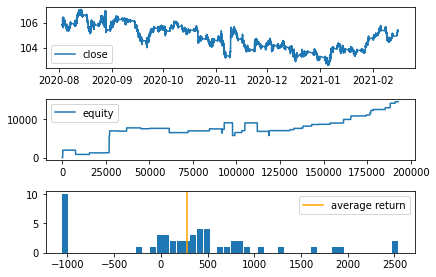

In [24]:
CheckBot(
    account_id=account,
    access_token=token,
    environment='live',
    instrument=inst,
    granularity=glan, # 15 second candlestick,
).backtest(from_date=start, to_date=end, filename="backtest.png")